## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split

## Import dataset

In [2]:
df_backup = pd.read_csv('base_modelo_preprocessed.csv')
df_backup.head()

Unnamed: 0  id   safra  y  VAR_1  VAR_2  VAR_3  VAR_4   VAR_5   VAR_6  ...  \
0           0   1  201404  0    0.0    0.0    0.0    0.0  124.54  3277.0  ...   
1           1   2  201407  0   64.0    0.0    2.0    1.0   47.92  2443.0  ...   
2           2   3  201405  0   99.0    2.0    2.0    2.0   80.38  1824.0  ...   
3           3   4  201412  0    0.0    0.0    0.0    0.0   10.58  3796.0  ...   
4           4   5  201403  1    0.0    0.0    0.0    0.0   70.46   437.0  ...   

   VAR_58  VAR_59    VAR_60  VAR_64   VAR_65  VAR_72  VAR_76  target  \
0   369.0   95.54 -0.030478       0  1303.79   151.0  173.06       1   
1   228.0   97.73  0.357324       0  1486.26   187.0  184.69       1   
2   264.0  294.57 -0.411787       0   800.27    96.0  732.00       1   
3    49.0     NaN  0.721630       0      NaN   417.0     NaN       1   
4   332.0     NaN -0.231735       1  1457.78    75.0     NaN       0   

     safra_dt  months_since_cr_line  
0  2014-04-01                  45.0  
1  2014-07-01                  42.0  
2  2014-05-01                  44.0  
3  2014-12-01                  37.0  
4  2014-03-01                  46.0  

[5 rows x 47 columns]

In [3]:
df = df_backup.copy()
df.head(1)

Unnamed: 0  id   safra  y  VAR_1  VAR_2  VAR_3  VAR_4   VAR_5   VAR_6  ...  \
0           0   1  201404  0    0.0    0.0    0.0    0.0  124.54  3277.0  ...   

   VAR_58  VAR_59    VAR_60  VAR_64   VAR_65  VAR_72  VAR_76  target  \
0   369.0   95.54 -0.030478       0  1303.79   151.0  173.06       1   

     safra_dt  months_since_cr_line  
0  2014-04-01                  45.0  

[1 rows x 47 columns]

In [4]:
df.shape

(10738, 47)

### 1. Split the data

In [5]:
df_inputs_train, df_inputs_test, df_targets_train, df_targets_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size = 0.2, random_state = 42)

In [6]:
df_inputs_train.shape

(8590, 46)

In [7]:
df_inputs_test.shape

(2148, 46)

In [8]:
df_targets_train.shape

(8590,)

In [9]:
df_targets_test.shape

(2148,)

In [10]:
df_inputs_prepr = df_inputs_test
df_targets_prepr = df_targets_test

### 2. Check multicollinearity

In [11]:
# Drop 
to_drop = ['VAR_40', 'VAR_57', 'VAR_19', 'VAR_44', 'VAR_13', 'VAR_24', 'VAR_39', 'VAR_25', 'VAR_5']
to_drop = list(set(to_drop))
df_clean = df_inputs_prepr.drop(columns=to_drop)

print(f"Features dropped due high correlation: {to_drop}\n")
print(f"Features remaining: {df_clean.columns}")

Features dropped due high correlation: ['VAR_24', 'VAR_57', 'VAR_44', 'VAR_19', 'VAR_5', 'VAR_39', 'VAR_40', 'VAR_25', 'VAR_13']

Features remaining: Index(['Unnamed: 0', 'id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3', 'VAR_4',
       'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15', 'VAR_17',
       'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32', 'VAR_33', 'VAR_34',
       'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52', 'VAR_53', 'VAR_54', 'VAR_58',
       'VAR_59', 'VAR_60', 'VAR_64', 'VAR_65', 'VAR_72', 'VAR_76', 'safra_dt',
       'months_since_cr_line'],
      dtype='object')


In [12]:
df_clean.shape

(2148, 37)

In [13]:
df_inputs_prepr = df_clean.copy()

### 3. WoE for Fine and Coarse Classing

In [14]:
def WoE_IV_Numeric(data, target, col):
    tab1 = pd.crosstab(index=data[col], columns=target, margins_name='Total', margins=True)
    tab1.columns = ['Bad','Good','Total']
    tab1 = tab1.reset_index()

    # Proportions 
    tab1['%Total'] = tab1['Total']/data.shape[0]
    tab1['%Bad'] = (tab1['Bad']/tab1.tail(1)['Bad'].values)
    tab1['%Good'] = (tab1['Good']/tab1.tail(1)['Good'].values)
    tab1['DefaultRate'] = (tab1['Bad']/tab1['Total'])

    # WoE = ln (%Good/%Bad)
    tab1['WoE'] = np.log(tab1['%Good']/tab1['%Bad'])
    tab1 = tab1.iloc[:-1,:]#.sort_values(by='WoE')
    tab1['diff_WoE'] = tab1['WoE'].diff().abs()

    # IV = sum ((%Good - % Bad) * WoE)
    IV = (tab1['%Good']-tab1['%Bad'])*tab1['WoE']
    tab1['IV'] = IV.sum()

    return tab1

In [15]:
def plot_by_woe(df_woe,rotation_x_labels = 0):
    x = np.array(df_woe.iloc[:,0].apply(str))
    y = df_woe['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x, y, marker='o', linestyle='--',color='k')
    plt.xlabel(df_woe.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_woe.columns[0]))
    plt.xticks(rotation=rotation_x_labels)

In [16]:
df_inputs_prepr.columns.values

array(['Unnamed: 0', 'id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3',
       'VAR_4', 'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15',
       'VAR_17', 'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32',
       'VAR_33', 'VAR_34', 'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52',
       'VAR_53', 'VAR_54', 'VAR_58', 'VAR_59', 'VAR_60', 'VAR_64',
       'VAR_65', 'VAR_72', 'VAR_76', 'safra_dt', 'months_since_cr_line'],
      dtype=object)

In [17]:
var = ['VAR_1', 'VAR_2', 'VAR_3', 'VAR_4',
       'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15', 'VAR_17',
       'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32', 'VAR_33',
       'VAR_34', 'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52', 'VAR_53',
       'VAR_54', 'VAR_58', 'VAR_59', 'VAR_60', 'VAR_64', 'VAR_65',
       'VAR_72', 'VAR_76','months_since_cr_line']

summary = pd.DataFrame({
        'Feature': df_inputs_prepr[var].columns,  # feature name
        'Unique values': [df_inputs_prepr[col].nunique() for col in df_inputs_prepr[var].columns],  # unique values count
        'Pct Missing (%)': [round(df_inputs_prepr[col].isnull().mean() * 100,2) for col in df_inputs_prepr[var].columns]  # mising values percent
    })
summary

Feature  Unique values  Pct Missing (%)
0                  VAR_1            161             3.49
1                  VAR_2             16             3.49
2                  VAR_3             11             3.49
3                  VAR_4             11             3.49
4                  VAR_6           1447             0.65
5                  VAR_7           1031            42.60
6                  VAR_8           1022            43.58
7                  VAR_9            493             0.00
8                 VAR_11            994            44.32
9                 VAR_15            980            45.62
10                VAR_17            466            42.83
11                VAR_20             10             0.00
12                VAR_22            103             0.37
13                VAR_28             13             0.37
14                VAR_30            650             0.37
15                VAR_32              7             0.00
16                VAR_33             41             0.37
17                VAR_34           1056            43.58
18                VAR_35           1036            44.32
19                VAR_38           1060            42.60
20                VAR_45           1081            47.39
21                VAR_52           1016            45.62
22                VAR_53            748            16.57
23                VAR_54            655            12.62
24                VAR_58            631            35.99
25                VAR_59           1168            41.76
26                VAR_60             20             0.00
27                VAR_64              2             0.00
28                VAR_65           1640            20.39
29                VAR_72            635             0.65
30                VAR_76           1215            41.76
31  months_since_cr_line             12             0.00

In [18]:
summary['Unique values'].describe()

count      32.00000
mean      607.21875
std       511.35227
min         2.00000
25%        19.00000
50%       642.50000
75%      1032.25000
max      1640.00000
Name: Unique values, dtype: float64

<Axes: xlabel='Unique values', ylabel='Density'>

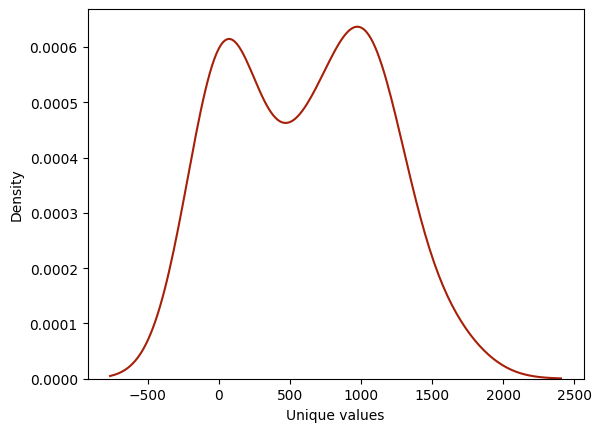

In [19]:
sns.kdeplot(x=summary['Unique values'],color='#a62009')

#### 3.1 Features with less or equal to 50 unique values

In [20]:
summary[summary['Unique values'] <= 50]['Feature'].unique()

array(['VAR_2', 'VAR_3', 'VAR_4', 'VAR_20', 'VAR_28', 'VAR_32', 'VAR_33',
       'VAR_60', 'VAR_64', 'months_since_cr_line'], dtype=object)

/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_2  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0    0.0  450  1383   1833  0.853352  0.742574  0.942740     0.245499   
1    1.0   27    18     45  0.020950  0.044554  0.012270     0.600000   
2    2.0   32    16     48  0.022346  0.052805  0.010907     0.666667   
3    3.0   79    17     96  0.044693  0.130363  0.011588     0.822917   
4    4.0    7    11     18  0.008380  0.011551  0.007498     0.388889   
5    5.0    3     7     10  0.004655  0.004950  0.004772     0.300000   
6    6.0    2     6      8  0.003724  0.003300  0.004090     0.250000   
7    7.0    3     1      4  0.001862  0.004950  0.000682     0.750000   
8    8.0    1     1      2  0.000931  0.001650  0.000682     0.500000   
9    9.0    1     2      3  0.001397  0.001650  0.001363     0.333333   
10  10.0    0     1      1  0.000466  0.000000  0.000682     0.000000   
11  11.0    0     1      1  0.000466  0.000000  0.000682     0.000000   
12  12.0    0     1      1  0.000466  0.000000  0.000682     0.000000   
13  13.0    0     1      1  0.000466  0.000000  0.000682     0.000000   
14  14.0    1     0      1  0.000466  0.001650  0.000000     1.000000   
15  17.0    0     1      1  0.000466  0.000000  0.000682     0.000000   

         WoE  diff_WoE   IV  
0   0.238668       NaN  inf  
1  -1.289560  1.528228  inf  
2  -1.577242  0.287682  inf  
3  -2.420329  0.843087  inf  
4  -0.432110  1.988220  inf  
5  -0.036797  0.395313  inf  
6   0.214517  0.251314  inf  
7  -1.982707  2.197225  inf  
8  -0.884095  1.098612  inf  
9  -0.190948  0.693147  inf  
10       inf       inf  inf  
11       inf       NaN  inf  
12       inf       NaN  inf  
13       inf       NaN  inf  
14      -inf       inf  inf  
15       inf       inf  inf

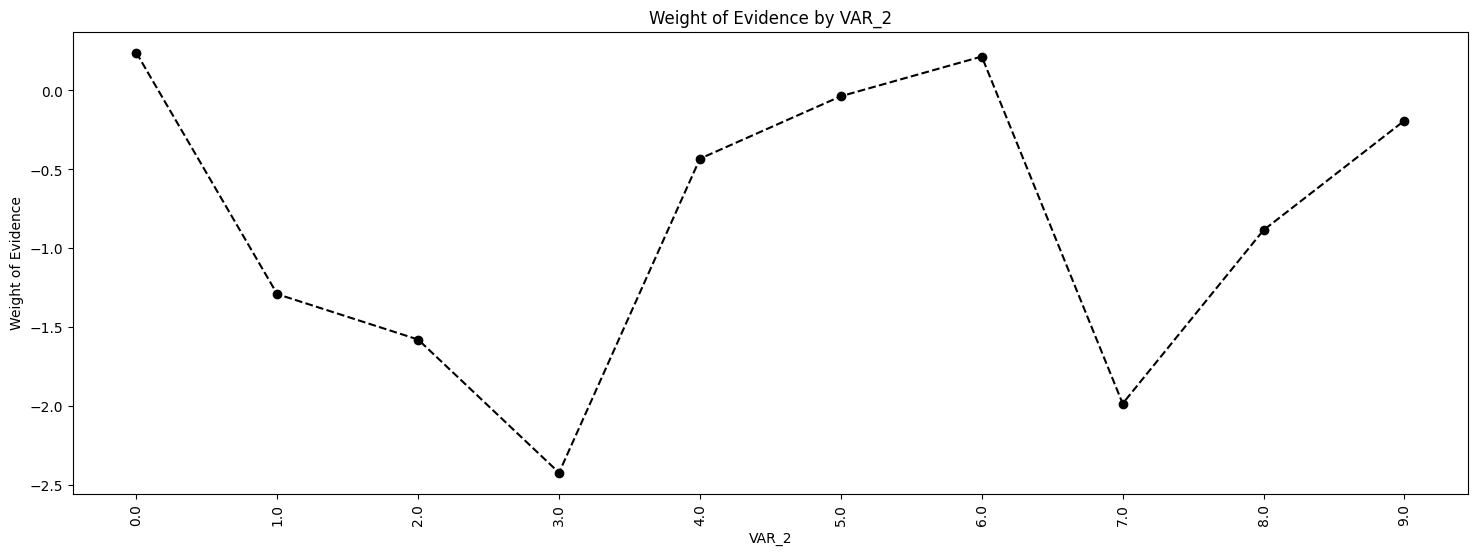

In [21]:
# VAR_2
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_2')
display(WoE)
plot_by_woe(WoE,90)

In [22]:
df_inputs_prepr['VAR_2'].isnull().sum()

75

In [23]:
# VAR_2: 84% of observations contain the value 0
df_inputs_prepr['VAR_2:0'] = np.where((df_inputs_prepr['VAR_2'] == 0), 1, 0)
df_inputs_prepr['VAR_2:1-14_or_missing'] = np.where((df_inputs_prepr['VAR_2'].isin(range(1,15))) | (df_inputs_prepr['VAR_2'].isnull()), 1, 0)

/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_3  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0    0.0  405  1303   1708  0.795158  0.668317  0.888207     0.237119   
1    1.0  161   108    269  0.125233  0.265677  0.073620     0.598513   
2    2.0   16    21     37  0.017225  0.026403  0.014315     0.432432   
3    3.0    4    15     19  0.008845  0.006601  0.010225     0.210526   
4    4.0    6     6     12  0.005587  0.009901  0.004090     0.500000   
5    5.0    4     8     12  0.005587  0.006601  0.005453     0.333333   
6    6.0    4     1      5  0.002328  0.006601  0.000682     0.800000   
7    7.0    5     0      5  0.002328  0.008251  0.000000     1.000000   
8    8.0    0     2      2  0.000931  0.000000  0.001363     0.000000   
9   10.0    0     1      1  0.000466  0.000000  0.000682     0.000000   
10  11.0    1     2      3  0.001397  0.001650  0.001363     0.333333   

         WoE  diff_WoE   IV  
0   0.284443       NaN  inf  
1  -1.283368  1.567811  inf  
2  -0.612161  0.671207  inf  
3   0.437661  1.049822  inf  
4  -0.884095  1.321756  inf  
5  -0.190948  0.693147  inf  
6  -2.270389  2.079442  inf  
7       -inf       inf  inf  
8        inf       inf  inf  
9        inf       NaN  inf  
10 -0.190948       inf  inf

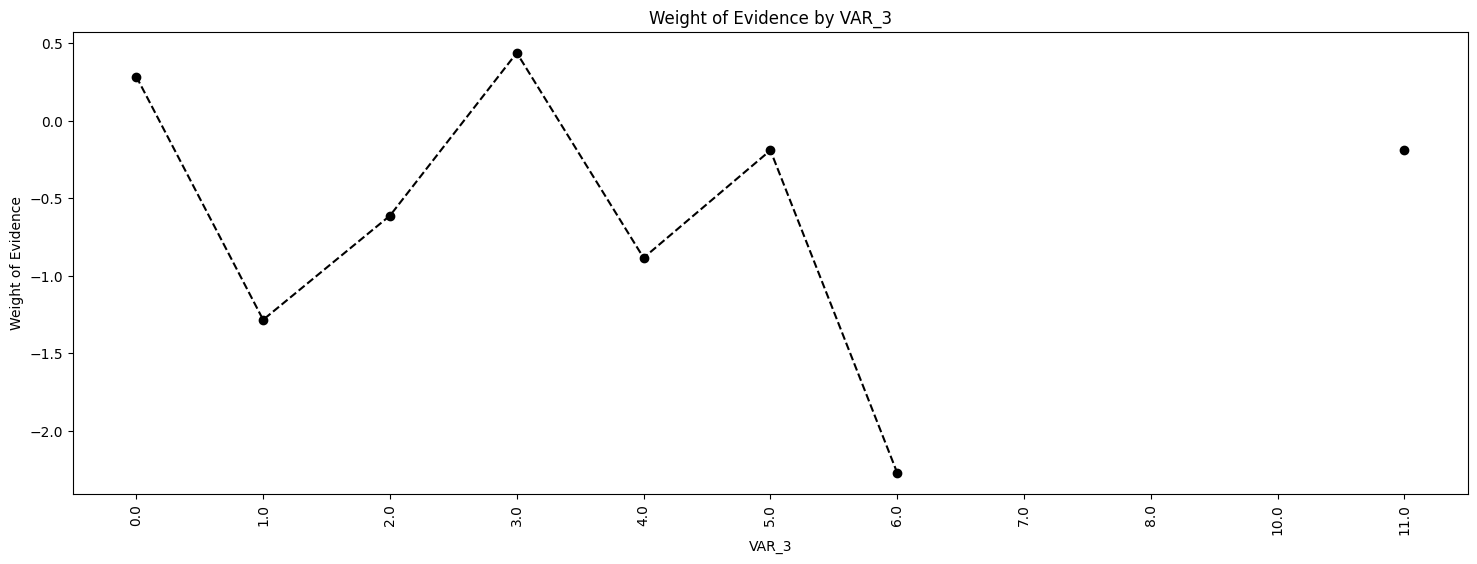

In [24]:
# VAR_3
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_3')
display(WoE)
plot_by_woe(WoE,90)

In [25]:
df_inputs_prepr['VAR_3'].isnull().sum()

75

In [26]:
# VAR_3: 79% of observations contain the value 0
df_inputs_prepr['VAR_3:Missing'] = np.where((df_inputs_prepr['VAR_3'].isnull()), 1, 0)
df_inputs_prepr['VAR_3:0'] = np.where((df_inputs_prepr['VAR_3'] == 0), 1, 0)
df_inputs_prepr['VAR_3:1-10'] = np.where((df_inputs_prepr['VAR_3'] > 0) & (df_inputs_prepr['VAR_3'] <= 10), 1, 0)

/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_4  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0    0.0  307  1133   1440  0.670391  0.506601  0.772324     0.213194   
1    1.0  198   187    385  0.179236  0.326733  0.127471     0.514286   
2    2.0   57    70    127  0.059125  0.094059  0.047716     0.448819   
3    3.0   26    31     57  0.026536  0.042904  0.021132     0.456140   
4    4.0    9    13     22  0.010242  0.014851  0.008862     0.409091   
5    5.0    4    14     18  0.008380  0.006601  0.009543     0.222222   
6    6.0    1     9     10  0.004655  0.001650  0.006135     0.100000   
7    7.0    2     3      5  0.002328  0.003300  0.002045     0.400000   
8    8.0    0     5      5  0.002328  0.000000  0.003408     0.000000   
9    9.0    1     2      3  0.001397  0.001650  0.001363     0.333333   
10  10.0    1     0      1  0.000466  0.001650  0.000000     1.000000   

         WoE  diff_WoE   IV  
0   0.421682       NaN  inf  
1  -0.941253  1.362935  inf  
2  -0.678651  0.262602  inf  
3  -0.708204  0.029553  inf  
4  -0.516370  0.191834  inf  
5   0.368668  0.885038  inf  
6   1.313130  0.944462  inf  
7  -0.478630  1.791759  inf  
8        inf       inf  inf  
9  -0.190948       inf  inf  
10      -inf       inf  inf

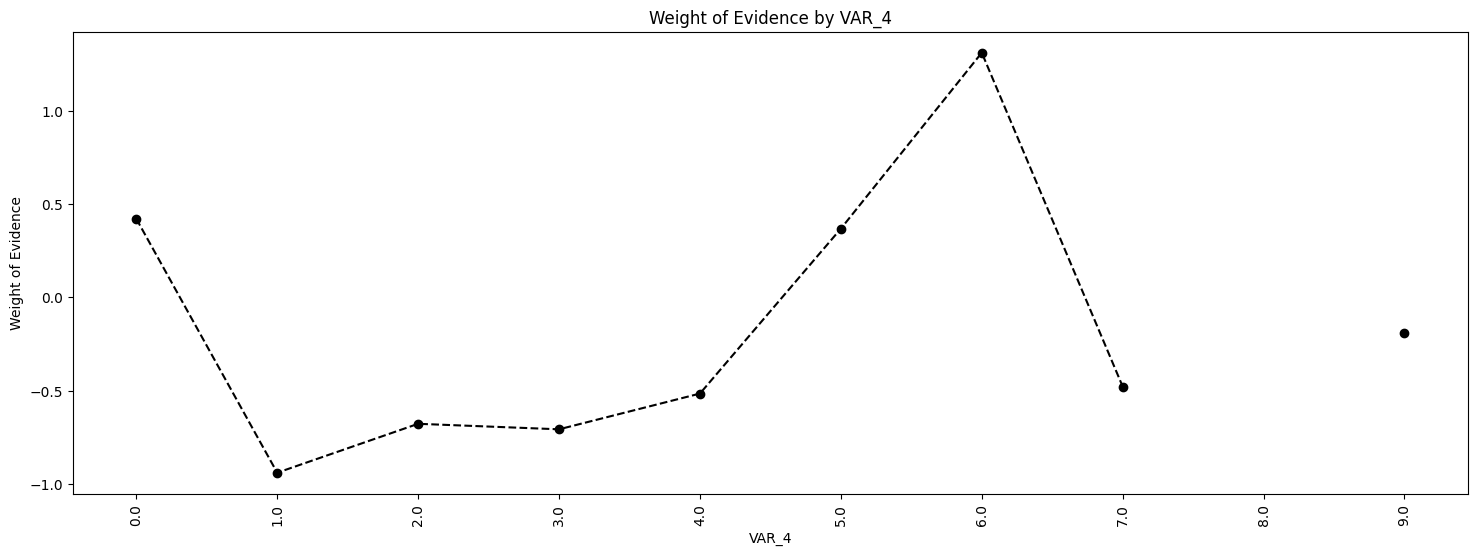

In [27]:
# VAR_4
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_4')
display(WoE)
plot_by_woe(WoE,90)

In [28]:
df_inputs_prepr['VAR_4'].isnull().sum()

75

In [29]:
# VAR_4: 66% of observations contain the value 0
df_inputs_prepr['VAR_4:Missing'] = np.where((df_inputs_prepr['VAR_4'].isnull()), 1, 0)
df_inputs_prepr['VAR_4:0'] = np.where((df_inputs_prepr['VAR_4']==0), 1, 0)
df_inputs_prepr['VAR_4:1-14'] = np.where((df_inputs_prepr['VAR_4'].isin(range(1,14))), 1, 0)

VAR_20  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0      3    6    66     72  0.033520  0.009693  0.043165     0.083333   
1      4    4    45     49  0.022812  0.006462  0.029431     0.081633   
2      5   12    69     81  0.037709  0.019386  0.045128     0.148148   
3      6   20   123    143  0.066574  0.032310  0.080445     0.139860   
4      7    4    19     23  0.010708  0.006462  0.012426     0.173913   
5      8   21    59     80  0.037244  0.033926  0.038587     0.262500   
6      9    5    15     20  0.009311  0.008078  0.009810     0.250000   
7     10   39   134    173  0.080540  0.063005  0.087639     0.225434   
8     11    0     1      1  0.000466  0.000000  0.000654     0.000000   
9     12  508   998   1506  0.701117  0.820679  0.652714     0.337317   

        WoE  diff_WoE   IV  
0  1.493631       NaN  inf  
1  1.516104  0.022473  inf  
2  0.844936  0.671168  inf  
3  0.912188  0.067252  inf  
4  0.653881  0.258307  inf  
5  0.128751  0.525130  inf  
6  0.194348  0.065597  inf  
7  0.330014  0.135666  inf  
8       inf       inf  inf  
9 -0.228992       inf  inf

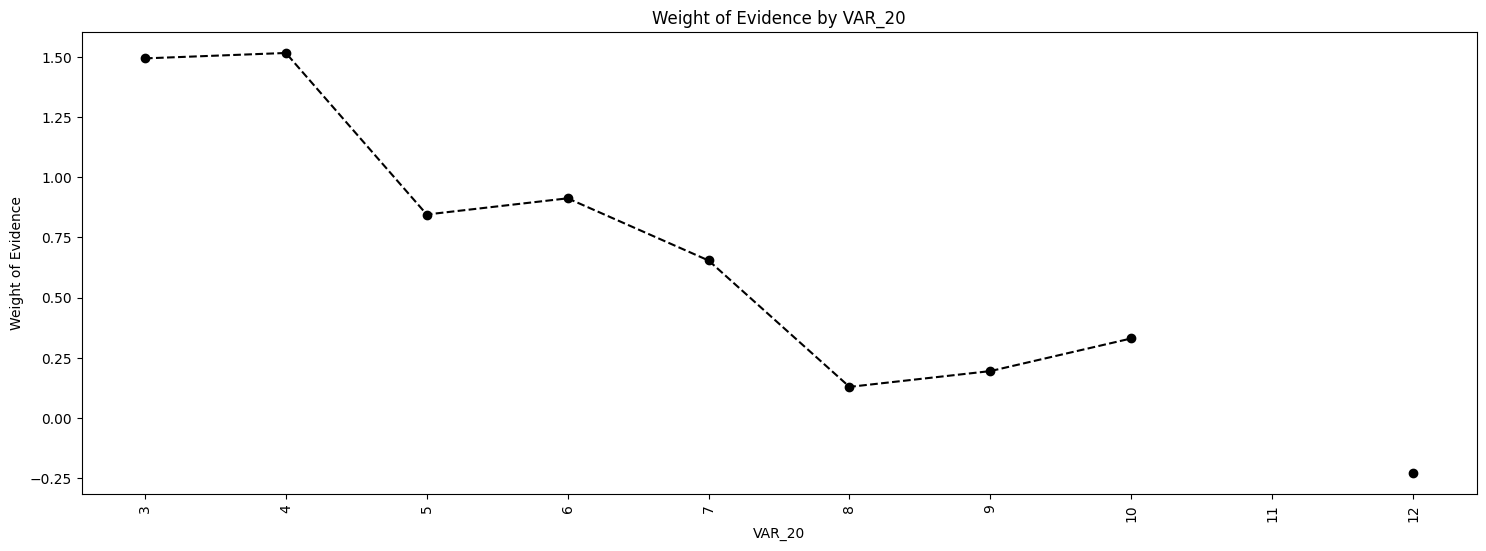

In [30]:
# VAR_20
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_20')
display(WoE)
plot_by_woe(WoE,90)

In [31]:
df_inputs_prepr['VAR_20'].isnull().sum()

0

In [32]:
# VAR_20: 69% with value 12
df_inputs_prepr['VAR_20:3-10'] = np.where((df_inputs_prepr['VAR_20']<=10), 1, 0)
df_inputs_prepr['VAR_20:11-12'] = np.where((df_inputs_prepr['VAR_20']>=11), 1, 0)

VAR_28  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0     0.0  481   936   1417  0.659683  0.780844  0.614173     0.339450   
1     1.0    8    31     39  0.018156  0.012987  0.020341     0.205128   
2     2.0    5    22     27  0.012570  0.008117  0.014436     0.185185   
3     3.0   11    29     40  0.018622  0.017857  0.019029     0.275000   
4     4.0    4    26     30  0.013966  0.006494  0.017060     0.133333   
5     5.0    7    23     30  0.013966  0.011364  0.015092     0.233333   
6     6.0   13    44     57  0.026536  0.021104  0.028871     0.228070   
7     7.0   11    28     39  0.018156  0.017857  0.018373     0.282051   
8     8.0    7    38     45  0.020950  0.011364  0.024934     0.155556   
9     9.0    7    39     46  0.021415  0.011364  0.025591     0.152174   
10   10.0   11    41     52  0.024209  0.017857  0.026903     0.211538   
11   11.0   13    86     99  0.046089  0.021104  0.056430     0.131313   
12   12.0   38   181    219  0.101955  0.061688  0.118766     0.173516   

         WoE  diff_WoE      IV  
0  -0.240099       NaN  0.1588  
1   0.448699  0.688797  0.1588  
2   0.575758  0.127059  0.1588  
3   0.063554  0.512204  0.1588  
4   0.965955  0.902402  0.1588  
5   0.283737  0.682218  0.1588  
6   0.313394  0.029656  0.1588  
7   0.028462  0.284931  0.1588  
8   0.785829  0.757367  0.1588  
9   0.811805  0.025975  0.1588  
10  0.409830  0.401975  0.1588  
11  0.983551  0.573721  0.1588  
12  0.655064  0.328487  0.1588

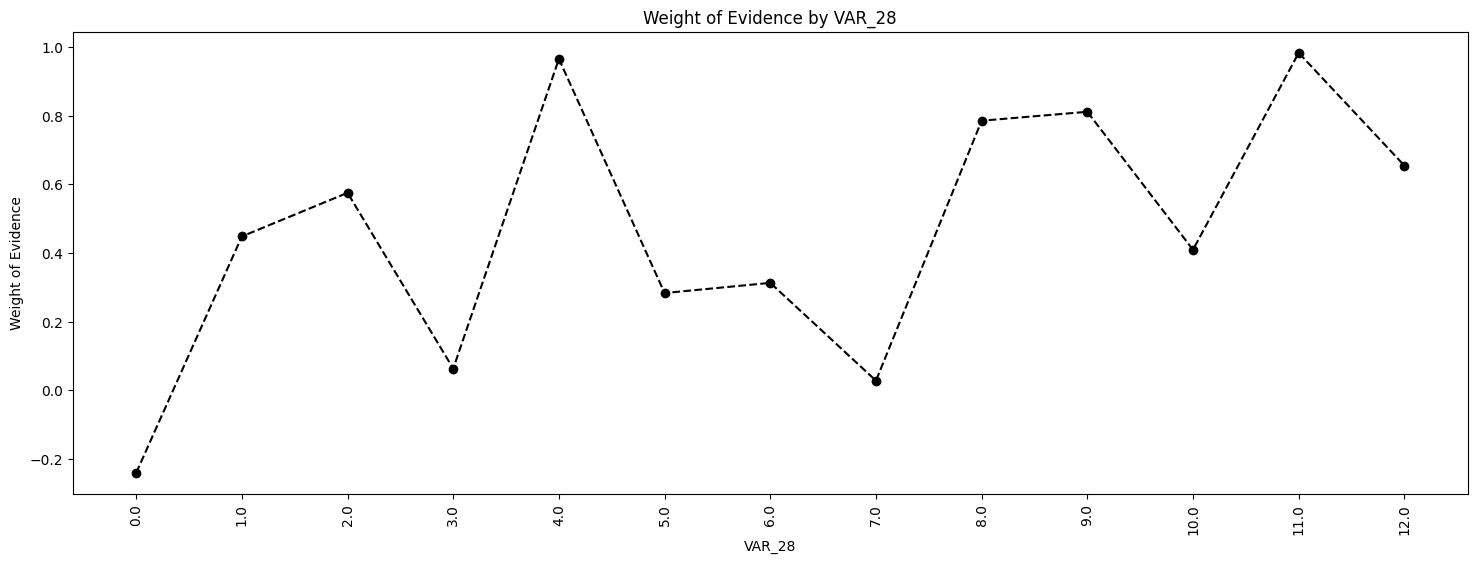

In [33]:
# VAR_28
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_28')
display(WoE)
plot_by_woe(WoE,90)

In [34]:
df_inputs_prepr['VAR_28'].isnull().sum()

8

In [35]:
# VAR_28: 64% of 0 value
df_inputs_prepr['VAR_28:Missing'] = np.where((df_inputs_prepr['VAR_28'].isnull()), 1, 0)
df_inputs_prepr['VAR_28:0_8'] = np.where((df_inputs_prepr['VAR_28'].isin([0,8])), 1, 0)
df_inputs_prepr['VAR_28:1-7_9-12'] = np.where((df_inputs_prepr['VAR_28'].isin([1,2,3,4,5,6,7,9,10,11,12])), 1, 0)

VAR_32  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0 -0.103405    1     1      2  0.000931  0.001616  0.000654     0.500000   
1 -0.038614    1     1      2  0.000931  0.001616  0.000654     0.500000   
2  0.020019    1     1      2  0.000931  0.001616  0.000654     0.500000   
3  0.046709    5    11     16  0.007449  0.008078  0.007194     0.312500   
4  0.057198   82   114    196  0.091248  0.132472  0.074559     0.418367   
5  0.090634  189   321    510  0.237430  0.305331  0.209941     0.370588   
6  0.133833  340  1080   1420  0.661080  0.549273  0.706344     0.239437   

        WoE  diff_WoE        IV  
0 -0.904264       NaN  0.111233  
1 -0.904264  0.000000  0.111233  
2 -0.904264  0.000000  0.111233  
3 -0.115807  0.788457  0.111233  
4 -0.574785  0.458978  0.111233  
5 -0.374570  0.200215  0.111233  
6  0.251507  0.626077  0.111233

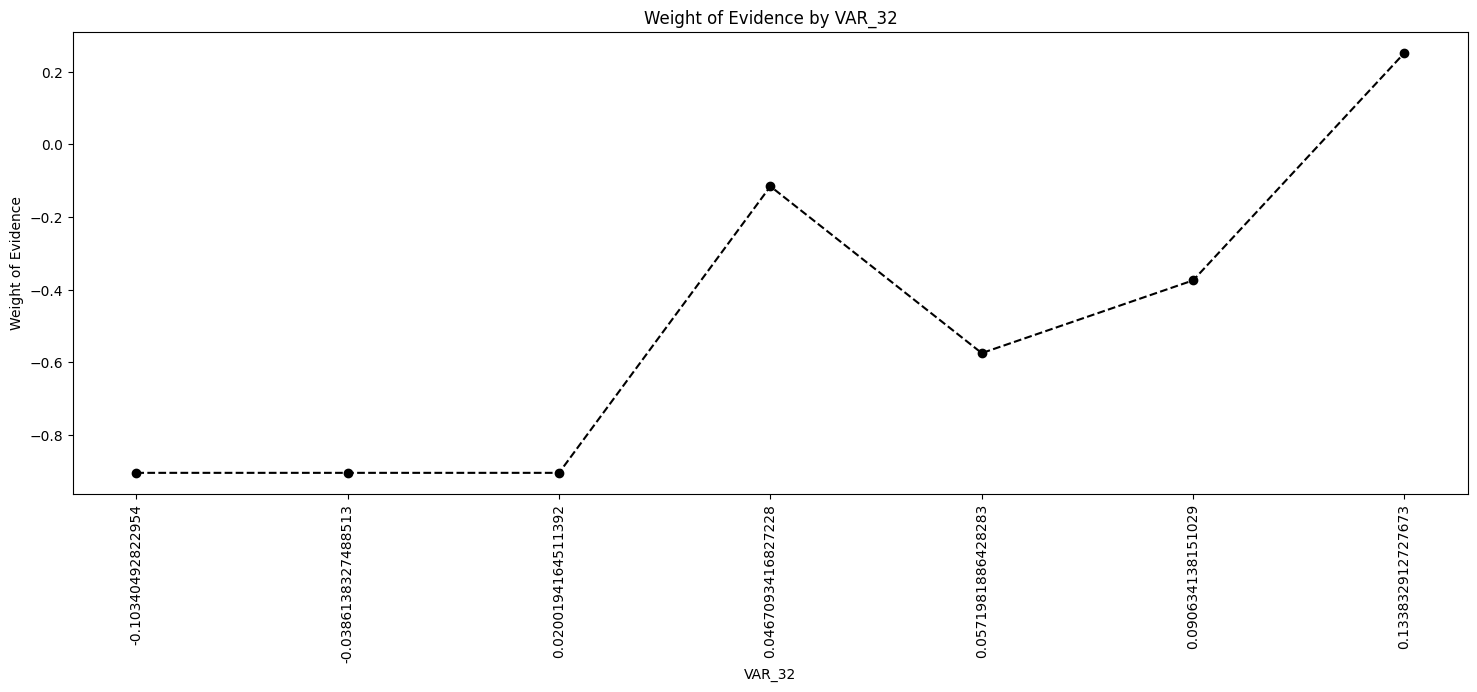

In [36]:
# VAR_32
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_32')
display(WoE)
plot_by_woe(WoE,90)

In [37]:
df_inputs_prepr['VAR_32'].isnull().sum()

0

In [38]:
# VAR_32
df_inputs_prepr['VAR_32:<0.13'] = np.where((df_inputs_prepr['VAR_32']< 0.13), 1, 0)
df_inputs_prepr['VAR_32:>=0.13'] = np.where((df_inputs_prepr['VAR_32']>=0.13), 1, 0)

/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_33  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0     0.0  481   966   1447  0.673650  0.780844  0.633858     0.332412   
1     1.0   25    87    112  0.052142  0.040584  0.057087     0.223214   
2     2.0   16    61     77  0.035847  0.025974  0.040026     0.207792   
3     3.0   20    47     67  0.031192  0.032468  0.030840     0.298507   
4     4.0   14    38     52  0.024209  0.022727  0.024934     0.269231   
5     5.0   12    45     57  0.026536  0.019481  0.029528     0.210526   
6     6.0    7    34     41  0.019088  0.011364  0.022310     0.170732   
7     7.0    5    32     37  0.017225  0.008117  0.020997     0.135135   
8     8.0    2    27     29  0.013501  0.003247  0.017717     0.068966   
9     9.0    3    24     27  0.012570  0.004870  0.015748     0.111111   
10   10.0    5    19     24  0.011173  0.008117  0.012467     0.208333   
11   11.0    4    12     16  0.007449  0.006494  0.007874     0.250000   
12   12.0    1    13     14  0.006518  0.001623  0.008530     0.071429   
13   13.0    2    16     18  0.008380  0.003247  0.010499     0.111111   
14   14.0    3     7     10  0.004655  0.004870  0.004593     0.300000   
15   15.0    1    10     11  0.005121  0.001623  0.006562     0.090909   
16   16.0    1     9     10  0.004655  0.001623  0.005906     0.100000   
17   17.0    1    13     14  0.006518  0.001623  0.008530     0.071429   
18   18.0    2     7      9  0.004190  0.003247  0.004593     0.222222   
19   19.0    1     7      8  0.003724  0.001623  0.004593     0.125000   
20   20.0    1    10     11  0.005121  0.001623  0.006562     0.090909   
21   21.0    1     1      2  0.000931  0.001623  0.000656     0.500000   
22   22.0    1     2      3  0.001397  0.001623  0.001312     0.333333   
23   23.0    0     2      2  0.000931  0.000000  0.001312     0.000000   
24   24.0    0     3      3  0.001397  0.000000  0.001969     0.000000   
25   25.0    0     2      2  0.000931  0.000000  0.001312     0.000000   
26   26.0    3     7     10  0.004655  0.004870  0.004593     0.300000   
27   27.0    0     5      5  0.002328  0.000000  0.003281     0.000000   
28   28.0    0     3      3  0.001397  0.000000  0.001969     0.000000   
29   29.0    1     0      1  0.000466  0.001623  0.000000     1.000000   
30   30.0    1     0      1  0.000466  0.001623  0.000000     1.000000   
31   31.0    0     4      4  0.001862  0.000000  0.002625     0.000000   
32   32.0    0     2      2  0.000931  0.000000  0.001312     0.000000   
33   33.0    0     1      1  0.000466  0.000000  0.000656     0.000000   
34   34.0    1     2      3  0.001397  0.001623  0.001312     0.333333   
35   35.0    0     1      1  0.000466  0.000000  0.000656     0.000000   
36   37.0    0     1      1  0.000466  0.000000  0.000656     0.000000   
37   40.0    1     0      1  0.000466  0.001623  0.000000     1.000000   
38   41.0    0     2      2  0.000931  0.000000  0.001312     0.000000   
39   48.0    0     1      1  0.000466  0.000000  0.000656     0.000000   
40   68.0    0     1      1  0.000466  0.000000  0.000656     0.000000   

         WoE  diff_WoE   IV  
0  -0.208550       NaN  inf  
1   0.341186  0.549736  inf  
2   0.432438  0.091253  inf  
3  -0.051431  0.483870  inf  
4   0.092682  0.144114  inf  
5   0.415909  0.323227  inf  
6   0.674604  0.258695  inf  
7   0.950451  0.275848  inf  
8   1.696843  0.746392  inf  
9   1.173595  0.523248  inf  
10  0.429154  0.744440  inf  
11  0.192766  0.236389  inf  
12  1.659103  1.466337  inf  
13  1.173595  0.485508  inf  
14 -0.058549  1.232144  inf  
15  1.396738  1.455287  inf  
16  1.291378  0.105361  inf  
17  1.659103  0.367725  inf  
18  0.346916  1.312186  inf  
19  1.040063  0.693147  inf  
20  1.396738  0.356675  inf  
21 -0.905847  2.302585  inf  
22 -0.212700  0.693147  inf  
23       inf       inf  inf  
24       inf       NaN  inf  
25       inf       NaN  inf  
26 -0.058549       inf  inf  
27       inf       inf  inf  
28       inf       NaN  

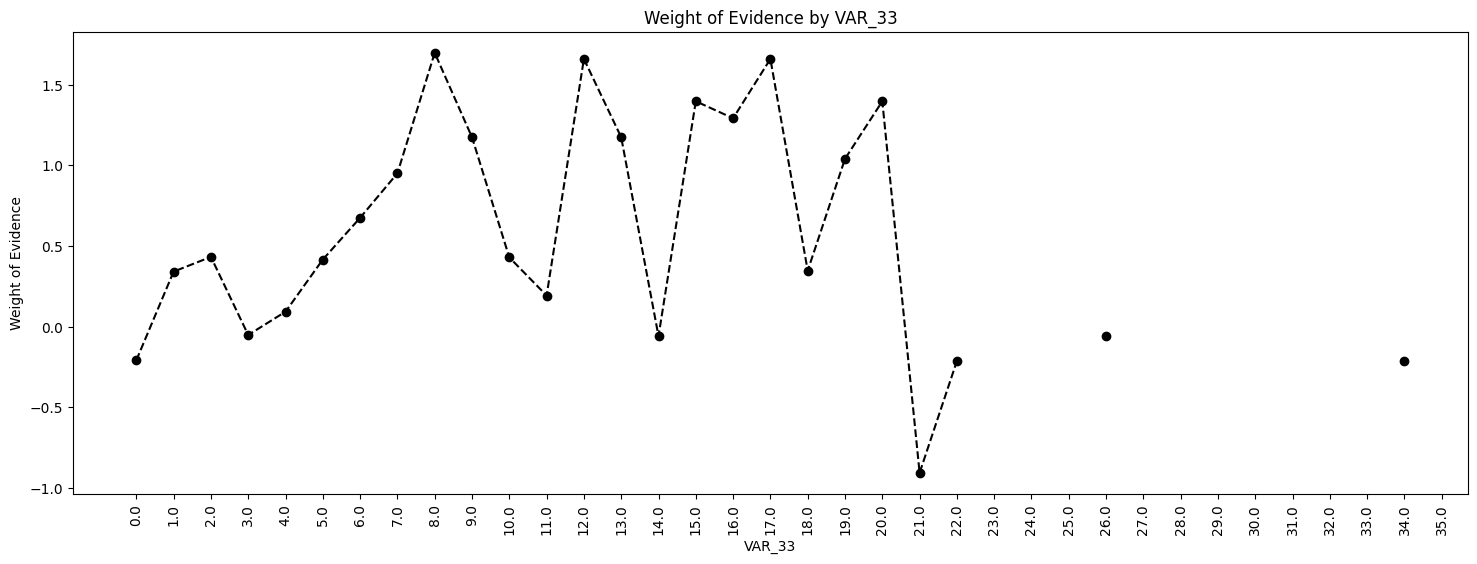

In [39]:
# VAR_33
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_33')
display(WoE)
plot_by_woe(WoE,90)

In [40]:
df_inputs_prepr['VAR_33'].isnull().sum()

8

In [41]:
# VAR_33
df_inputs_prepr['VAR_33:0'] = np.where((df_inputs_prepr['VAR_33']== 0), 1, 0)
df_inputs_prepr['VAR_33:>0_or_missing'] = np.where((df_inputs_prepr['VAR_33']>0) | (df_inputs_prepr['VAR_33'].isnull()), 1, 0)

VAR_60  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0  -0.690749   23    29     52  0.024209  0.037157  0.018967     0.442308   
1  -0.411787  107   171    278  0.129423  0.172859  0.111838     0.384892   
2  -0.354108   29    61     90  0.041899  0.046850  0.039895     0.322222   
3  -0.308453   24    62     86  0.040037  0.038772  0.040549     0.279070   
4  -0.231735   78   170    248  0.115456  0.126010  0.111184     0.314516   
5  -0.133344   24    74     98  0.045624  0.038772  0.048398     0.244898   
6  -0.073756   18    41     59  0.027467  0.029079  0.026815     0.305085   
7  -0.059299   21    80    101  0.047020  0.033926  0.052322     0.207921   
8  -0.030478   19    43     62  0.028864  0.030695  0.028123     0.306452   
9  -0.016209   16    37     53  0.024674  0.025848  0.024199     0.301887   
10  0.079926   52   132    184  0.085661  0.084006  0.086331     0.282609   
11  0.156301   45   123    168  0.078212  0.072698  0.080445     0.267857   
12   0.21938   39   113    152  0.070764  0.063005  0.073905     0.256579   
13   0.24288   16    35     51  0.023743  0.025848  0.022891     0.313725   
14  0.319425    8    30     38  0.017691  0.012924  0.019621     0.210526   
15  0.357324   46   131    177  0.082402  0.074313  0.085677     0.259887   
16  0.412256    7    16     23  0.010708  0.011309  0.010464     0.304348   
17  0.534878   16    59     75  0.034916  0.025848  0.038587     0.213333   
18  0.648197   10    39     49  0.022812  0.016155  0.025507     0.204082   
19   0.72163   21    83    104  0.048417  0.033926  0.054284     0.201923   

         WoE  diff_WoE        IV  
0  -0.672462       NaN  0.078847  
1  -0.435429  0.237033  0.078847  
2  -0.160686  0.274743  0.078847  
3   0.044817  0.205503  0.078847  
4  -0.125174  0.169991  0.078847  
5   0.221747  0.346922  0.078847  
6  -0.081064  0.302811  0.078847  
7   0.433240  0.514304  0.078847  
8  -0.087503  0.520743  0.078847  
9  -0.065935  0.021568  0.078847  
10  0.027294  0.093229  0.078847  
11  0.101258  0.073964  0.078847  
12  0.159562  0.058304  0.078847  
13 -0.121505  0.281067  0.078847  
14  0.417492  0.538997  0.078847  
15  0.142292  0.275200  0.078847  
16 -0.077585  0.219877  0.078847  
17  0.400685  0.478270  0.078847  
18  0.456713  0.056028  0.078847  
19  0.470054  0.013342  0.078847

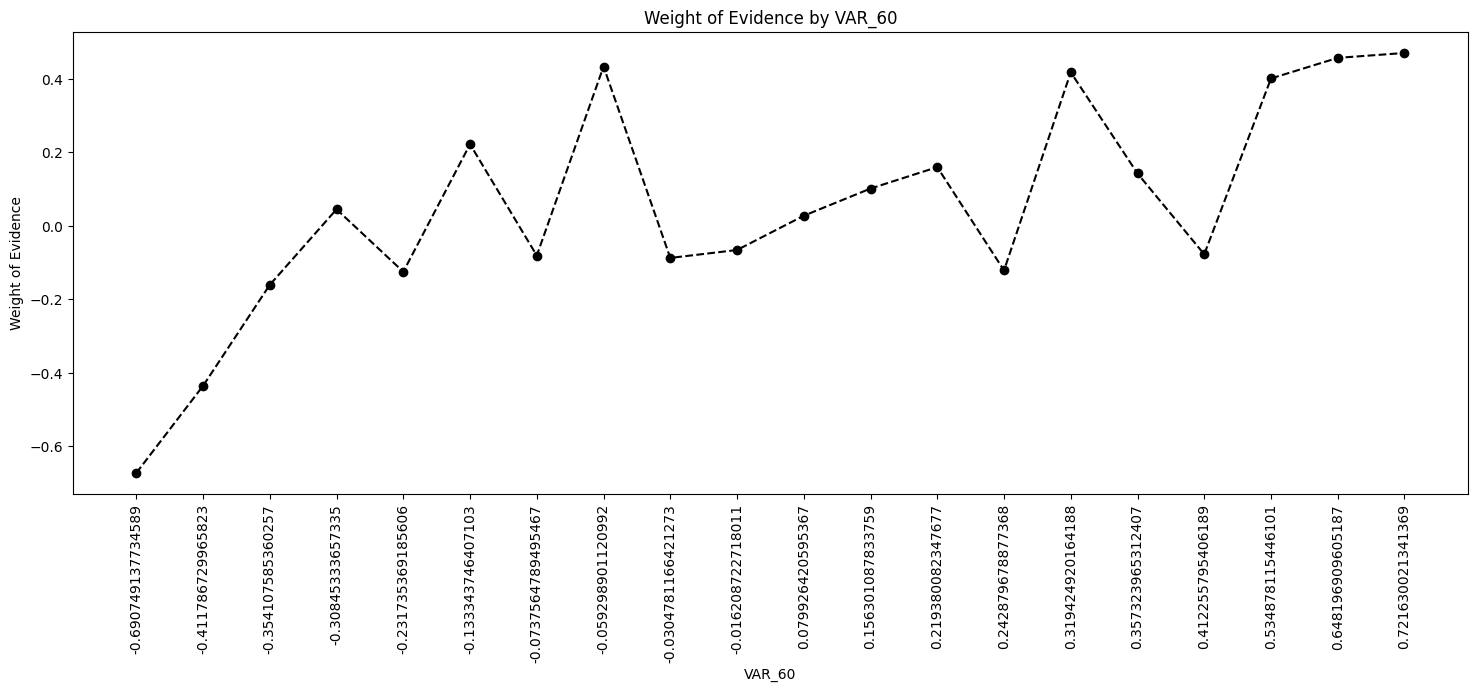

In [42]:
# VAR_60
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_60')
display(WoE)
plot_by_woe(WoE,90)

In [43]:
df['VAR_60']

0       -0.030478
1        0.357324
2       -0.411787
3        0.721630
4       -0.231735
           ...   
10733   -0.411787
10734   -0.133344
10735   -0.030478
10736   -0.411787
10737   -0.411787
Name: VAR_60, Length: 10738, dtype: float64

In [44]:
df_inputs_prepr['VAR_60'].isnull().sum()

0

In [45]:
# VAR_60
df_inputs_prepr['VAR_60:<-.025'] = np.where((df_inputs_prepr['VAR_60']< -0.25), 1, 0)
df_inputs_prepr['VAR_60:-0.25to-0.004'] = np.where((df_inputs_prepr['VAR_60']>=-0.25) & (df_inputs_prepr['VAR_60']<=-0.004), 1, 0)
df_inputs_prepr['VAR_60:>-0.004'] = np.where((df_inputs_prepr['VAR_60']>-0.004), 1, 0)

VAR_64  Bad  Good  Total    %Total     %Bad     %Good  DefaultRate  \
0      0  158   638    796  0.370577  0.25525  0.417266     0.198492   
1      1  461   891   1352  0.629423  0.74475  0.582734     0.340976   

        WoE  diff_WoE        IV  
0  0.491479       NaN  0.119373  
1 -0.245318  0.736797  0.119373

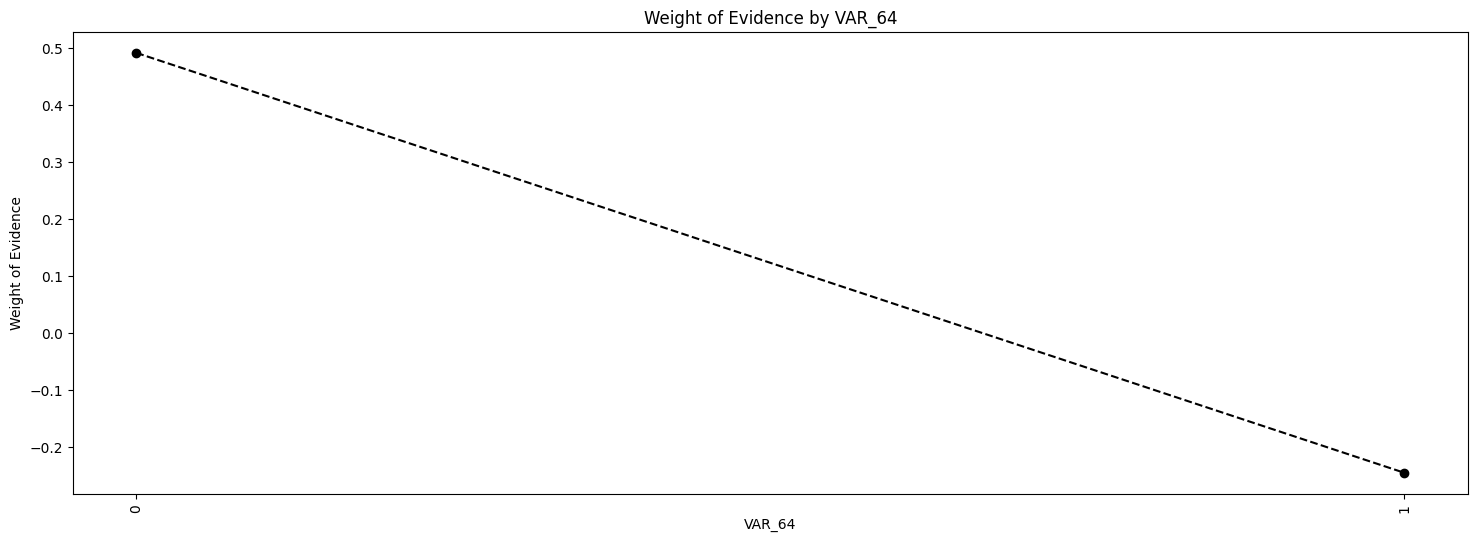

In [46]:
# VAR_64
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_64')
display(WoE)
plot_by_woe(WoE,90)

In [47]:
# VAR_64
df_inputs_prepr['VAR_64:0'] = np.where((df_inputs_prepr['VAR_64']== 0), 1, 0)
df_inputs_prepr['VAR_64:1'] = np.where((df_inputs_prepr['VAR_64']==1), 1, 0)

months_since_cr_line  Bad  Good  Total    %Total      %Bad     %Good  \
0                  37.0   54   102    156  0.072626  0.087237  0.066710   
1                  38.0   55   122    177  0.082402  0.088853  0.079791   
2                  39.0   49   120    169  0.078678  0.079160  0.078483   
3                  40.0   50   126    176  0.081937  0.080775  0.082407   
4                  41.0   57   141    198  0.092179  0.092084  0.092217   
5                  42.0   57   137    194  0.090317  0.092084  0.089601   
6                  43.0   46   136    182  0.084730  0.074313  0.088947   
7                  44.0   48   140    188  0.087523  0.077544  0.091563   
8                  45.0   48   144    192  0.089385  0.077544  0.094179   
9                  46.0   41   108    149  0.069367  0.066236  0.070634   
10                 47.0   57   127    184  0.085661  0.092084  0.083061   
11                 48.0   57   126    183  0.085196  0.092084  0.082407   

    DefaultRate       WoE  diff_WoE        IV  
0      0.346154 -0.268275       NaN  0.017069  
1      0.310734 -0.107576  0.160699  0.017069  
2      0.289941 -0.008592  0.098984  0.017069  
3      0.284091  0.019995  0.028587  0.017069  
4      0.287879  0.001445  0.018550  0.017069  
5      0.293814 -0.027334  0.028779  0.017069  
6      0.252747  0.179750  0.207084  0.017069  
7      0.255319  0.166177  0.013572  0.017069  
8      0.250000  0.194348  0.028171  0.017069  
9      0.275168  0.064295  0.130053  0.017069  
10     0.309783 -0.103128  0.167423  0.017069  
11     0.311475 -0.111033  0.007905  0.017069

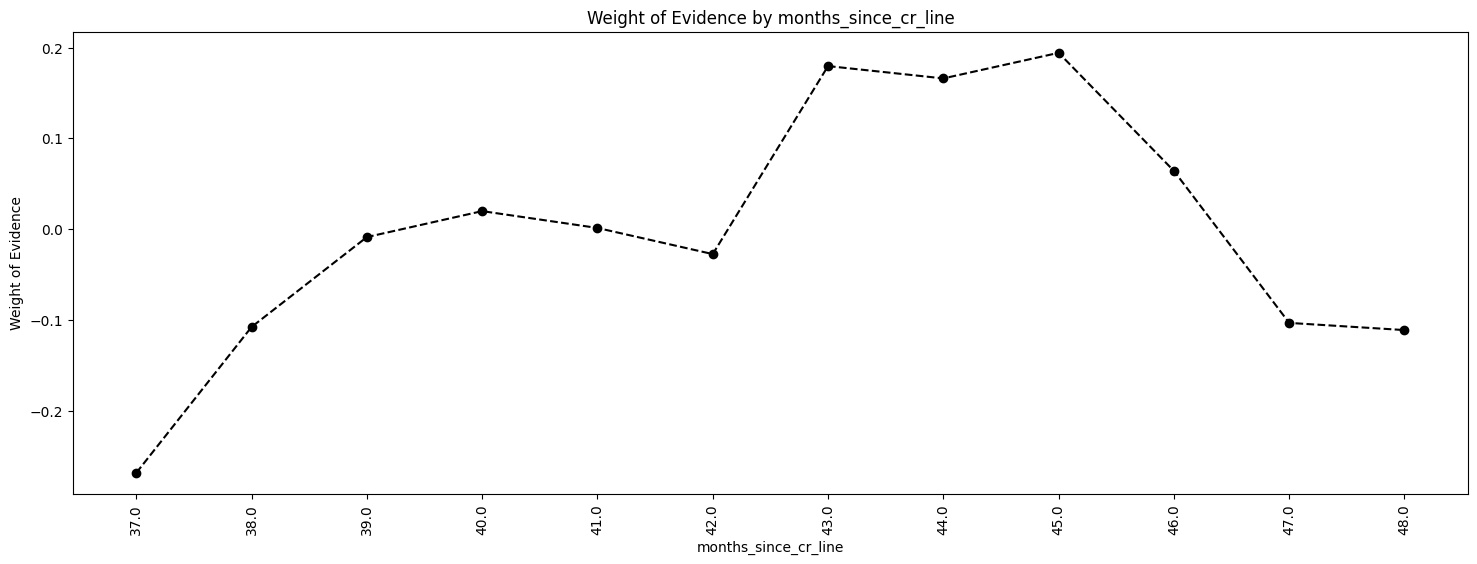

In [48]:
# months_since_cr_line
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'months_since_cr_line')
display(WoE)
plot_by_woe(WoE,90)

In [49]:
# months_since_cr_line
df_inputs_prepr['months_since_cr_line:37-38'] = np.where((df_inputs_prepr['months_since_cr_line'].isin(range(37,39))), 1, 0)
df_inputs_prepr['months_since_cr_line:39'] = np.where((df_inputs_prepr['months_since_cr_line']==39), 1, 0)
df_inputs_prepr['months_since_cr_line:40'] = np.where((df_inputs_prepr['months_since_cr_line']==40), 1, 0)
df_inputs_prepr['months_since_cr_line:41-46'] = np.where((df_inputs_prepr['months_since_cr_line'].isin(range(41,47))), 1, 0)
df_inputs_prepr['months_since_cr_line:47-48'] = np.where((df_inputs_prepr['months_since_cr_line'].isin(range(47,49))), 1, 0)

#### 3.2 Features with more than 50 unique values

In [50]:
summary[summary['Unique values'] > 50]['Feature']

0      VAR_1
4      VAR_6
5      VAR_7
6      VAR_8
7      VAR_9
8     VAR_11
9     VAR_15
10    VAR_17
12    VAR_22
14    VAR_30
17    VAR_34
18    VAR_35
19    VAR_38
20    VAR_45
21    VAR_52
22    VAR_53
23    VAR_54
24    VAR_58
25    VAR_59
28    VAR_65
29    VAR_72
30    VAR_76
Name: Feature, dtype: object

/tmp/ipykernel_11938/1707412951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_1_factor'] = pd.cut(df_inputs_prepr_temp['VAR_1'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_1_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0     (-0.189, 3.78]  129   533    662  0.319344  0.212871  0.363327   
1       (3.78, 7.56]   39   112    151  0.072841  0.064356  0.076346   
2      (7.56, 11.34]   30    80    110  0.053063  0.049505  0.054533   
3     (11.34, 15.12]   17    53     70  0.033767  0.028053  0.036128   
4      (15.12, 18.9]   16    79     95  0.045827  0.026403  0.053851   
5      (18.9, 22.68]   48   159    207  0.099855  0.079208  0.108384   
6     (22.68, 26.46]   16    85    101  0.048722  0.026403  0.057941   
7     (26.46, 30.24]    8    24     32  0.015437  0.013201  0.016360   
8     (30.24, 34.02]   14    28     42  0.020260  0.023102  0.019087   
9      (34.02, 37.8]    8    23     31  0.014954  0.013201  0.015678   
10     (37.8, 41.58]   11    17     28  0.013507  0.018152  0.011588   
11    (41.58, 45.36]   11    10     21  0.010130  0.018152  0.006817   
12    (45.36, 49.14]   17    29     46  0.022190  0.028053  0.019768   
13    (49.14, 52.92]   25    42     67  0.032320  0.041254  0.028630   
14     (52.92, 56.7]    7    12     19  0.009165  0.011551  0.008180   
15     (56.7, 60.48]    5    14     19  0.009165  0.008251  0.009543   
16    (60.48, 64.26]    8    10     18  0.008683  0.013201  0.006817   
17    (64.26, 68.04]    9    17     26  0.012542  0.014851  0.011588   
18    (68.04, 71.82]    1     5      6  0.002894  0.001650  0.003408   
19     (71.82, 75.6]    5    10     15  0.007236  0.008251  0.006817   
20     (75.6, 79.38]    8    15     23  0.011095  0.013201  0.010225   
21    (79.38, 83.16]   11    13     24  0.011577  0.018152  0.008862   
22    (83.16, 86.94]    2     9     11  0.005306  0.003300  0.006135   
23    (86.94, 90.72]    5     4      9  0.004342  0.008251  0.002727   
24     (90.72, 94.5]    4    10     14  0.006753  0.006601  0.006817   
25     (94.5, 98.28]    3     7     10  0.004824  0.004950  0.004772   
26   (98.28, 102.06]    9     3     12  0.005789  0.014851  0.002045   
27  (102.06, 105.84]    4     2      6  0.002894  0.006601  0.001363   
28  (105.84, 109.62]    5     2      7  0.003377  0.008251  0.001363   
29   (109.62, 113.4]    7     9     16  0.007718  0.011551  0.006135   
30   (113.4, 117.18]    2     4      6  0.002894  0.003300  0.002727   
31  (117.18, 120.96]    2     2      4  0.001930  0.003300  0.001363   
32  (120.96, 124.74]    4     1      5  0.002412  0.006601  0.000682   
33  (124.74, 128.52]    4     3      7  0.003377  0.006601  0.002045   
34   (128.52, 132.3]    3     6      9  0.004342  0.004950  0.004090   
35   (132.3, 136.08]    2     7      9  0.004342  0.003300  0.004772   
36  (136.08, 139.86]    2     2      4  0.001930  0.003300  0.001363   
37  (139.86, 143.64]   10     2     12  0.005789  0.016502  0.001363   
38  (143.64, 147.42]    2     1      3  0.001447  0.003300  0.000682   
39   (147.42, 151.2]    6     1      7  0.003377  0.009901  0.000682   
40   (151.2, 154.98]    3     2      5  0.002412  0.004950  0.001363   
41  (154.98, 158.76]    7     1      8  0.003859  0.011551  0.000682   
42  (158.76, 162.54]    7     5     12  0.005789  0.011551  0.003408   
43  (162.54, 166.32]   15     0     15  0.007236  0.024752  0.000000   
44   (166.32, 170.1]   16     4     20  0.009648  0.026403  0.002727   
45   (170.1, 173.88]   12     5     17  0.008201  0.019802  0.003408   
46  (173.88, 177.66]   15     2     17  0.008201  0.024752  0.001363   
47  (177.66, 181.44]   11     2     13  0.006271  0.018152  0.001363   
48  (181.44, 185.22]    0     1      1  0.000482  0.000000  0.000682   
49   (185.22, 189.0]    1     0      1  0.000482  0.001650  0.000000   

    DefaultRate       WoE  diff_WoE   IV  
0      0.194864  0.534614       NaN  inf  
1      0.258278  0.170842  0.363772  inf  
2      0.272727  0.096734  0.074108  inf  
3      0.242857  0.252984  0.156249  inf  
4      0.168421  0.712764  0.459781  inf  
5      0.231884  0.313608  0.399156  inf  
6      0.158416  0.785968  0.47235

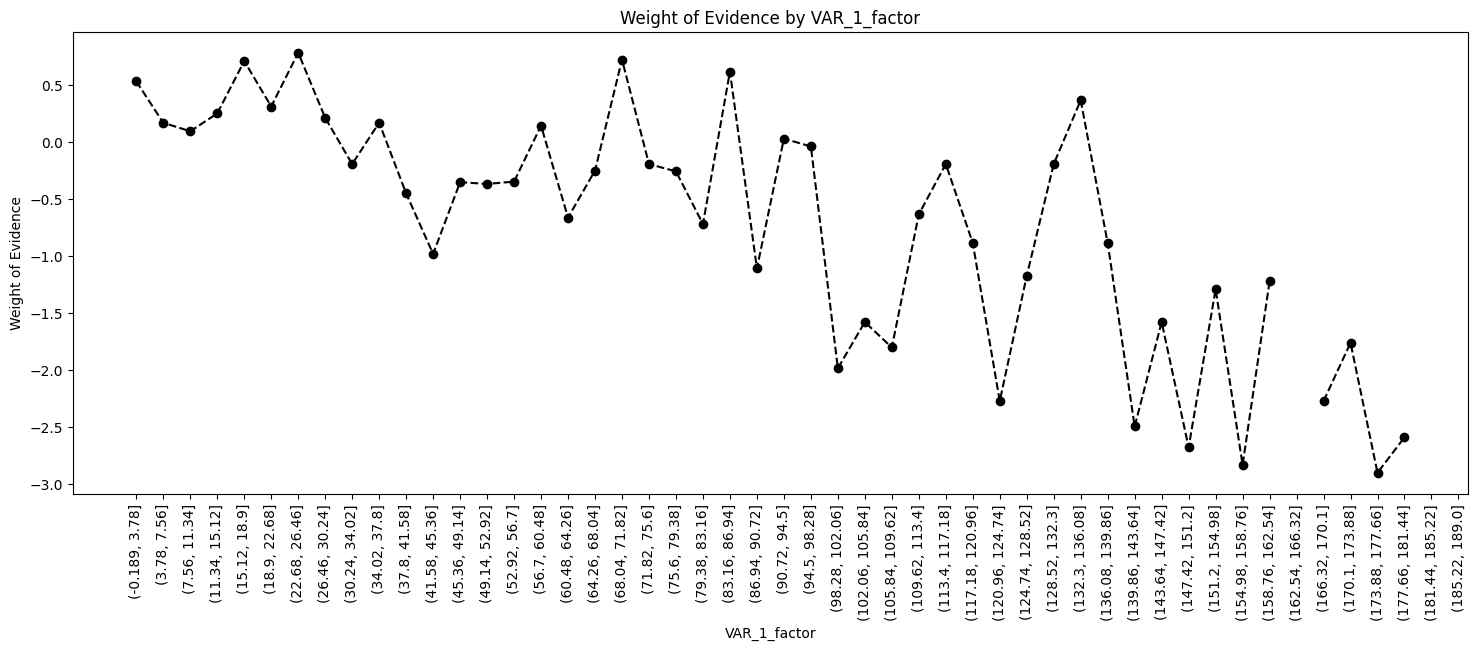

In [51]:
# Fine classing - VAR_1
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_1'])]
df_inputs_prepr_temp[f'VAR_1_factor'] = pd.cut(df_inputs_prepr_temp['VAR_1'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_1_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

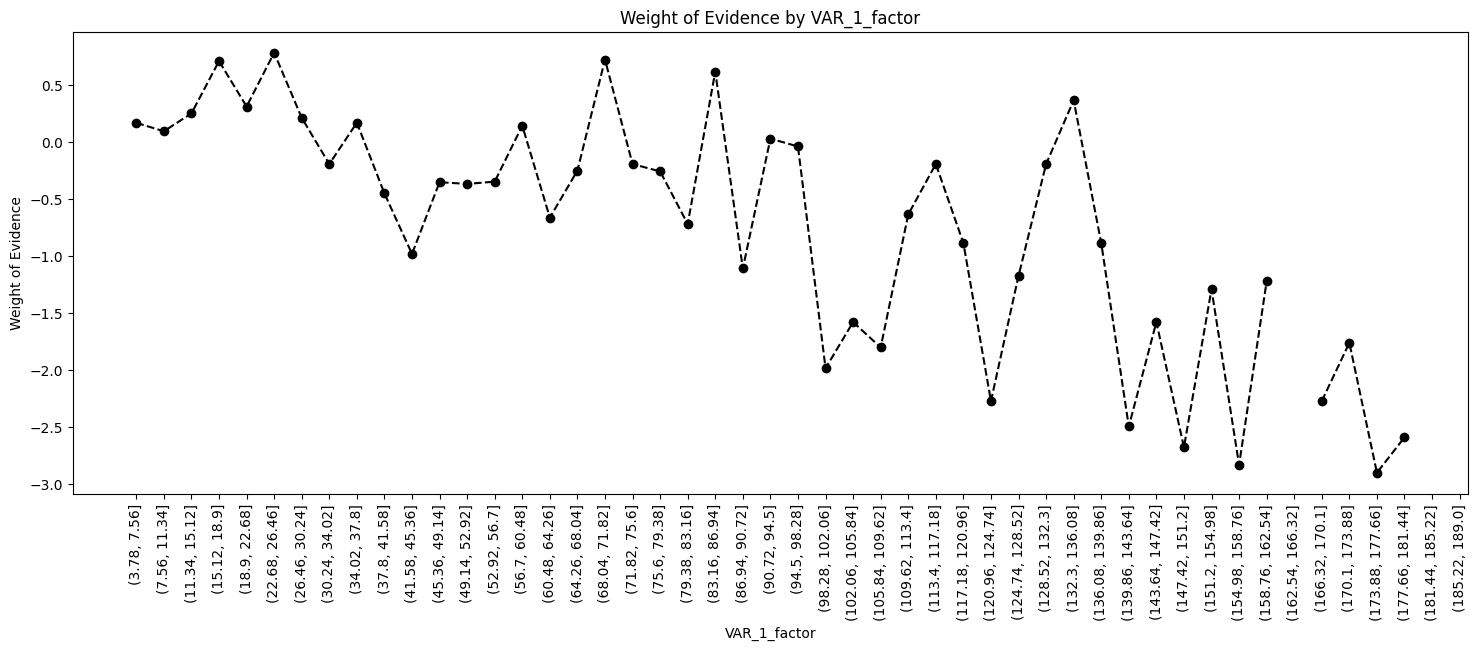

In [52]:
plot_by_woe(WoE_factor.iloc[1:,:],90)

In [53]:
df_inputs_prepr['VAR_1'].isnull().sum()

75

In [54]:
# VAR_1
df_inputs_prepr['VAR_1:<=4.16'] = np.where((df_inputs_prepr['VAR_1']<=4.16), 1, 0)
df_inputs_prepr['VAR_1:4.16-66.56'] = np.where((df_inputs_prepr['VAR_1']>4.16) & (df_inputs_prepr['VAR_1']<=66.56), 1, 0)
df_inputs_prepr['VAR_1:66.56-128.96'] = np.where((df_inputs_prepr['VAR_1']>66.56) & (df_inputs_prepr['VAR_1']<=128.96), 1, 0)
df_inputs_prepr['VAR_1:>128.96_or_missing'] = np.where((df_inputs_prepr['VAR_1']>128.96) | (df_inputs_prepr['VAR_1'].isnull()), 1, 0)

/tmp/ipykernel_11938/3577949158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_6_factor'] = pd.cut(df_inputs_prepr_temp['VAR_6'],50)


VAR_6_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0     (-14.122, 93.44]    3     3      6  0.002812  0.004886  0.001974   
1      (93.44, 195.88]   29    32     61  0.028585  0.047231  0.021053   
2     (195.88, 298.32]   82   126    208  0.097470  0.133550  0.082895   
3     (298.32, 400.76]   74   111    185  0.086692  0.120521  0.073026   
4      (400.76, 503.2]   60   105    165  0.077320  0.097720  0.069079   
5      (503.2, 605.64]   40    98    138  0.064667  0.065147  0.064474   
6     (605.64, 708.08]   38    97    135  0.063261  0.061889  0.063816   
7     (708.08, 810.52]   42    97    139  0.065136  0.068404  0.063816   
8     (810.52, 912.96]   35    78    113  0.052952  0.057003  0.051316   
9     (912.96, 1015.4]   24    47     71  0.033271  0.039088  0.030921   
10   (1015.4, 1117.84]   13    49     62  0.029053  0.021173  0.032237   
11  (1117.84, 1220.28]   15    41     56  0.026242  0.024430  0.026974   
12  (1220.28, 1322.72]   13    40     53  0.024836  0.021173  0.026316   
13  (1322.72, 1425.16]    8    32     40  0.018744  0.013029  0.021053   
14   (1425.16, 1527.6]   11    26     37  0.017338  0.017915  0.017105   
15   (1527.6, 1630.04]    8    32     40  0.018744  0.013029  0.021053   
16  (1630.04, 1732.48]    3    24     27  0.012652  0.004886  0.015789   
17  (1732.48, 1834.92]   14    27     41  0.019213  0.022801  0.017763   
18  (1834.92, 1937.36]    8    19     27  0.012652  0.013029  0.012500   
19   (1937.36, 2039.8]    5    19     24  0.011246  0.008143  0.012500   
20   (2039.8, 2142.24]    4    19     23  0.010778  0.006515  0.012500   
21  (2142.24, 2244.68]    7    15     22  0.010309  0.011401  0.009868   
22  (2244.68, 2347.12]    3    18     21  0.009841  0.004886  0.011842   
23  (2347.12, 2449.56]    2    19     21  0.009841  0.003257  0.012500   
24   (2449.56, 2552.0]    4    16     20  0.009372  0.006515  0.010526   
25   (2552.0, 2654.44]   11    22     33  0.015464  0.017915  0.014474   
26  (2654.44, 2756.88]    4    25     29  0.013590  0.006515  0.016447   
27  (2756.88, 2859.32]    3    28     31  0.014527  0.004886  0.018421   
28  (2859.32, 2961.76]    3    22     25  0.011715  0.004886  0.014474   
29   (2961.76, 3064.2]    4    19     23  0.010778  0.006515  0.012500   
30   (3064.2, 3166.64]    4    19     23  0.010778  0.006515  0.012500   
31  (3166.64, 3269.08]    2    12     14  0.006560  0.003257  0.007895   
32  (3269.08, 3371.52]    3    13     16  0.007498  0.004886  0.008553   
33  (3371.52, 3473.96]    2    18     20  0.009372  0.003257  0.011842   
34   (3473.96, 3576.4]    5    21     26  0.012184  0.008143  0.013816   
35   (3576.4, 3678.84]    4    13     17  0.007966  0.006515  0.008553   
36  (3678.84, 3781.28]    2    13     15  0.007029  0.003257  0.008553   
37  (3781.28, 3883.72]    4    10     14  0.006560  0.006515  0.006579   
38  (3883.72, 3986.16]    2     5      7  0.003280  0.003257  0.003289   
39   (3986.16, 4088.6]    1     5      6  0.002812  0.001629  0.003289   
40   (4088.6, 4191.04]    0     6      6  0.002812  0.000000  0.003947   
41  (4191.04, 4293.48]    3     9     12  0.005623  0.004886  0.005921   
42  (4293.48, 4395.92]    2     5      7  0.003280  0.003257  0.003289   
43  (4395.92, 4498.36]    0     5      5  0.002343  0.000000  0.003289   
44   (4498.36, 4600.8]    2    11     13  0.006092  0.003257  0.007237   
45   (4600.8, 4703.24]    2    11     13  0.006092  0.003257  0.007237   
46  (4703.24, 4805.68]    1     7      8  0.003749  0.001629  0.004605   
47  (4805.68, 4908.12]    2    12     14  0.006560  0.003257  0.007895   
48  (4908.12, 5010.56]    1    12     13  0.006092  0.001629  0.007895   
49   (5010.56, 5113.0]    2     7      9  0.004217  0.003257  0.004605   

    DefaultRate       WoE  diff_WoE   IV  
0      0.500000 -0.906471       NaN  inf  
1      0.475410 -0.808031  0.098440  inf  
2      0.394231 -0.476908  0.331123  inf  
3      0.400000 -0.501006  0.024098  inf  
4      0.363636 -0.3

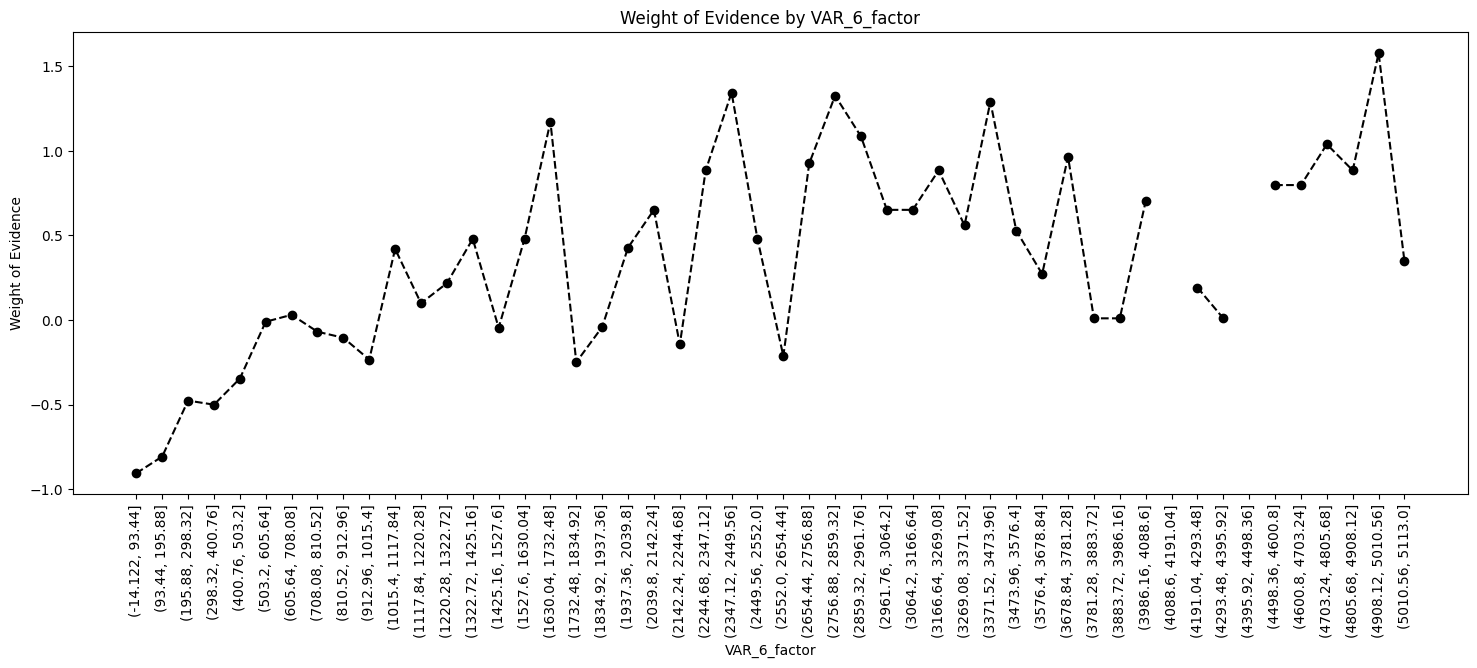

In [55]:
# Fine classing - VAR_6
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_6'])]
df_inputs_prepr_temp[f'VAR_6_factor'] = pd.cut(df_inputs_prepr_temp['VAR_6'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_6_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

VAR_6_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0     (-14.122, 93.44]    3     3      6  0.002812  0.004886  0.001974   
1      (93.44, 195.88]   29    32     61  0.028585  0.047231  0.021053   
2     (195.88, 298.32]   82   126    208  0.097470  0.133550  0.082895   
3     (298.32, 400.76]   74   111    185  0.086692  0.120521  0.073026   
4      (400.76, 503.2]   60   105    165  0.077320  0.097720  0.069079   
5      (503.2, 605.64]   40    98    138  0.064667  0.065147  0.064474   
6     (605.64, 708.08]   38    97    135  0.063261  0.061889  0.063816   
7     (708.08, 810.52]   42    97    139  0.065136  0.068404  0.063816   
8     (810.52, 912.96]   35    78    113  0.052952  0.057003  0.051316   
9     (912.96, 1015.4]   24    47     71  0.033271  0.039088  0.030921   
10   (1015.4, 1117.84]   13    49     62  0.029053  0.021173  0.032237   
11  (1117.84, 1220.28]   15    41     56  0.026242  0.024430  0.026974   
12  (1220.28, 1322.72]   13    40     53  0.024836  0.021173  0.026316   
13  (1322.72, 1425.16]    8    32     40  0.018744  0.013029  0.021053   
14   (1425.16, 1527.6]   11    26     37  0.017338  0.017915  0.017105   
15   (1527.6, 1630.04]    8    32     40  0.018744  0.013029  0.021053   
16  (1630.04, 1732.48]    3    24     27  0.012652  0.004886  0.015789   
17  (1732.48, 1834.92]   14    27     41  0.019213  0.022801  0.017763   
18  (1834.92, 1937.36]    8    19     27  0.012652  0.013029  0.012500   
19   (1937.36, 2039.8]    5    19     24  0.011246  0.008143  0.012500   
20   (2039.8, 2142.24]    4    19     23  0.010778  0.006515  0.012500   
21  (2142.24, 2244.68]    7    15     22  0.010309  0.011401  0.009868   
22  (2244.68, 2347.12]    3    18     21  0.009841  0.004886  0.011842   
23  (2347.12, 2449.56]    2    19     21  0.009841  0.003257  0.012500   
24   (2449.56, 2552.0]    4    16     20  0.009372  0.006515  0.010526   
25   (2552.0, 2654.44]   11    22     33  0.015464  0.017915  0.014474   
26  (2654.44, 2756.88]    4    25     29  0.013590  0.006515  0.016447   
27  (2756.88, 2859.32]    3    28     31  0.014527  0.004886  0.018421   
28  (2859.32, 2961.76]    3    22     25  0.011715  0.004886  0.014474   
29   (2961.76, 3064.2]    4    19     23  0.010778  0.006515  0.012500   
30   (3064.2, 3166.64]    4    19     23  0.010778  0.006515  0.012500   
31  (3166.64, 3269.08]    2    12     14  0.006560  0.003257  0.007895   
32  (3269.08, 3371.52]    3    13     16  0.007498  0.004886  0.008553   
33  (3371.52, 3473.96]    2    18     20  0.009372  0.003257  0.011842   
34   (3473.96, 3576.4]    5    21     26  0.012184  0.008143  0.013816   
35   (3576.4, 3678.84]    4    13     17  0.007966  0.006515  0.008553   
36  (3678.84, 3781.28]    2    13     15  0.007029  0.003257  0.008553   
37  (3781.28, 3883.72]    4    10     14  0.006560  0.006515  0.006579   
38  (3883.72, 3986.16]    2     5      7  0.003280  0.003257  0.003289   
39   (3986.16, 4088.6]    1     5      6  0.002812  0.001629  0.003289   
40   (4088.6, 4191.04]    0     6      6  0.002812  0.000000  0.003947   
41  (4191.04, 4293.48]    3     9     12  0.005623  0.004886  0.005921   
42  (4293.48, 4395.92]    2     5      7  0.003280  0.003257  0.003289   
43  (4395.92, 4498.36]    0     5      5  0.002343  0.000000  0.003289   
44   (4498.36, 4600.8]    2    11     13  0.006092  0.003257  0.007237   
45   (4600.8, 4703.24]    2    11     13  0.006092  0.003257  0.007237   
46  (4703.24, 4805.68]    1     7      8  0.003749  0.001629  0.004605   
47  (4805.68, 4908.12]    2    12     14  0.006560  0.003257  0.007895   
48  (4908.12, 5010.56]    1    12     13  0.006092  0.001629  0.007895   
49   (5010.56, 5113.0]    2     7      9  0.004217  0.003257  0.004605   

    DefaultRate       WoE  diff_WoE   IV  
0      0.500000 -0.906471       NaN  inf  
1      0.475410 -0.808031  0.098440  inf  
2      0.394231 -0.476908  0.331123  inf  
3      0.400000 -0.501006  0.024098  inf  
4      0.363636 -0.3

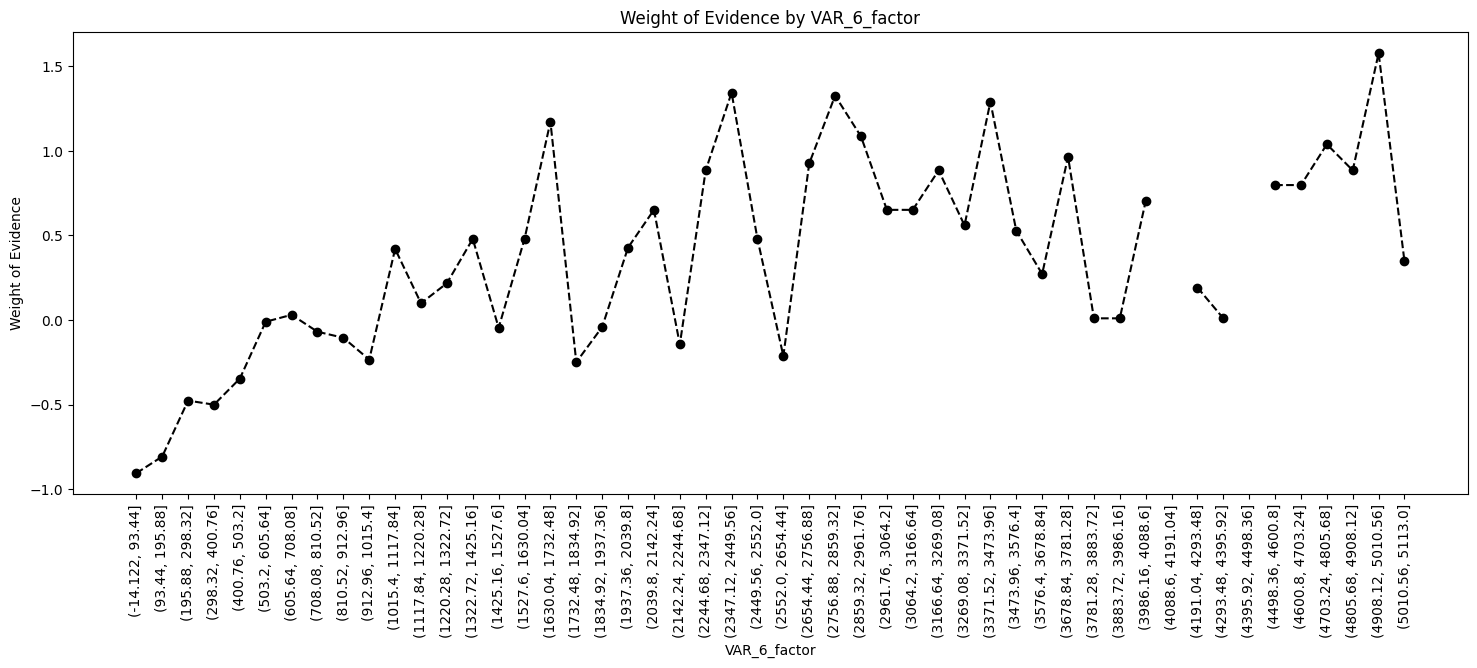

In [56]:
# Fine classing - VAR_6
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_6'])]
df_inputs_prepr_temp = df_inputs_prepr_temp[df_inputs_prepr_temp['VAR_6'] <= 8565.78]
df_inputs_prepr_temp[f'VAR_6_factor'] = pd.cut(df_inputs_prepr_temp['VAR_6'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_6_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [57]:
df_inputs_prepr[df_inputs_prepr['VAR_6'] >  8565.78]

Empty DataFrame
Columns: [Unnamed: 0, id, safra, y, VAR_1, VAR_2, VAR_3, VAR_4, VAR_6, VAR_7, VAR_8, VAR_9, VAR_11, VAR_15, VAR_17, VAR_20, VAR_22, VAR_28, VAR_30, VAR_32, VAR_33, VAR_34, VAR_35, VAR_38, VAR_45, VAR_52, VAR_53, VAR_54, VAR_58, VAR_59, VAR_60, VAR_64, VAR_65, VAR_72, VAR_76, safra_dt, months_since_cr_line, VAR_2:0, VAR_2:1-14_or_missing, VAR_3:Missing, VAR_3:0, VAR_3:1-10, VAR_4:Missing, VAR_4:0, VAR_4:1-14, VAR_20:3-10, VAR_20:11-12, VAR_28:Missing, VAR_28:0_8, VAR_28:1-7_9-12, VAR_32:<0.13, VAR_32:>=0.13, VAR_33:0, VAR_33:>0_or_missing, VAR_60:<-.025, VAR_60:-0.25to-0.004, VAR_60:>-0.004, VAR_64:0, VAR_64:1, months_since_cr_line:37-38, months_since_cr_line:39, months_since_cr_line:40, months_since_cr_line:41-46, months_since_cr_line:47-48, VAR_1:<=4.16, VAR_1:4.16-66.56, VAR_1:66.56-128.96, VAR_1:>128.96_or_missing]
Index: []

[0 rows x 68 columns]

In [58]:
df_inputs_prepr['VAR_6'].isnull().sum()

14

In [59]:
# VAR_6
df_inputs_prepr['VAR_6:<=12_or_missing'] = np.where((df_inputs_prepr['VAR_6']<=12) | (df_inputs_prepr['VAR_6'].isnull()), 1, 0)
df_inputs_prepr['VAR_6:12-751.44'] = np.where((df_inputs_prepr['VAR_6']>12) & (df_inputs_prepr['VAR_6']<=751.44), 1, 0)
df_inputs_prepr['VAR_6:751.44-4555.92'] = np.where((df_inputs_prepr['VAR_6']>751.44) & (df_inputs_prepr['VAR_6']<=4555.92), 1, 0)
df_inputs_prepr['VAR_6:>4555.92'] = np.where((df_inputs_prepr['VAR_6']>4555.92), 1, 0)

/tmp/ipykernel_11938/4237567987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_7_factor'] = pd.cut(df_inputs_prepr_temp['VAR_7'],50)


VAR_7_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (0.199, 15.761]   28    49     77  0.062449  0.074468  0.057176   
1     (15.761, 30.583]   62   174    236  0.191403  0.164894  0.203034   
2     (30.583, 45.404]   56   142    198  0.160584  0.148936  0.165694   
3     (45.404, 60.226]   64   118    182  0.147607  0.170213  0.137690   
4     (60.226, 75.047]   39   108    147  0.119221  0.103723  0.126021   
5     (75.047, 89.868]   44    74    118  0.095702  0.117021  0.086348   
6     (89.868, 104.69]   31    41     72  0.058394  0.082447  0.047841   
7    (104.69, 119.511]    9    32     41  0.033252  0.023936  0.037340   
8   (119.511, 134.333]   12    27     39  0.031630  0.031915  0.031505   
9   (134.333, 149.154]    5    12     17  0.013788  0.013298  0.014002   
10  (149.154, 163.975]    9    24     33  0.026764  0.023936  0.028005   
11  (163.975, 178.797]    2    14     16  0.012976  0.005319  0.016336   
12  (178.797, 193.618]    3     8     11  0.008921  0.007979  0.009335   
13   (193.618, 208.44]    6     2      8  0.006488  0.015957  0.002334   
14   (208.44, 223.261]    0     9      9  0.007299  0.000000  0.010502   
15  (223.261, 238.082]    0     4      4  0.003244  0.000000  0.004667   
16  (238.082, 252.904]    1     5      6  0.004866  0.002660  0.005834   
17  (252.904, 267.725]    2     2      4  0.003244  0.005319  0.002334   
18  (267.725, 282.547]    1     2      3  0.002433  0.002660  0.002334   
19  (282.547, 297.368]    2     1      3  0.002433  0.005319  0.001167   
20  (297.368, 312.189]    0     2      2  0.001622  0.000000  0.002334   
21  (312.189, 327.011]    0     2      2  0.001622  0.000000  0.002334   
22  (327.011, 341.832]    0     1      1  0.000811  0.000000  0.001167   
23  (356.654, 371.475]    0     1      1  0.000811  0.000000  0.001167   
24  (430.761, 445.582]    0     2      2  0.001622  0.000000  0.002334   
25   (727.189, 742.01]    0     1      1  0.000811  0.000000  0.001167   

    DefaultRate       WoE  diff_WoE   IV  
0      0.363636 -0.264233       NaN  inf  
1      0.262712  0.208072  0.472305  inf  
2      0.282828  0.106627  0.101446  inf  
3      0.351648 -0.212047  0.318674  inf  
4      0.265306  0.194721  0.406768  inf  
5      0.372881 -0.303973  0.498694  inf  
6      0.430556 -0.544264  0.240291  inf  
7      0.219512  0.444663  0.988926  inf  
8      0.307692 -0.012919  0.457581  inf  
9      0.294118  0.051620  0.064539  inf  
10     0.272727  0.156980  0.105361  inf  
11     0.125000  1.122061  0.965081  inf  
12     0.272727  0.156980  0.965081  inf  
13     0.750000 -1.922461  2.079442  inf  
14     0.000000       inf       inf  inf  
15     0.000000       inf       NaN  inf  
16     0.166667  0.785589       inf  inf  
17     0.500000 -0.823849  1.609438  inf  
18     0.333333 -0.130702  0.693147  inf  
19     0.666667 -1.516996  1.386294  inf  
20     0.000000       inf       inf  inf  
21     0.000000       inf       NaN  inf  
22     0.000000       inf       NaN  inf  
23     0.000000       inf       NaN  inf  
24     0.000000       inf       NaN  inf  
25     0.000000       inf       NaN  inf

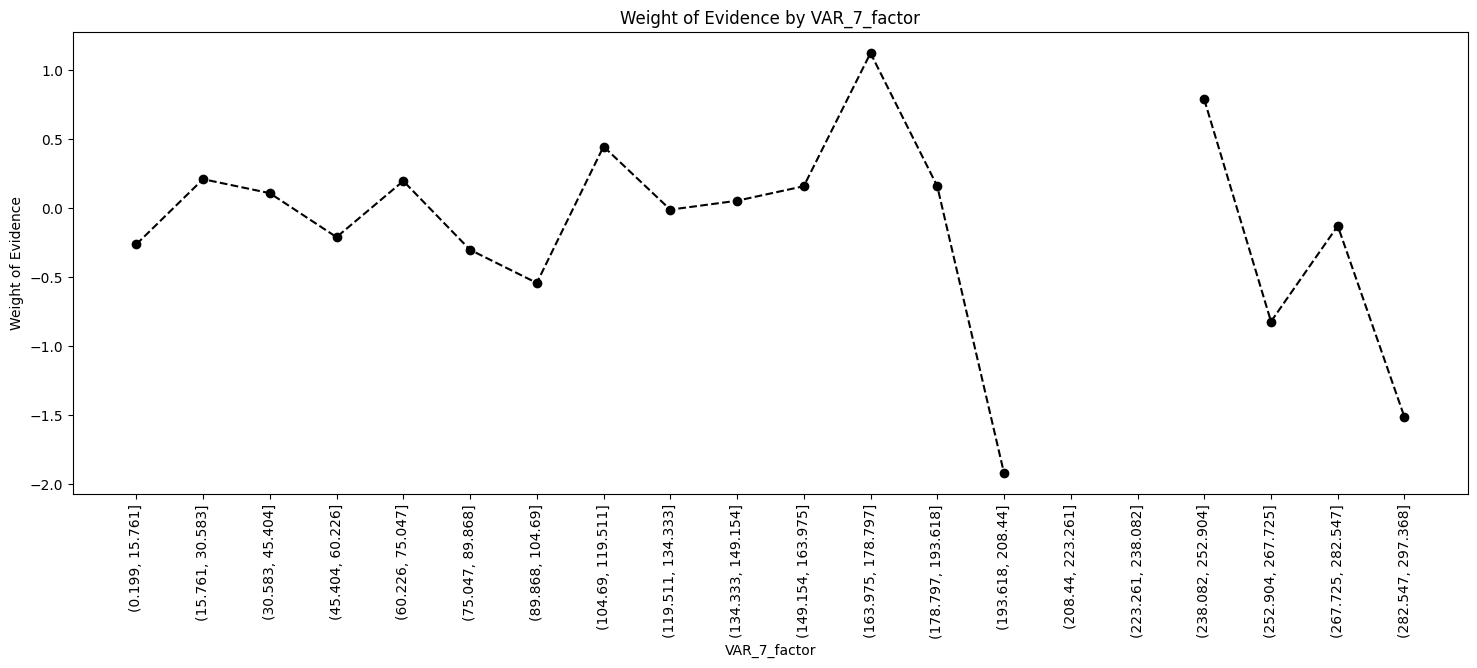

In [60]:
# Fine classing - VAR_7
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_7'])]
df_inputs_prepr_temp[f'VAR_7_factor'] = pd.cut(df_inputs_prepr_temp['VAR_7'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_7_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [61]:
df_inputs_prepr['VAR_7'].isnull().sum()

915

In [62]:
# VAR_7
df_inputs_prepr['VAR_7:Missing'] = np.where((df_inputs_prepr['VAR_7'].isnull()), 1, 0)
df_inputs_prepr['VAR_7:<=62.138'] = np.where((df_inputs_prepr['VAR_7']<=62.138), 1, 0)
df_inputs_prepr['VAR_7:>62.138'] = np.where((df_inputs_prepr['VAR_7']>62.138), 1, 0)

/tmp/ipykernel_11938/188741334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_8_factor'] = pd.cut(df_inputs_prepr_temp['VAR_8'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_8_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0     (-1.911, 58.795]  184   486    670  0.552805  0.527221  0.563152   
1     (58.795, 116.61]  102   253    355  0.292904  0.292264  0.293163   
2    (116.61, 174.425]   38    78    116  0.095710  0.108883  0.090382   
3    (174.425, 232.24]   18    27     45  0.037129  0.051576  0.031286   
4    (232.24, 290.055]    5    13     18  0.014851  0.014327  0.015064   
5    (290.055, 347.87]    0     4      4  0.003300  0.000000  0.004635   
6    (347.87, 405.685]    0     1      1  0.000825  0.000000  0.001159   
7     (463.5, 521.315]    2     0      2  0.001650  0.005731  0.000000   
8  (2833.915, 2891.73]    0     1      1  0.000825  0.000000  0.001159   

   DefaultRate       WoE  diff_WoE   IV  
0     0.274627  0.065930       NaN  inf  
1     0.287324  0.003074  0.062856  inf  
2     0.327586 -0.186220  0.189294  inf  
3     0.400000 -0.499878  0.313658  inf  
4     0.277778  0.050169  0.550046  inf  
5     0.000000       inf       inf  inf  
6     0.000000       inf       NaN  inf  
7     1.000000      -inf       inf  inf  
8     0.000000       inf       inf  inf

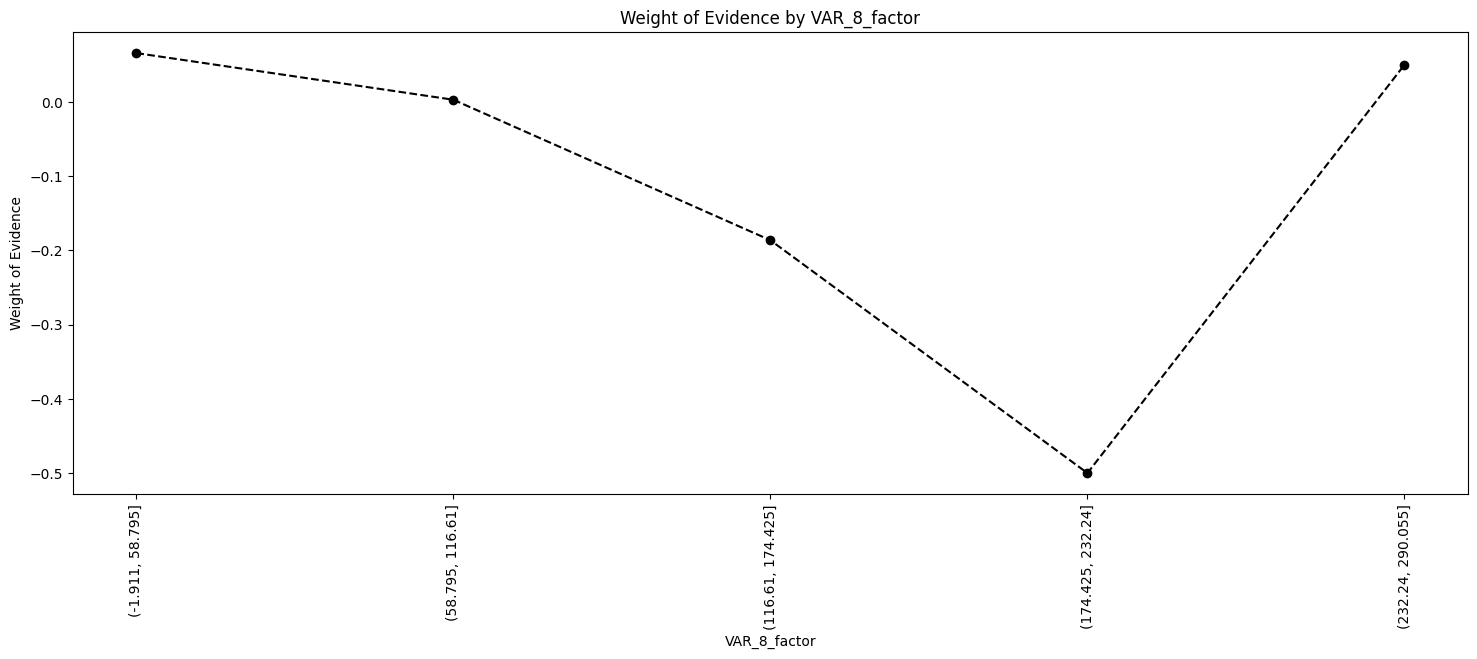

In [63]:
# Fine classing - VAR_8
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_8'])]
df_inputs_prepr_temp[f'VAR_8_factor'] = pd.cut(df_inputs_prepr_temp['VAR_8'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_8_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [64]:
df_inputs_prepr['VAR_8'].isnull().sum()

936

VAR_9_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0    (147.15, 207.0]    4    37     41  0.019088  0.006462  0.024199   
1     (207.0, 264.0]    2    12     14  0.006518  0.003231  0.007848   
2     (264.0, 321.0]    9    55     64  0.029795  0.014540  0.035971   
3     (321.0, 378.0]    5    21     26  0.012104  0.008078  0.013734   
4     (378.0, 435.0]   12    52     64  0.029795  0.019386  0.034009   
5     (435.0, 492.0]    4    10     14  0.006518  0.006462  0.006540   
6     (492.0, 549.0]   37   145    182  0.084730  0.059774  0.094833   
7     (549.0, 606.0]   22    81    103  0.047952  0.035541  0.052976   
8     (606.0, 663.0]    5     8     13  0.006052  0.008078  0.005232   
9     (663.0, 720.0]   17    56     73  0.033985  0.027464  0.036625   
10    (720.0, 777.0]    6     8     14  0.006518  0.009693  0.005232   
11    (777.0, 834.0]   24    65     89  0.041434  0.038772  0.042511   
12    (834.0, 891.0]    7    17     24  0.011173  0.011309  0.011118   
13    (891.0, 948.0]   15    33     48  0.022346  0.024233  0.021583   
14   (948.0, 1005.0]  122   355    477  0.222067  0.197092  0.232178   
15  (1005.0, 1062.0]    5     9     14  0.006518  0.008078  0.005886   
16  (1062.0, 1119.0]   15    20     35  0.016294  0.024233  0.013080   
17  (1119.0, 1176.0]    3    13     16  0.007449  0.004847  0.008502   
18  (1176.0, 1233.0]   22    47     69  0.032123  0.035541  0.030739   
19  (1233.0, 1290.0]    3    13     16  0.007449  0.004847  0.008502   
20  (1290.0, 1347.0]   15    28     43  0.020019  0.024233  0.018313   
21  (1347.0, 1404.0]    8    23     31  0.014432  0.012924  0.015043   
22  (1404.0, 1461.0]    8     7     15  0.006983  0.012924  0.004578   
23  (1461.0, 1518.0]   62   121    183  0.085196  0.100162  0.079137   
24  (1518.0, 1575.0]    3     3      6  0.002793  0.004847  0.001962   
25  (1575.0, 1632.0]   12    15     27  0.012570  0.019386  0.009810   
26  (1632.0, 1689.0]    7     6     13  0.006052  0.011309  0.003924   
27  (1689.0, 1746.0]    9    22     31  0.014432  0.014540  0.014388   
28  (1746.0, 1803.0]    3    10     13  0.006052  0.004847  0.006540   
29  (1803.0, 1860.0]    2     5      7  0.003259  0.003231  0.003270   
30  (1860.0, 1917.0]    8    12     20  0.009311  0.012924  0.007848   
31  (1917.0, 1974.0]    6     6     12  0.005587  0.009693  0.003924   
32  (1974.0, 2031.0]   60   110    170  0.079143  0.096931  0.071942   
33  (2031.0, 2088.0]    4     8     12  0.005587  0.006462  0.005232   
34  (2088.0, 2145.0]    3     6      9  0.004190  0.004847  0.003924   
35  (2145.0, 2202.0]    5     3      8  0.003724  0.008078  0.001962   
36  (2202.0, 2259.0]    6     4     10  0.004655  0.009693  0.002616   
37  (2259.0, 2316.0]    6     9     15  0.006983  0.009693  0.005886   
38  (2316.0, 2373.0]    3     3      6  0.002793  0.004847  0.001962   
39  (2373.0, 2430.0]    2     2      4  0.001862  0.003231  0.001308   
40  (2430.0, 2487.0]    5     2      7  0.003259  0.008078  0.001308   
41  (2487.0, 2544.0]    8    11     19  0.008845  0.012924  0.007194   
42  (2544.0, 2601.0]    4     5      9  0.004190  0.006462  0.003270   
43  (2601.0, 2658.0]    5     1      6  0.002793  0.008078  0.000654   
44  (2658.0, 2715.0]    2     1      3  0.001397  0.003231  0.000654   
45  (2715.0, 2772.0]    3     1      4  0.001862  0.004847  0.000654   
46  (2772.0, 2829.0]    1     2      3  0.001397  0.001616  0.001308   
47  (2829.0, 2886.0]    2     2      4  0.001862  0.003231  0.001308   
48  (2886.0, 2943.0]    1     4      5  0.002328  0.001616  0.002616   
49  (2943.0, 3000.0]   17    40     57  0.026536  0.027464  0.026161   

    DefaultRate       WoE  diff_WoE        IV  
0      0.097561  1.320360       NaN  0.230947  
1      0.142857  0.887496  0.432864  0.230947  
2      0.140625  0.905845  0.018349  0.230947  
3      0.192308  0.530821  0.375024  0.230947  
4      0.187500  0.562073  0.031253  0.230947  
5      0.285714  0.012027  0.550046  0.230947  

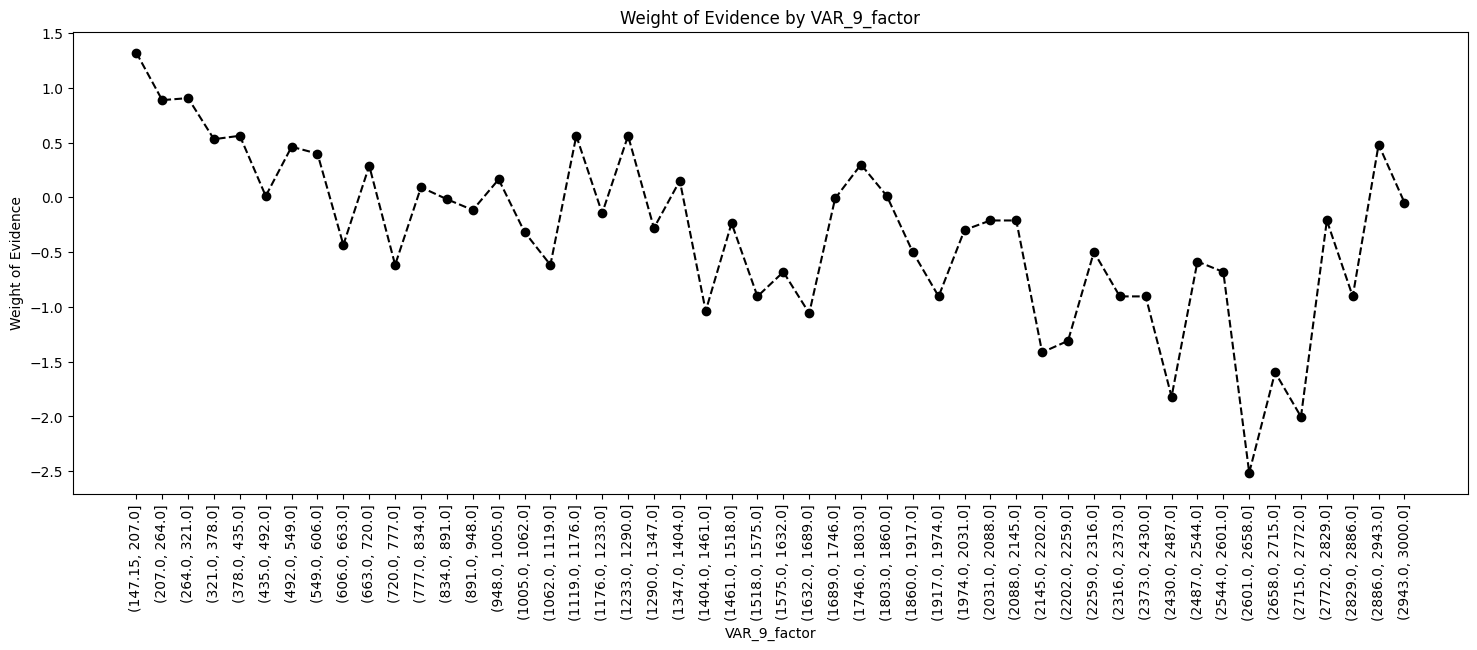

In [65]:
# Fine classing - VAR_9
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_9'])]
df_inputs_prepr_temp[f'VAR_9_factor'] = pd.cut(df_inputs_prepr_temp['VAR_9'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_9_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [66]:
df_inputs_prepr['VAR_9'].isnull().sum()

0

In [67]:
# VAR_9
df_inputs_prepr['VAR_9:<=606.0'] = np.where((df_inputs_prepr['VAR_9']<=606.0), 1, 0)
df_inputs_prepr['VAR_9:>606.0'] = np.where((df_inputs_prepr['VAR_9']>606.0), 1, 0)

/tmp/ipykernel_11938/3653224914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_11_factor'] = pd.cut(df_inputs_prepr_temp['VAR_11'],50)


VAR_11_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (-1.643, 33.069]   83   250    333  0.278428  0.228650  0.300120   
1      (33.069, 66.127]  143   252    395  0.330268  0.393939  0.302521   
2      (66.127, 99.186]   72   153    225  0.188127  0.198347  0.183673   
3     (99.186, 132.244]   33    74    107  0.089465  0.090909  0.088836   
4    (132.244, 165.303]   14    45     59  0.049331  0.038567  0.054022   
5    (165.303, 198.362]    7    26     33  0.027592  0.019284  0.031212   
6     (198.362, 231.42]    5    10     15  0.012542  0.013774  0.012005   
7     (231.42, 264.479]    1     9     10  0.008361  0.002755  0.010804   
8    (264.479, 297.537]    3     7     10  0.008361  0.008264  0.008403   
9    (297.537, 330.596]    1     1      2  0.001672  0.002755  0.001200   
10   (330.596, 363.655]    0     2      2  0.001672  0.000000  0.002401   
11   (363.655, 396.713]    1     1      2  0.001672  0.002755  0.001200   
12   (396.713, 429.772]    0     1      1  0.000836  0.000000  0.001200   
13   (661.182, 694.241]    0     1      1  0.000836  0.000000  0.001200   
14  (1619.881, 1652.94]    0     1      1  0.000836  0.000000  0.001200   

    DefaultRate       WoE  diff_WoE   IV  
0      0.249249  0.271990       NaN  inf  
1      0.362025 -0.264046  0.536036  inf  
2      0.320000 -0.076859  0.187187  inf  
3      0.308411 -0.023073  0.053786  inf  
4      0.237288  0.336974  0.360048  inf  
5      0.212121  0.481556  0.144581  inf  
6      0.333333 -0.137484  0.619039  inf  
7      0.100000  1.366594  1.504077  inf  
8      0.300000  0.016667  1.349927  inf  
9      0.500000 -0.830631  0.847298  inf  
10     0.000000       inf       inf  inf  
11     0.500000 -0.830631       inf  inf  
12     0.000000       inf       inf  inf  
13     0.000000       inf       NaN  inf  
14     0.000000       inf       NaN  inf

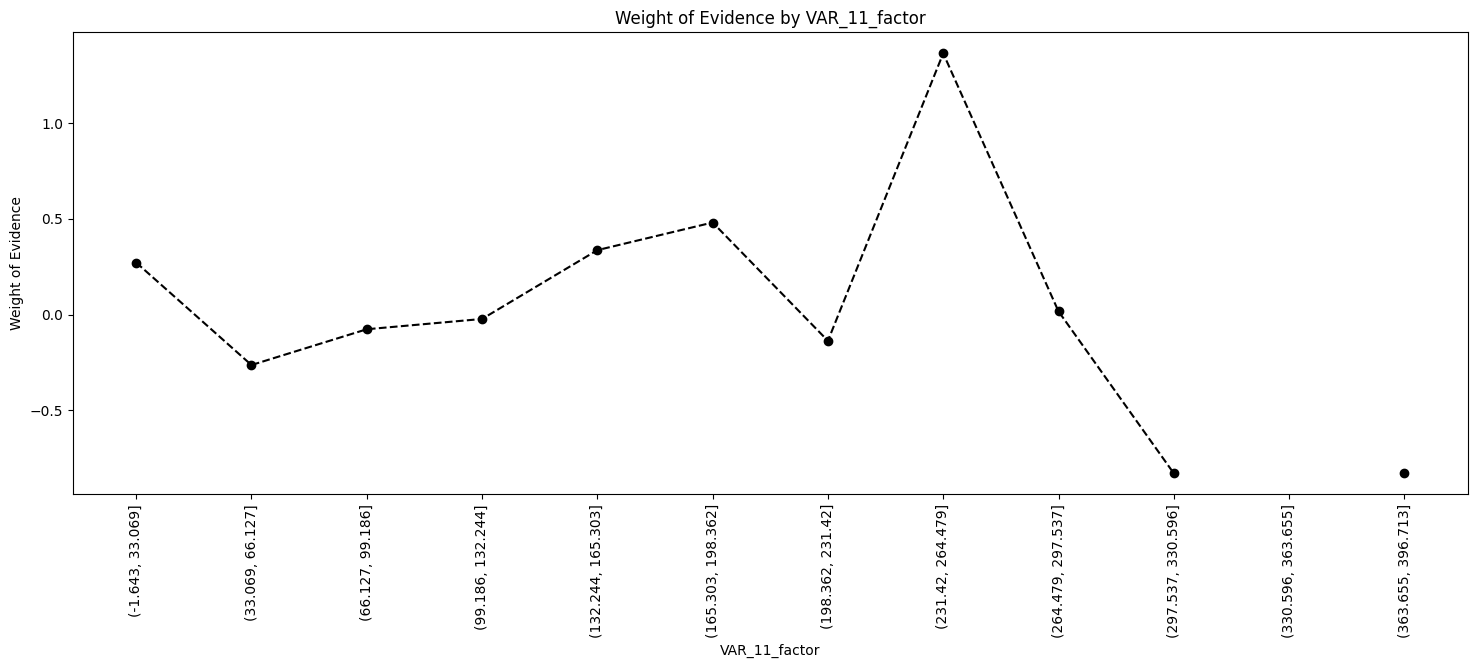

In [68]:
# Fine classing - VAR_11
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_11'])]
df_inputs_prepr_temp[f'VAR_11_factor'] = pd.cut(df_inputs_prepr_temp['VAR_11'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_11_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [69]:
df_inputs_prepr['VAR_11'].isnull().sum()

952

In [70]:
# VAR_11
df_inputs_prepr['VAR_11:Missing'] = np.where((df_inputs_prepr['VAR_11'].isnull()), 1, 0)
df_inputs_prepr['VAR_11:<=108.024'] = np.where((df_inputs_prepr['VAR_11']<=108.024), 1, 0)
df_inputs_prepr['VAR_11:>108.024'] = np.where((df_inputs_prepr['VAR_11']>108.024), 1, 0)

/tmp/ipykernel_11938/635661139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_15_factor'] = pd.cut(df_inputs_prepr_temp['VAR_15'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_15_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (0.0842, 8.816]    1    12     13  0.011130  0.002882  0.014616   
1      (8.816, 17.132]   19    52     71  0.060788  0.054755  0.063337   
2     (17.132, 25.449]   37   107    144  0.123288  0.106628  0.130329   
3     (25.449, 33.765]   41    89    130  0.111301  0.118156  0.108404   
4     (33.765, 42.081]   32    90    122  0.104452  0.092219  0.109622   
5     (42.081, 50.397]   39    85    124  0.106164  0.112392  0.103532   
6     (50.397, 58.713]   29    52     81  0.069349  0.083573  0.063337   
7      (58.713, 67.03]   24    57     81  0.069349  0.069164  0.069428   
8      (67.03, 75.346]   18    49     67  0.057363  0.051873  0.059683   
9     (75.346, 83.662]   18    38     56  0.047945  0.051873  0.046285   
10    (83.662, 91.978]   11    29     40  0.034247  0.031700  0.035323   
11   (91.978, 100.294]   15    20     35  0.029966  0.043228  0.024361   
12  (100.294, 108.611]   17    23     40  0.034247  0.048991  0.028015   
13  (108.611, 116.927]    4    21     25  0.021404  0.011527  0.025579   
14  (116.927, 125.243]    9    12     21  0.017979  0.025937  0.014616   
15  (125.243, 133.559]    6    13     19  0.016267  0.017291  0.015834   
16  (133.559, 141.875]    1    14     15  0.012842  0.002882  0.017052   
17  (141.875, 150.192]    2     9     11  0.009418  0.005764  0.010962   
18  (150.192, 158.508]    5     4      9  0.007705  0.014409  0.004872   
19  (158.508, 166.824]    3     9     12  0.010274  0.008646  0.010962   
20   (166.824, 175.14]    3     6      9  0.007705  0.008646  0.007308   
21   (175.14, 183.456]    2     2      4  0.003425  0.005764  0.002436   
22  (183.456, 191.773]    0     3      3  0.002568  0.000000  0.003654   
23  (191.773, 200.089]    0     3      3  0.002568  0.000000  0.003654   
24  (200.089, 208.405]    1     3      4  0.003425  0.002882  0.003654   
25  (208.405, 216.721]    2     4      6  0.005137  0.005764  0.004872   
26  (216.721, 225.037]    1     3      4  0.003425  0.002882  0.003654   
27  (225.037, 233.354]    0     1      1  0.000856  0.000000  0.001218   
28   (233.354, 241.67]    0     1      1  0.000856  0.000000  0.001218   
29   (241.67, 249.986]    0     2      2  0.001712  0.000000  0.002436   
30  (258.302, 266.618]    1     1      2  0.001712  0.002882  0.001218   
31  (266.618, 274.935]    2     2      4  0.003425  0.005764  0.002436   
32  (274.935, 283.251]    2     0      2  0.001712  0.005764  0.000000   
33  (283.251, 291.567]    0     1      1  0.000856  0.000000  0.001218   
34  (299.883, 308.199]    1     0      1  0.000856  0.002882  0.000000   
35   (349.78, 358.097]    1     2      3  0.002568  0.002882  0.002436   
36   (407.994, 416.31]    0     2      2  0.001712  0.000000  0.002436   

    DefaultRate       WoE  diff_WoE   IV  
0      0.076923  1.623708       NaN  inf  
1      0.267606  0.145606  1.478102  inf  
2      0.256944  0.200713  0.055106  inf  
3      0.315385 -0.086134  0.286847  inf  
4      0.262295  0.172875  0.259009  inf  
5      0.314516 -0.082109  0.254984  inf  
6      0.358025 -0.277250  0.195142  inf  
7      0.296296  0.003799  0.281050  inf  
8      0.268657  0.140250  0.136451  inf  
9      0.321429 -0.113984  0.254234  inf  
10     0.275000  0.108202  0.222186  inf  
11     0.428571 -0.573516  0.681718  inf  
12     0.425000 -0.558917  0.014599  inf  
13     0.160000  0.797030  1.355947  inf  
14     0.428571 -0.573516  1.370546  inf  
15     0.315789 -0.088008  0.485508  inf  
16     0.066667  1.777859  1.865867  inf  
17     0.181818  0.642879  1.134980  inf  
18     0.555556 -1.084342  1.727221  inf  
19     0.250000  0.237414  1.321756  inf  
20     0.333333 -0.168051  0.405465  inf  
21     0.500000 -0.861198  0.693147  inf  
22     0.000000       inf       inf  inf  
23     0.000000       inf       NaN  inf  
24     0.250000  0.237414       inf  inf  
25     0.333333 -0.168051  0.405465  inf  
26     0.250000  0.237414  0.405465

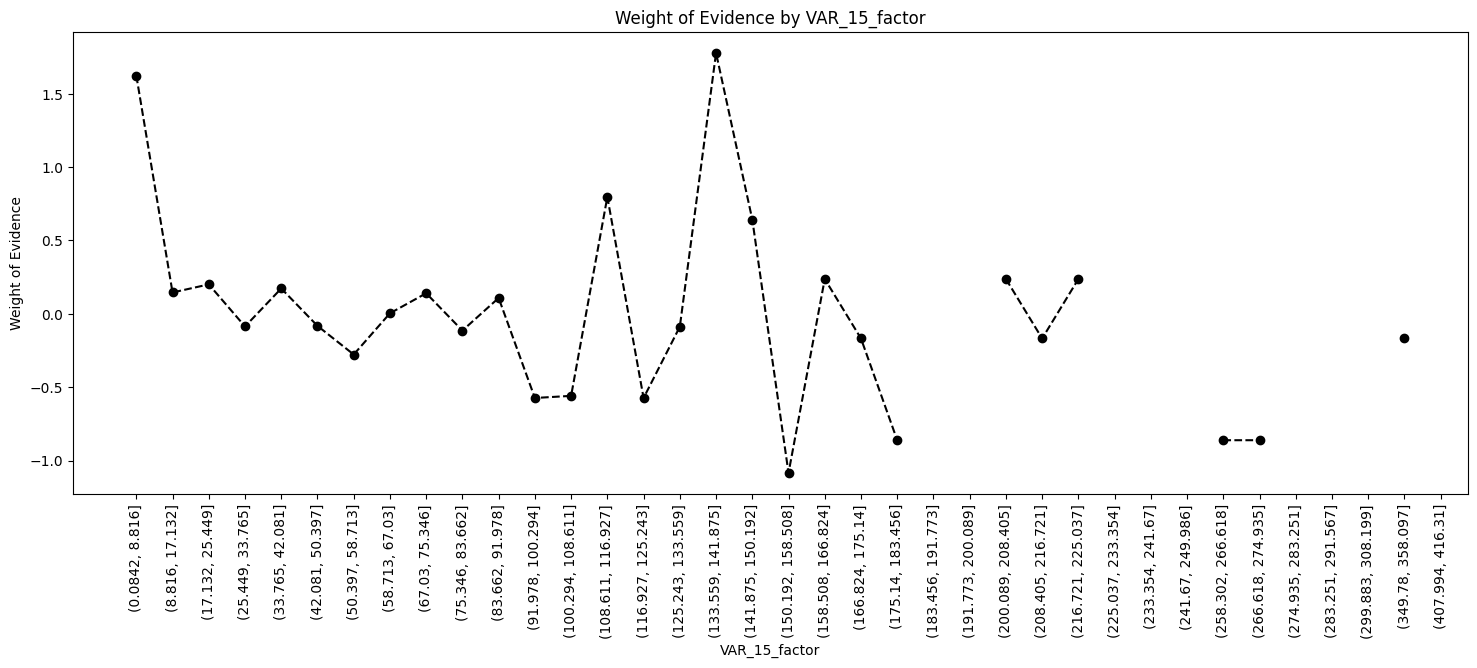

In [71]:
# Fine classing - VAR_15
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_15'])]
df_inputs_prepr_temp[f'VAR_15_factor'] = pd.cut(df_inputs_prepr_temp['VAR_15'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_15_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [72]:
df_inputs_prepr['VAR_15'].isnull().sum()

980

/tmp/ipykernel_11938/2010410734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_17_factor'] = pd.cut(df_inputs_prepr_temp['VAR_17'],50)


VAR_17_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0         (8.429, 377.427]   14    35     49  0.039902  0.048276  0.037313   
1       (377.427, 728.855]   45    98    143  0.116450  0.155172  0.104478   
2      (728.855, 1080.282]   50   140    190  0.154723  0.172414  0.149254   
3      (1080.282, 1431.71]   28    80    108  0.087948  0.096552  0.085288   
4      (1431.71, 1783.137]   32    94    126  0.102606  0.110345  0.100213   
5     (1783.137, 2134.564]   18    94    112  0.091205  0.062069  0.100213   
6     (2134.564, 2485.992]   14    45     59  0.048046  0.048276  0.047974   
7     (2485.992, 2837.419]   15    60     75  0.061075  0.051724  0.063966   
8     (2837.419, 3188.847]   17    65     82  0.066775  0.058621  0.069296   
9     (3188.847, 3540.274]   10    50     60  0.048860  0.034483  0.053305   
10    (3540.274, 3891.701]    7    13     20  0.016287  0.024138  0.013859   
11    (3891.701, 4243.129]    6    37     43  0.035016  0.020690  0.039446   
12    (4243.129, 4594.556]    6    17     23  0.018730  0.020690  0.018124   
13    (4594.556, 4945.984]    3    14     17  0.013844  0.010345  0.014925   
14    (4945.984, 5297.411]    1    20     21  0.017101  0.003448  0.021322   
15    (5297.411, 5648.838]    4     9     13  0.010586  0.013793  0.009595   
16    (5648.838, 6000.266]    5    11     16  0.013029  0.017241  0.011727   
17    (6000.266, 6351.693]    1     8      9  0.007329  0.003448  0.008529   
18    (6351.693, 6703.121]    1     5      6  0.004886  0.003448  0.005330   
19    (6703.121, 7054.548]    0     7      7  0.005700  0.000000  0.007463   
20    (7054.548, 7405.975]    2     3      5  0.004072  0.006897  0.003198   
21    (7405.975, 7757.403]    2     4      6  0.004886  0.006897  0.004264   
22     (7757.403, 8108.83]    4     5      9  0.007329  0.013793  0.005330   
23     (8108.83, 8460.258]    2     5      7  0.005700  0.006897  0.005330   
24    (8460.258, 8811.685]    1     2      3  0.002443  0.003448  0.002132   
25    (8811.685, 9163.112]    1     3      4  0.003257  0.003448  0.003198   
26   (9865.967, 10217.395]    0     1      1  0.000814  0.000000  0.001066   
27  (10217.395, 10568.822]    0     1      1  0.000814  0.000000  0.001066   
28  (10568.822, 10920.249]    1     2      3  0.002443  0.003448  0.002132   
29  (10920.249, 11271.677]    0     1      1  0.000814  0.000000  0.001066   
30  (11271.677, 11623.104]    0     1      1  0.000814  0.000000  0.001066   
31  (11623.104, 11974.532]    0     2      2  0.001629  0.000000  0.002132   
32  (11974.532, 12325.959]    0     2      2  0.001629  0.000000  0.002132   
33  (12677.386, 13028.814]    0     1      1  0.000814  0.000000  0.001066   
34  (13380.241, 13731.669]    0     1      1  0.000814  0.000000  0.001066   
35  (15137.378, 15488.806]    0     1      1  0.000814  0.000000  0.001066   
36   (17245.943, 17597.37]    0     1      1  0.000814  0.000000  0.001066   

    DefaultRate       WoE  diff_WoE   IV  
0      0.285714 -0.257578       NaN  inf  
1      0.314685 -0.395564  0.137986  inf  
2      0.263158 -0.144250  0.251314  inf  
3      0.259259 -0.124047  0.020203  inf  
4      0.253968 -0.096310  0.027737  inf  
5      0.160714  0.479054  0.575364  inf  
6      0.237288 -0.006264  0.485318  inf  
7      0.200000  0.212425  0.218689  inf  
8      0.207317  0.167305  0.045120  inf  
9      0.166667  0.435569  0.268264  inf  
10     0.350000 -0.554830  0.990399  inf  
11     0.139535  0.645289  1.200119  inf  
12     0.260870 -0.132415  0.777705  inf  
13     0.176471  0.366576  0.498991  inf  
14     0.047619  1.821863  1.455287  inf  
15     0.307692 -0.362939  2.184802  inf  
16     0.312500 -0.385412  0.022473  inf  
17     0.111111  0.905573  1.290984  inf  
18     0.166667  0.435569  0.470004  inf  
19     0.000000       inf       inf  inf  
20     0.400000 -0.768404       inf  inf  
21     0.333333 -0.480722  0.287682  inf  
22     0.444444 -0.950725  0.470004  inf  
23     0.285714 

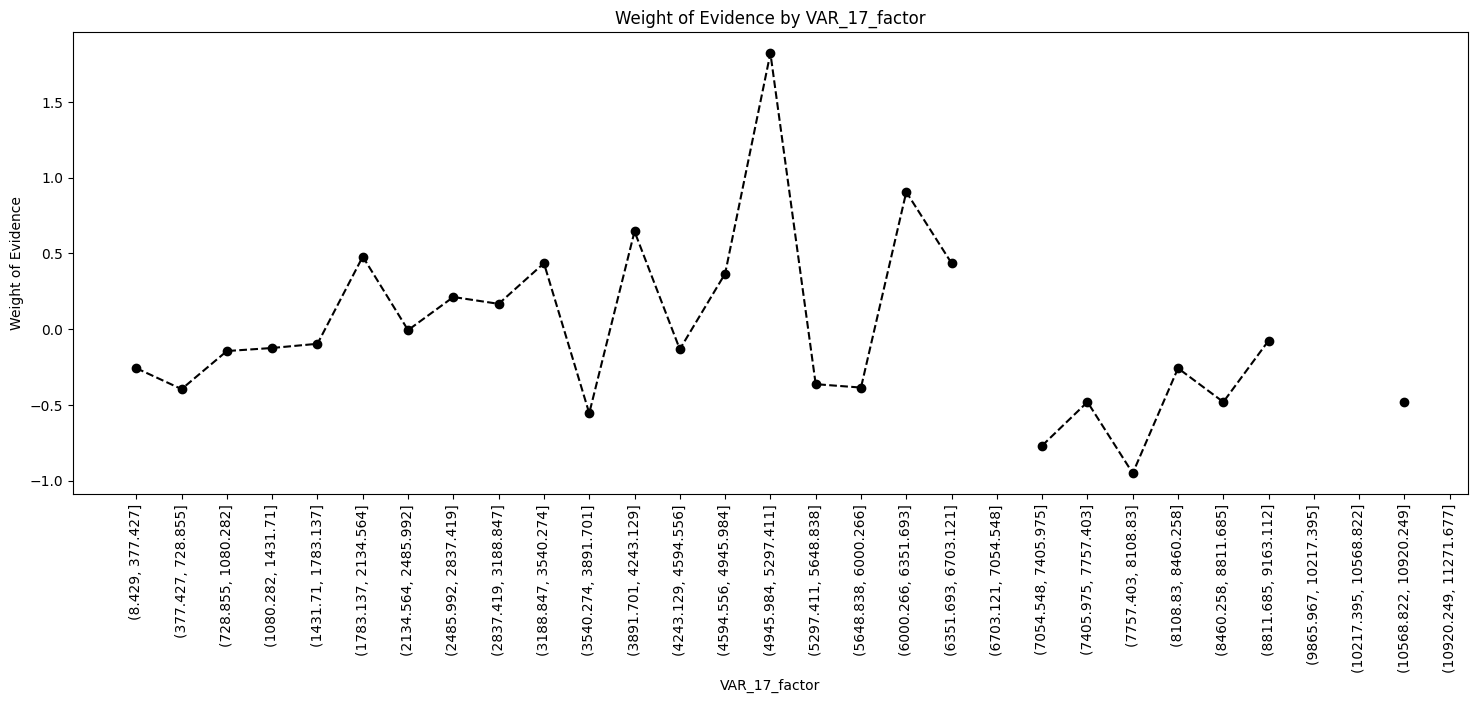

In [73]:
# Fine classing - VAR_17
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_17'])]
df_inputs_prepr_temp[f'VAR_17_factor'] = pd.cut(df_inputs_prepr_temp['VAR_17'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_17_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [74]:
df_inputs_prepr['VAR_17'].isnull().sum()

920

In [75]:
# VAR_17
df_inputs_prepr['VAR_17:Missing'] = np.where((df_inputs_prepr['VAR_17'].isnull()), 1, 0)
df_inputs_prepr['VAR_17:<=2833.422'] = np.where((df_inputs_prepr['VAR_17']<=2833.422), 1, 0)
df_inputs_prepr['VAR_17:>2833.422'] = np.where((df_inputs_prepr['VAR_17']>2833.422), 1, 0)

/tmp/ipykernel_11938/3449228002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_22_factor'] = pd.cut(df_inputs_prepr_temp['VAR_22'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_22_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0     (-0.117, 2.34]  490   983   1473  0.688318  0.795455  0.645013   
1       (2.34, 4.68]    5    30     35  0.016355  0.008117  0.019685   
2       (4.68, 7.02]   13    27     40  0.018692  0.021104  0.017717   
3       (7.02, 9.36]   11    30     41  0.019159  0.017857  0.019685   
4       (9.36, 11.7]    6    24     30  0.014019  0.009740  0.015748   
5      (11.7, 14.04]   22    33     55  0.025701  0.035714  0.021654   
6     (14.04, 16.38]    2    17     19  0.008879  0.003247  0.011155   
7     (16.38, 18.72]    6    22     28  0.013084  0.009740  0.014436   
8     (18.72, 21.06]    6    24     30  0.014019  0.009740  0.015748   
9      (21.06, 23.4]    5    23     28  0.013084  0.008117  0.015092   
10     (23.4, 25.74]    2    18     20  0.009346  0.003247  0.011811   
11    (25.74, 28.08]    4    21     25  0.011682  0.006494  0.013780   
12    (28.08, 30.42]    5    18     23  0.010748  0.008117  0.011811   
13    (30.42, 32.76]    2    17     19  0.008879  0.003247  0.011155   
14     (32.76, 35.1]    6    16     22  0.010280  0.009740  0.010499   
15     (35.1, 37.44]    1    17     18  0.008411  0.001623  0.011155   
16    (37.44, 39.78]    1    14     15  0.007009  0.001623  0.009186   
17    (39.78, 42.12]    2    20     22  0.010280  0.003247  0.013123   
18    (42.12, 44.46]    1     9     10  0.004673  0.001623  0.005906   
19     (44.46, 46.8]    1    17     18  0.008411  0.001623  0.011155   
20     (46.8, 49.14]    3    16     19  0.008879  0.004870  0.010499   
21    (49.14, 51.48]    2    14     16  0.007477  0.003247  0.009186   
22    (51.48, 53.82]    3     7     10  0.004673  0.004870  0.004593   
23    (53.82, 56.16]    2    12     14  0.006542  0.003247  0.007874   
24     (56.16, 58.5]    0     4      4  0.001869  0.000000  0.002625   
25     (58.5, 60.84]    1     8      9  0.004206  0.001623  0.005249   
26    (60.84, 63.18]    1     9     10  0.004673  0.001623  0.005906   
27    (63.18, 65.52]    2    12     14  0.006542  0.003247  0.007874   
28    (65.52, 67.86]    0     9      9  0.004206  0.000000  0.005906   
29     (67.86, 70.2]    2     2      4  0.001869  0.003247  0.001312   
30     (70.2, 72.54]    3     0      3  0.001402  0.004870  0.000000   
31    (72.54, 74.88]    0     5      5  0.002336  0.000000  0.003281   
32    (74.88, 77.22]    1     3      4  0.001869  0.001623  0.001969   
33    (77.22, 79.56]    1     4      5  0.002336  0.001623  0.002625   
34     (79.56, 81.9]    0     4      4  0.001869  0.000000  0.002625   
35     (81.9, 84.24]    0     5      5  0.002336  0.000000  0.003281   
36    (84.24, 86.58]    1     1      2  0.000935  0.001623  0.000656   
37    (86.58, 88.92]    0     1      1  0.000467  0.000000  0.000656   
38    (88.92, 91.26]    0     4      4  0.001869  0.000000  0.002625   
39     (91.26, 93.6]    1     2      3  0.001402  0.001623  0.001312   
40     (93.6, 95.94]    0     3      3  0.001402  0.000000  0.001969   
41    (95.94, 98.28]    1     4      5  0.002336  0.001623  0.002625   
42   (98.28, 100.62]    0     2      2  0.000935  0.000000  0.001312   
43  (100.62, 102.96]    0     2      2  0.000935  0.000000  0.001312   
44   (102.96, 105.3]    1     4      5  0.002336  0.001623  0.002625   
45   (105.3, 107.64]    0     2      2  0.000935  0.000000  0.001312   
46  (109.98, 112.32]    0     3      3  0.001402  0.000000  0.001969   
47  (112.32, 114.66]    0     1      1  0.000467  0.000000  0.000656   
48   (114.66, 117.0]    0     1      1  0.000467  0.000000  0.000656   

    DefaultRate       WoE  diff_WoE   IV  
0      0.332654 -0.209643       NaN  inf  
1      0.142857  0.885913  1.095556  inf  
2      0.325000 -0.174959  1.060872  inf  
3      0.268293  0.097455  0.272415  inf  
4      0.200000  0.480448  0.382992  inf  
5      0.400000 -0.500382  0.980829  inf  
6      0.105263  1.234219  1.734601  inf  
7      0.214286  0.393436  0.840783  inf  
8      0.200000  0.

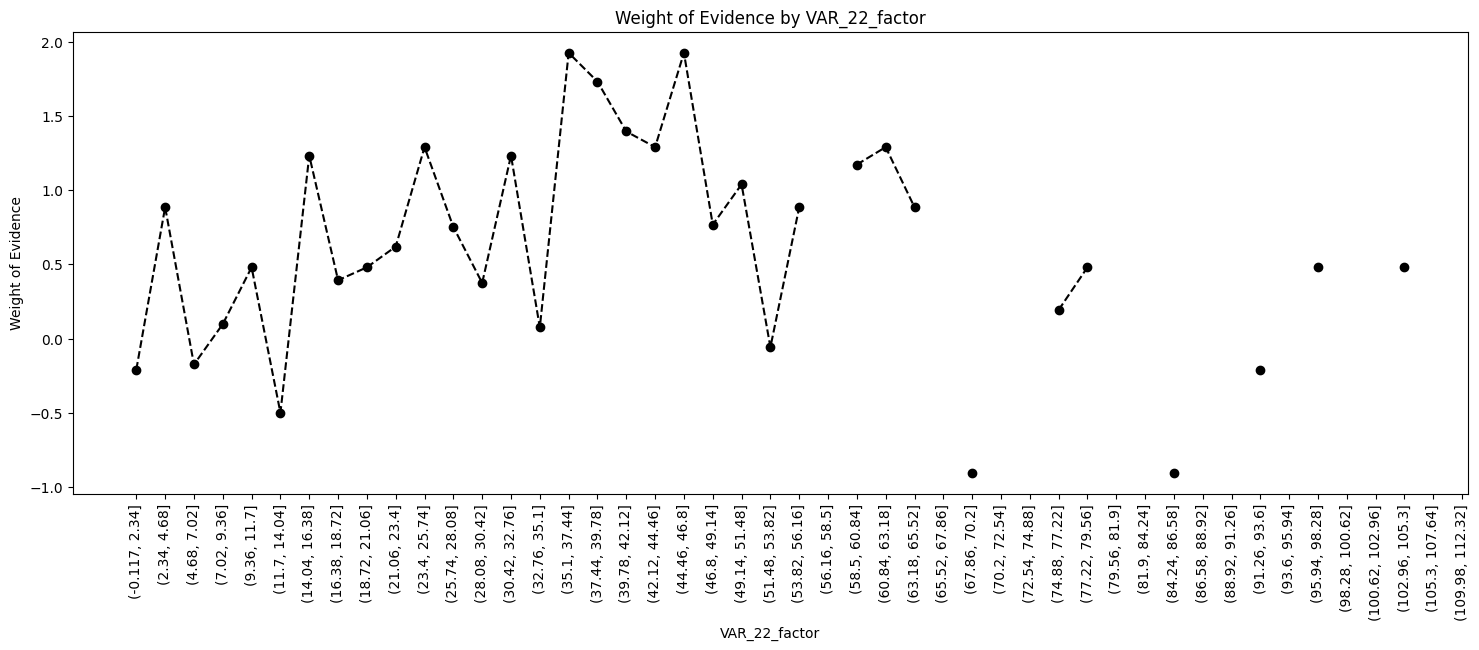

In [76]:
# Fine classing - VAR_22
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_22'])]
df_inputs_prepr_temp[f'VAR_22_factor'] = pd.cut(df_inputs_prepr_temp['VAR_22'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_22_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [77]:
df_inputs_prepr['VAR_22'].isnull().sum()

8

In [78]:
# VAR_22
df_inputs_prepr['VAR_22:<=2.44'] = np.where((df_inputs_prepr['VAR_22']<=2.44), 1, 0)
df_inputs_prepr['VAR_22:>2.44'] = np.where((df_inputs_prepr['VAR_22']>2.44), 1, 0)

/tmp/ipykernel_11938/3977216492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_34_factor'] = pd.cut(df_inputs_prepr_temp['VAR_34'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_34_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (-1.911, 58.795]   23   101    124  0.102310  0.065903  0.117034   
1      (58.795, 116.61]   58   151    209  0.172442  0.166189  0.174971   
2     (116.61, 174.425]   49   137    186  0.153465  0.140401  0.158749   
3     (174.425, 232.24]   44    96    140  0.115512  0.126074  0.111240   
4     (232.24, 290.055]   29    69     98  0.080858  0.083095  0.079954   
5     (290.055, 347.87]   26    75    101  0.083333  0.074499  0.086906   
6     (347.87, 405.685]   28    46     74  0.061056  0.080229  0.053302   
7      (405.685, 463.5]   17    39     56  0.046205  0.048711  0.045191   
8      (463.5, 521.315]   14    34     48  0.039604  0.040115  0.039397   
9     (521.315, 579.13]   11    20     31  0.025578  0.031519  0.023175   
10    (579.13, 636.945]    8    20     28  0.023102  0.022923  0.023175   
11    (636.945, 694.76]    3    20     23  0.018977  0.008596  0.023175   
12    (694.76, 752.575]    9    11     20  0.016502  0.025788  0.012746   
13    (752.575, 810.39]    2     7      9  0.007426  0.005731  0.008111   
14    (810.39, 868.205]    2     6      8  0.006601  0.005731  0.006952   
15    (868.205, 926.02]    3     3      6  0.004950  0.008596  0.003476   
16    (926.02, 983.835]    2     3      5  0.004125  0.005731  0.003476   
17   (983.835, 1041.65]    7     3     10  0.008251  0.020057  0.003476   
18  (1041.65, 1099.465]    3     3      6  0.004950  0.008596  0.003476   
19  (1099.465, 1157.28]    2     4      6  0.004950  0.005731  0.004635   
20  (1157.28, 1215.095]    2     2      4  0.003300  0.005731  0.002317   
21  (1215.095, 1272.91]    1     4      5  0.004125  0.002865  0.004635   
22  (1330.725, 1388.54]    1     0      1  0.000825  0.002865  0.000000   
23  (1446.355, 1504.17]    0     1      1  0.000825  0.000000  0.001159   
24  (1504.17, 1561.985]    1     0      1  0.000825  0.002865  0.000000   
25   (1561.985, 1619.8]    1     2      3  0.002475  0.002865  0.002317   
26  (1735.43, 1793.245]    0     2      2  0.001650  0.000000  0.002317   
27  (1793.245, 1851.06]    1     0      1  0.000825  0.002865  0.000000   
28  (1851.06, 1908.875]    1     0      1  0.000825  0.002865  0.000000   
29  (2024.505, 2082.32]    0     1      1  0.000825  0.000000  0.001159   
30  (2082.32, 2140.135]    0     1      1  0.000825  0.000000  0.001159   
31  (2313.58, 2371.395]    1     0      1  0.000825  0.002865  0.000000   
32  (2602.655, 2660.47]    0     1      1  0.000825  0.000000  0.001159   
33  (2833.915, 2891.73]    0     1      1  0.000825  0.000000  0.001159   

    DefaultRate       WoE  diff_WoE   IV  
0      0.185484  0.574284       NaN  inf  
1      0.277512  0.051494  0.522789  inf  
2      0.263441  0.122818  0.071324  inf  
3      0.314286 -0.125184  0.248002  inf  
4      0.295918 -0.038532  0.086652  inf  
5      0.257426  0.154049  0.192581  inf  
6      0.378378 -0.408906  0.562955  inf  
7      0.303571 -0.074994  0.333911  inf  
8      0.291667 -0.018040  0.056955  inf  
9      0.354839 -0.307506  0.289466  inf  
10     0.285714  0.010948  0.318454  inf  
11     0.130435  0.991777  0.980829  inf  
12     0.450000 -0.704672  1.696449  inf  
13     0.222222  0.347420  1.052092  inf  
14     0.250000  0.193270  0.154151  inf  
15     0.500000 -0.905343  1.098612  inf  
16     0.400000 -0.499878  0.405465  inf  
17     0.700000 -1.752641  1.252763  inf  
18     0.500000 -0.905343  0.847298  inf  
19     0.333333 -0.212196  0.693147  inf  
20     0.500000 -0.905343  0.693147  inf  
21     0.200000  0.480952  1.386294  inf  
22     1.000000      -inf       inf  inf  
23     0.000000       inf       inf  inf  
24     1.000000      -inf       inf  inf  
25     0.333333 -0.212196       inf  inf  
26     0.000000       inf       inf  inf  
27     1.000000      -inf       inf  inf  
28     1.000000      -inf       NaN  inf  
29     0.000000       inf       inf  inf  
30     0.000000       inf       NaN  inf  
31     1

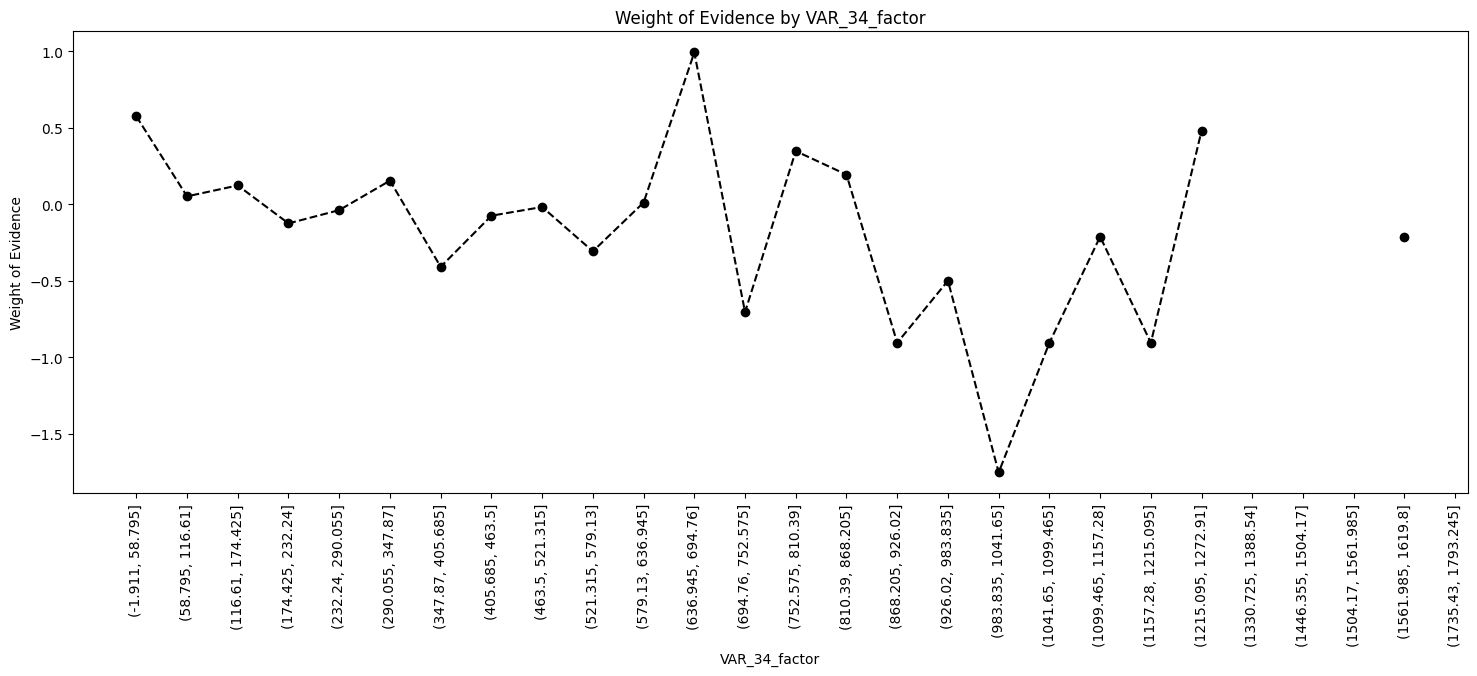

In [79]:
# Fine classing - VAR_34
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_34'])]
df_inputs_prepr_temp[f'VAR_34_factor'] = pd.cut(df_inputs_prepr_temp['VAR_34'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_34_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [80]:
df_inputs_prepr['VAR_34'].isnull().sum()

936

/tmp/ipykernel_11938/2184336505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_35_factor'] = pd.cut(df_inputs_prepr_temp['VAR_35'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_35_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0       (-2.933, 58.865]   37    95    132  0.110368  0.101928  0.114046   
1      (58.865, 117.719]   49   148    197  0.164716  0.134986  0.177671   
2     (117.719, 176.574]   64   116    180  0.150502  0.176309  0.139256   
3     (176.574, 235.428]   42   102    144  0.120401  0.115702  0.122449   
4     (235.428, 294.283]   36    77    113  0.094482  0.099174  0.092437   
5     (294.283, 353.138]   24    70     94  0.078595  0.066116  0.084034   
6     (353.138, 411.992]   32    45     77  0.064381  0.088154  0.054022   
7     (411.992, 470.847]   22    30     52  0.043478  0.060606  0.036014   
8     (470.847, 529.701]   17    36     53  0.044314  0.046832  0.043217   
9     (529.701, 588.556]    4    22     26  0.021739  0.011019  0.026411   
10    (588.556, 647.411]    6    16     22  0.018395  0.016529  0.019208   
11    (647.411, 706.265]    9    15     24  0.020067  0.024793  0.018007   
12     (706.265, 765.12]    5    10     15  0.012542  0.013774  0.012005   
13     (765.12, 823.974]    4     8     12  0.010033  0.011019  0.009604   
14    (823.974, 882.829]    1     8      9  0.007525  0.002755  0.009604   
15    (882.829, 941.684]    0     9      9  0.007525  0.000000  0.010804   
16   (941.684, 1000.538]    2     1      3  0.002508  0.005510  0.001200   
17  (1000.538, 1059.393]    1     7      8  0.006689  0.002755  0.008403   
18  (1059.393, 1118.247]    2     4      6  0.005017  0.005510  0.004802   
19  (1118.247, 1177.102]    1     2      3  0.002508  0.002755  0.002401   
20  (1177.102, 1235.957]    0     2      2  0.001672  0.000000  0.002401   
21  (1235.957, 1294.811]    0     1      1  0.000836  0.000000  0.001200   
22   (1353.666, 1412.52]    0     2      2  0.001672  0.000000  0.002401   
23   (1412.52, 1471.375]    2     0      2  0.001672  0.005510  0.000000   
24   (1471.375, 1530.23]    1     1      2  0.001672  0.002755  0.001200   
25  (1706.793, 1765.648]    0     1      1  0.000836  0.000000  0.001200   
26  (1824.503, 1883.357]    0     2      2  0.001672  0.000000  0.002401   
27  (1883.357, 1942.212]    0     1      1  0.000836  0.000000  0.001200   
28  (1942.212, 2001.066]    0     1      1  0.000836  0.000000  0.001200   
29  (2059.921, 2118.776]    0     1      1  0.000836  0.000000  0.001200   
30  (2413.049, 2471.903]    1     0      1  0.000836  0.002755  0.000000   
31   (2883.885, 2942.74]    1     0      1  0.000836  0.002755  0.000000   

    DefaultRate       WoE      diff_WoE   IV  
0      0.280303  0.112328           NaN  inf  
1      0.248731  0.274761  1.624330e-01  inf  
2      0.355556 -0.235924  5.106849e-01  inf  
3      0.291667  0.056672  2.925961e-01  inf  
4      0.318584 -0.070344  1.270167e-01  inf  
5      0.255319  0.239811  3.101549e-01  inf  
6      0.415584 -0.489704  7.295148e-01  inf  
7      0.423077 -0.520476  3.077166e-02  inf  
8      0.320755 -0.080325  4.401507e-01  inf  
9      0.153846  0.874117  9.544425e-01  inf  
10     0.272727  0.150198  7.239188e-01  inf  
11     0.375000 -0.319805  4.700036e-01  inf  
12     0.333333 -0.137484  1.823216e-01  inf  
13     0.333333 -0.137484  1.387779e-16  inf  
14     0.111111  1.248811  1.386294e+00  inf  
15     0.000000       inf           inf  inf  
16     0.666667 -1.523778           inf  inf  
17     0.125000  1.115279  2.639057e+00  inf  
18     0.333333 -0.137484  1.252763e+00  inf  
19     0.333333 -0.137484  0.000000e+00  inf  
20     0.000000       inf           inf  inf  
21     0.000000       inf           NaN  inf  
22     0.000000       inf           NaN  inf  
23     1.000000      -inf           inf  inf  
24     0.500000 -0.830631           inf  inf  
25     0.000000       inf           inf  inf  
26     0.000000       inf           NaN  inf  
27     0.000000       inf           NaN  inf  
28     0.000000       inf           NaN  inf  
29     0.000000       inf           NaN  inf  
30     1.000000      -inf           inf  inf 

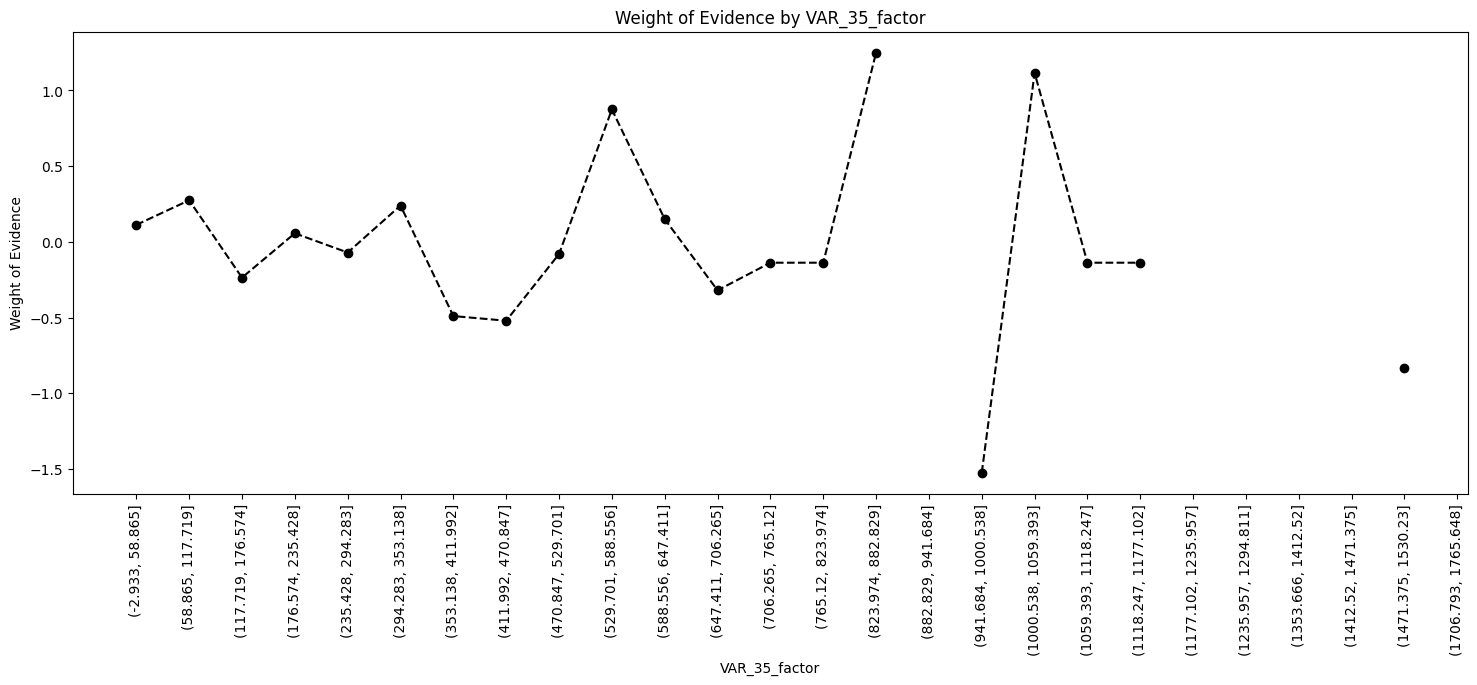

In [81]:
# Fine classing - VAR_35
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_35'])]
df_inputs_prepr_temp[f'VAR_35_factor'] = pd.cut(df_inputs_prepr_temp['VAR_35'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_35_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [82]:
df_inputs_prepr['VAR_35'].isnull().sum()

952

In [83]:
 # VAR_35
df_inputs_prepr['VAR_35:Missing'] = np.where((df_inputs_prepr['VAR_35'].isnull()), 1, 0)
df_inputs_prepr['VAR_35:<=190.022'] = np.where((df_inputs_prepr['VAR_35']<=190.022), 1, 0)
df_inputs_prepr['VAR_35:>190.022'] = np.where((df_inputs_prepr['VAR_35']>190.022), 1, 0)

/tmp/ipykernel_11938/1873058428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_38_factor'] = pd.cut(df_inputs_prepr_temp['VAR_38'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_38_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0       (-1.447, 48.672]   27    74    101  0.081914  0.071809  0.086348   
1       (48.672, 96.405]   53   113    166  0.134631  0.140957  0.131855   
2      (96.405, 144.137]   39   106    145  0.117599  0.103723  0.123687   
3      (144.137, 191.87]   45    93    138  0.111922  0.119681  0.108518   
4      (191.87, 239.602]   33    95    128  0.103812  0.087766  0.110852   
5     (239.602, 287.334]   35    65    100  0.081103  0.093085  0.075846   
6     (287.334, 335.067]   25    67     92  0.074615  0.066489  0.078180   
7     (335.067, 382.799]   19    51     70  0.056772  0.050532  0.059510   
8     (382.799, 430.532]   19    35     54  0.043796  0.050532  0.040840   
9     (430.532, 478.264]   15    24     39  0.031630  0.039894  0.028005   
10    (478.264, 525.996]    8    35     43  0.034874  0.021277  0.040840   
11    (525.996, 573.729]   13    13     26  0.021087  0.034574  0.015169   
12    (573.729, 621.461]    9    16     25  0.020276  0.023936  0.018670   
13    (621.461, 669.194]    5    15     20  0.016221  0.013298  0.017503   
14    (669.194, 716.926]    9     5     14  0.011354  0.023936  0.005834   
15    (716.926, 764.658]    9     8     17  0.013788  0.023936  0.009335   
16    (764.658, 812.391]    1     8      9  0.007299  0.002660  0.009335   
17    (812.391, 860.123]    2     8     10  0.008110  0.005319  0.009335   
18    (860.123, 907.856]    0     1      1  0.000811  0.000000  0.001167   
19    (907.856, 955.588]    0     4      4  0.003244  0.000000  0.004667   
20    (955.588, 1003.32]    3     1      4  0.003244  0.007979  0.001167   
21   (1003.32, 1051.053]    0     3      3  0.002433  0.000000  0.003501   
22  (1051.053, 1098.785]    0     2      2  0.001622  0.000000  0.002334   
23  (1098.785, 1146.518]    1     0      1  0.000811  0.002660  0.000000   
24   (1146.518, 1194.25]    1     5      6  0.004866  0.002660  0.005834   
25   (1194.25, 1241.982]    2     1      3  0.002433  0.005319  0.001167   
26  (1289.715, 1337.447]    0     1      1  0.000811  0.000000  0.001167   
27   (1337.447, 1385.18]    2     0      2  0.001622  0.005319  0.000000   
28   (1385.18, 1432.912]    0     1      1  0.000811  0.000000  0.001167   
29  (1480.644, 1528.377]    0     1      1  0.000811  0.000000  0.001167   
30  (1528.377, 1576.109]    0     1      1  0.000811  0.000000  0.001167   
31  (1576.109, 1623.842]    0     1      1  0.000811  0.000000  0.001167   
32  (1719.306, 1767.039]    0     1      1  0.000811  0.000000  0.001167   
33  (1767.039, 1814.771]    0     2      2  0.001622  0.000000  0.002334   
34  (1814.771, 1862.504]    0     1      1  0.000811  0.000000  0.001167   
35   (2339.828, 2387.56]    1     0      1  0.000811  0.002660  0.000000   

    DefaultRate       WoE  diff_WoE   IV  
0      0.267327  0.184379       NaN  inf  
1      0.319277 -0.066753  0.251132  inf  
2      0.268966  0.176029  0.242782  inf  
3      0.326087 -0.097912  0.273940  inf  
4      0.257812  0.233521  0.331432  inf  
5      0.350000 -0.204810  0.438330  inf  
6      0.271739  0.161968  0.366778  inf  
7      0.271429  0.163538  0.001570  inf  
8      0.351852 -0.212940  0.376478  inf  
9      0.384615 -0.353845  0.140905  inf  
10     0.186047  0.652058  1.005903  inf  
11     0.500000 -0.823849  1.475907  inf  
12     0.360000 -0.248485  0.575364  inf  
13     0.250000  0.274764  0.523248  inf  
14     0.642857 -1.411635  1.686399  inf  
15     0.529412 -0.941632  0.470004  inf  
16     0.111111  1.255593  2.197225  inf  
17     0.200000  0.562446  0.693147  inf  
18     0.000000       inf       inf  inf  
19     0.000000       inf       NaN  inf  
20     0.750000 -1.922461       inf  inf  
21     0.000000       inf       inf  inf  
22     0.000000       inf       NaN  inf  
23     1.000000      -inf       inf  inf  
24     0.166667  0.785589       inf  inf  
25     0.666667 -1.516996  2.302585  inf  
26     0.000000       inf       inf  

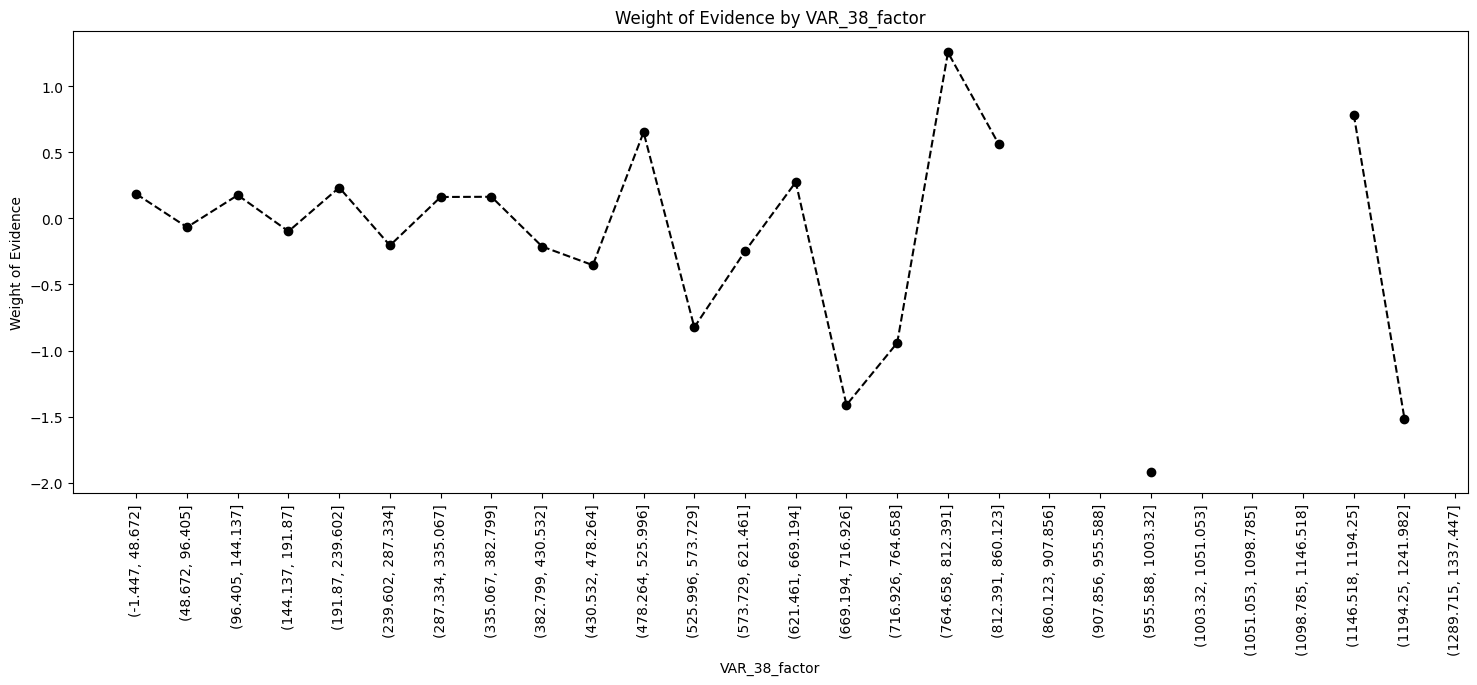

In [84]:
# Fine classing - VAR_38
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_38'])]
df_inputs_prepr_temp[f'VAR_38_factor'] = pd.cut(df_inputs_prepr_temp['VAR_38'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_38_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [85]:
df_inputs_prepr['VAR_38'].isnull().sum()

915

/tmp/ipykernel_11938/2664807682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_45_factor'] = pd.cut(df_inputs_prepr_temp['VAR_45'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_45_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0        (7.496, 60.088]   27    47     74  0.065487  0.094737  0.055621   
1      (60.088, 110.177]   20    65     85  0.075221  0.070175  0.076923   
2     (110.177, 160.265]   26    64     90  0.079646  0.091228  0.075740   
3     (160.265, 210.354]   23    73     96  0.084956  0.080702  0.086391   
4     (210.354, 260.442]   26    77    103  0.091150  0.091228  0.091124   
5      (260.442, 310.53]   35    85    120  0.106195  0.122807  0.100592   
6      (310.53, 360.619]   21    74     95  0.084071  0.073684  0.087574   
7     (360.619, 410.707]   21    74     95  0.084071  0.073684  0.087574   
8     (410.707, 460.796]   18    52     70  0.061947  0.063158  0.061538   
9     (460.796, 510.884]   16    38     54  0.047788  0.056140  0.044970   
10    (510.884, 560.972]    9    29     38  0.033628  0.031579  0.034320   
11    (560.972, 611.061]    5    29     34  0.030088  0.017544  0.034320   
12    (611.061, 661.149]    8    21     29  0.025664  0.028070  0.024852   
13    (661.149, 711.238]    7    23     30  0.026549  0.024561  0.027219   
14    (711.238, 761.326]    2    24     26  0.023009  0.007018  0.028402   
15    (761.326, 811.414]    3    15     18  0.015929  0.010526  0.017751   
16    (811.414, 861.503]    4     5      9  0.007965  0.014035  0.005917   
17    (861.503, 911.591]    2     6      8  0.007080  0.007018  0.007101   
18     (911.591, 961.68]    0     5      5  0.004425  0.000000  0.005917   
19    (961.68, 1011.768]    0     6      6  0.005310  0.000000  0.007101   
20  (1011.768, 1061.856]    0     3      3  0.002655  0.000000  0.003550   
21  (1061.856, 1111.945]    1     3      4  0.003540  0.003509  0.003550   
22  (1111.945, 1162.033]    1     1      2  0.001770  0.003509  0.001183   
23  (1162.033, 1212.122]    0     1      1  0.000885  0.000000  0.001183   
24   (1212.122, 1262.21]    2     2      4  0.003540  0.007018  0.002367   
25   (1262.21, 1312.298]    2     2      4  0.003540  0.007018  0.002367   
26  (1312.298, 1362.387]    0     3      3  0.002655  0.000000  0.003550   
27  (1362.387, 1412.475]    0     2      2  0.001770  0.000000  0.002367   
28  (1412.475, 1462.564]    0     2      2  0.001770  0.000000  0.002367   
29  (1462.564, 1512.652]    0     3      3  0.002655  0.000000  0.003550   
30   (1512.652, 1562.74]    1     0      1  0.000885  0.003509  0.000000   
31   (1562.74, 1612.829]    0     3      3  0.002655  0.000000  0.003550   
32  (1662.917, 1713.006]    0     2      2  0.001770  0.000000  0.002367   
33  (1713.006, 1763.094]    1     1      2  0.001770  0.003509  0.001183   
34  (1763.094, 1813.182]    1     2      3  0.002655  0.003509  0.002367   
35  (1813.182, 1863.271]    0     1      1  0.000885  0.000000  0.001183   
36  (1863.271, 1913.359]    1     0      1  0.000885  0.003509  0.000000   
37  (2013.536, 2063.624]    0     1      1  0.000885  0.000000  0.001183   
38   (2213.89, 2263.978]    1     0      1  0.000885  0.003509  0.000000   
39  (2364.155, 2414.243]    1     0      1  0.000885  0.003509  0.000000   
40   (2464.332, 2514.42]    0     1      1  0.000885  0.000000  0.001183   

    DefaultRate       WoE  diff_WoE   IV  
0      0.364865 -0.532537       NaN  inf  
1      0.235294  0.091808  0.624344  inf  
2      0.288889 -0.186061  0.277868  inf  
3      0.239583  0.068118  0.254179  inf  
4      0.252427 -0.001139  0.069256  inf  
5      0.291667 -0.199544  0.198406  inf  
6      0.221053  0.172695  0.372239  inf  
7      0.221053  0.172695  0.000000  inf  
8      0.257143 -0.025975  0.198671  inf  
9      0.296296 -0.221850  0.195875  inf  
10     0.236842  0.083224  0.305074  inf  
11     0.147059  0.671010  0.587787  inf  
12     0.275862 -0.121767  0.792777  inf  
13     0.233333  0.102737  0.224503  inf  
14     0.076923  1.398059  1.295323  inf  
15     0.166667  0.522590  0.875469  inf  
16     0.444444 -0.863704  1.386294  inf  
17     0.250000  0.011765  0.875469  inf  
1

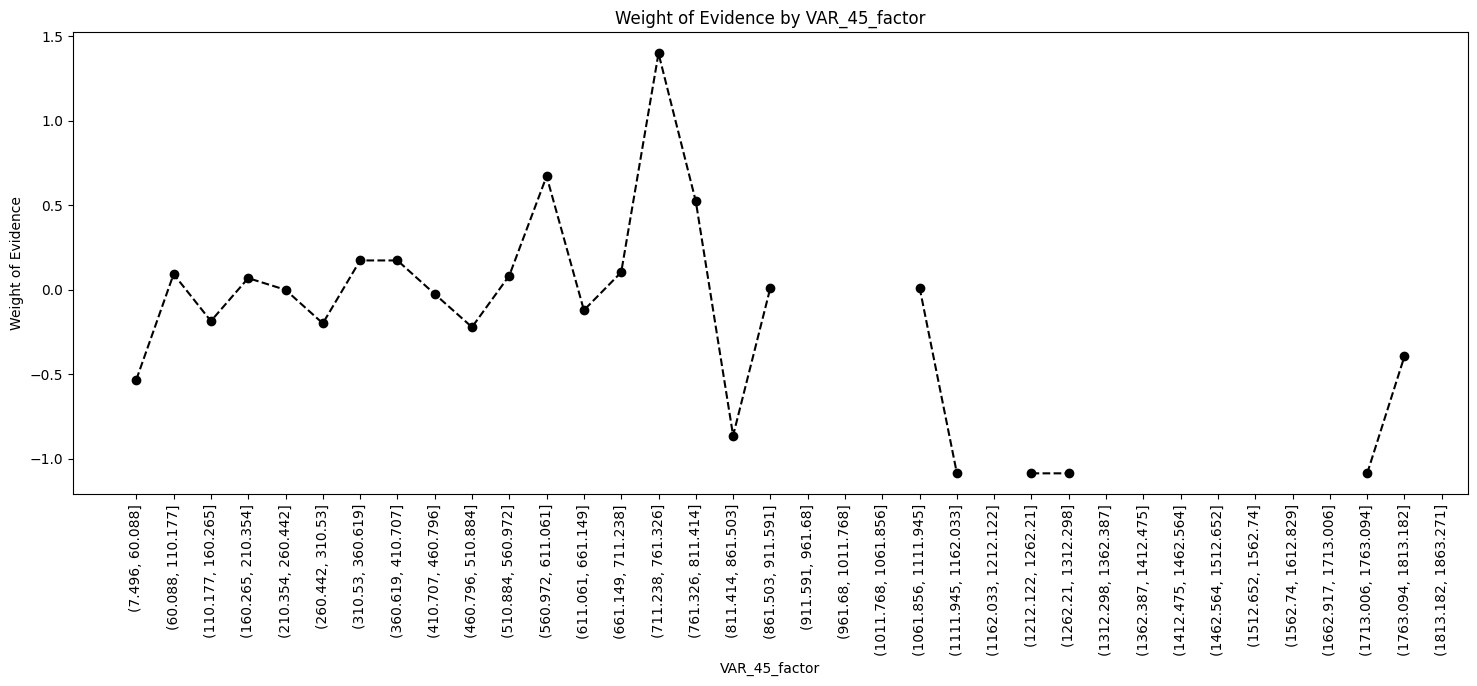

In [86]:
# Fine classing - VAR_45
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_45'])]
df_inputs_prepr_temp[f'VAR_45_factor'] = pd.cut(df_inputs_prepr_temp['VAR_45'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_45_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [87]:
df_inputs_prepr['VAR_45'].isnull().sum()

1018

/tmp/ipykernel_11938/2211771777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_52_factor'] = pd.cut(df_inputs_prepr_temp['VAR_52'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_52_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0       (-1.096, 32.419]   14    34     48  0.041096  0.040346  0.041413   
1       (32.419, 64.338]   33    71    104  0.089041  0.095101  0.086480   
2       (64.338, 96.256]   22    84    106  0.090753  0.063401  0.102314   
3      (96.256, 128.175]   30    67     97  0.083048  0.086455  0.081608   
4     (128.175, 160.094]   26    78    104  0.089041  0.074928  0.095006   
5     (160.094, 192.013]   29    55     84  0.071918  0.083573  0.066991   
6     (192.013, 223.932]   31    58     89  0.076199  0.089337  0.070646   
7      (223.932, 255.85]   20    56     76  0.065068  0.057637  0.068210   
8      (255.85, 287.769]   17    41     58  0.049658  0.048991  0.049939   
9     (287.769, 319.688]   23    33     56  0.047945  0.066282  0.040195   
10    (319.688, 351.607]   17    49     66  0.056507  0.048991  0.059683   
11    (351.607, 383.526]    9    29     38  0.032534  0.025937  0.035323   
12    (383.526, 415.444]   14    23     37  0.031678  0.040346  0.028015   
13    (415.444, 447.363]    5    21     26  0.022260  0.014409  0.025579   
14    (447.363, 479.282]    8    16     24  0.020548  0.023055  0.019488   
15    (479.282, 511.201]   11    16     27  0.023116  0.031700  0.019488   
16     (511.201, 543.12]    5    18     23  0.019692  0.014409  0.021924   
17     (543.12, 575.038]    4    15     19  0.016267  0.011527  0.018270   
18    (575.038, 606.957]    4     8     12  0.010274  0.011527  0.009744   
19    (606.957, 638.876]    1     6      7  0.005993  0.002882  0.007308   
20    (638.876, 670.795]    5     5     10  0.008562  0.014409  0.006090   
21    (670.795, 702.714]    1     3      4  0.003425  0.002882  0.003654   
22    (702.714, 734.632]    3     6      9  0.007705  0.008646  0.007308   
23    (734.632, 766.551]    1     2      3  0.002568  0.002882  0.002436   
24     (766.551, 798.47]    1     5      6  0.005137  0.002882  0.006090   
25     (798.47, 830.389]    4     1      5  0.004281  0.011527  0.001218   
26    (830.389, 862.308]    2     7      9  0.007705  0.005764  0.008526   
27    (862.308, 894.226]    1     2      3  0.002568  0.002882  0.002436   
28    (894.226, 926.145]    0     1      1  0.000856  0.000000  0.001218   
29    (926.145, 958.064]    2     2      4  0.003425  0.005764  0.002436   
30    (958.064, 989.983]    0     2      2  0.001712  0.000000  0.002436   
31   (989.983, 1021.902]    1     1      2  0.001712  0.002882  0.001218   
32   (1021.902, 1053.82]    1     2      3  0.002568  0.002882  0.002436   
33   (1053.82, 1085.739]    0     1      1  0.000856  0.000000  0.001218   
34  (1085.739, 1117.658]    0     1      1  0.000856  0.000000  0.001218   
35  (1181.496, 1213.414]    1     0      1  0.000856  0.002882  0.000000   
36   (1341.09, 1373.008]    1     0      1  0.000856  0.002882  0.000000   
37  (1500.684, 1532.602]    0     1      1  0.000856  0.000000  0.001218   
38   (1564.521, 1596.44]    0     1      1  0.000856  0.000000  0.001218   

    DefaultRate       WoE      diff_WoE   IV  
0      0.291667  0.026105           NaN  inf  
1      0.317308 -0.095026  1.211309e-01  inf  
2      0.207547  0.478576  5.736020e-01  inf  
3      0.309278 -0.057703  5.362791e-01  inf  
4      0.250000  0.237414  2.951171e-01  inf  
5      0.345238 -0.221161  4.585749e-01  inf  
6      0.348315 -0.234743  1.358155e-02  inf  
7      0.263158  0.168421  4.031636e-01  inf  
8      0.293103  0.019160  1.492607e-01  inf  
9      0.410714 -0.500185  5.193454e-01  inf  
10     0.257576  0.197409  6.975936e-01  inf  
11     0.236842  0.308873  1.114643e-01  inf  
12     0.378378 -0.364761  6.736344e-01  inf  
13     0.192308  0.573886  9.386476e-01  inf  
14     0.333333 -0.168051  7.419373e-01  inf  
15     0.407407 -0.486505  3.184537e-01  inf  
16     0.217391  0.419736  9.062404e-01  inf  
17     0.210526  0.460558  4.082199e-02  inf  
18     0.333333 -0.168051  6.286087e-01  inf  
19     0.142857  0.930561  1.0

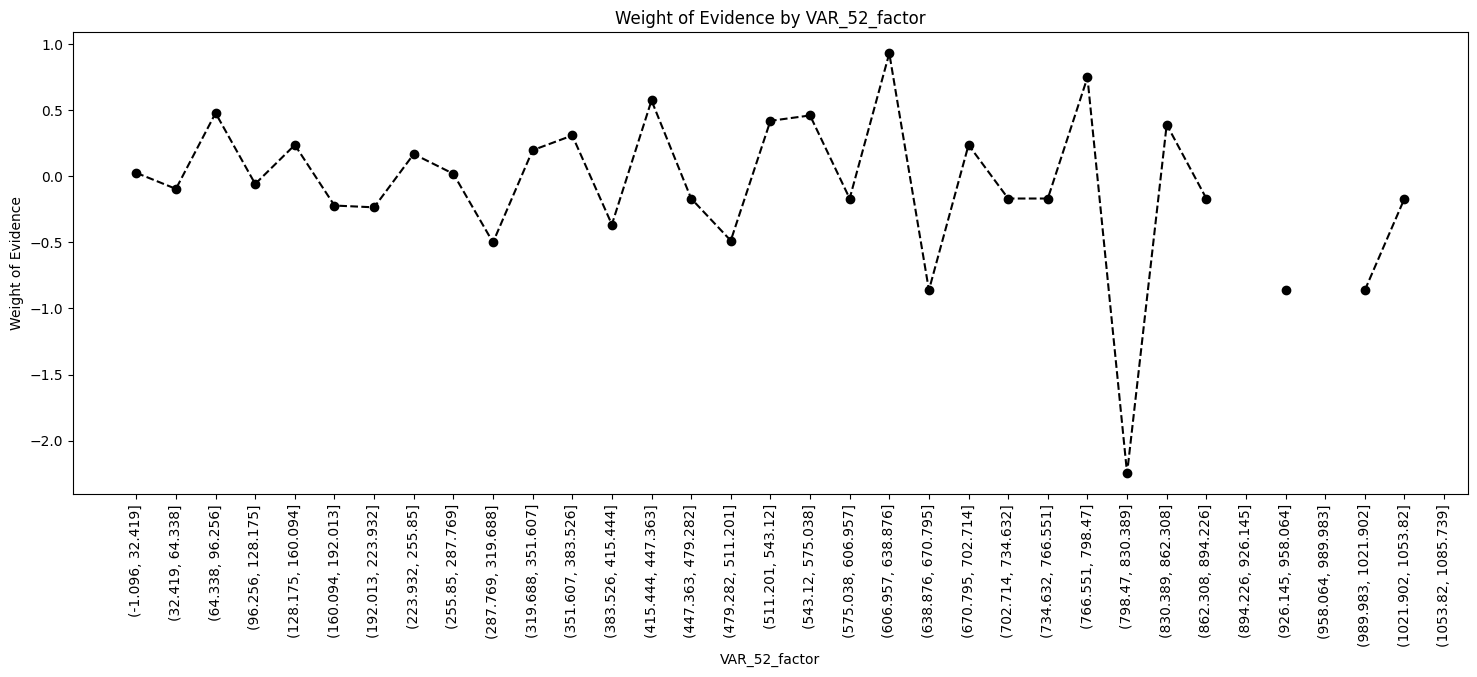

In [88]:
# Fine classing - VAR_52
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_52'])]
df_inputs_prepr_temp[f'VAR_52_factor'] = pd.cut(df_inputs_prepr_temp['VAR_52'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_52_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [89]:
df_inputs_prepr['VAR_52'].isnull().sum()

980

/tmp/ipykernel_11938/2270973270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_53_factor'] = pd.cut(df_inputs_prepr_temp['VAR_53'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_53_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0        (19.402, 483.678]   29   109    138  0.077009  0.058824  0.083911   
1       (483.678, 925.846]   57   203    260  0.145089  0.115619  0.156274   
2      (925.846, 1368.015]  101   241    342  0.190848  0.204868  0.185527   
3     (1368.015, 1810.183]   72   136    208  0.116071  0.146045  0.104696   
4     (1810.183, 2252.351]   68   144    212  0.118304  0.137931  0.110855   
5     (2252.351, 2694.519]   36    75    111  0.061942  0.073022  0.057737   
6     (2694.519, 3136.687]   27    93    120  0.066964  0.054767  0.071594   
7     (3136.687, 3578.856]   21    58     79  0.044085  0.042596  0.044650   
8     (3578.856, 4021.024]   12    46     58  0.032366  0.024341  0.035412   
9     (4021.024, 4463.192]   10    33     43  0.023996  0.020284  0.025404   
10     (4463.192, 4905.36]   14    26     40  0.022321  0.028398  0.020015   
11     (4905.36, 5347.528]    7    24     31  0.017299  0.014199  0.018476   
12    (5347.528, 5789.697]    8    17     25  0.013951  0.016227  0.013087   
13    (5789.697, 6231.865]    7    16     23  0.012835  0.014199  0.012317   
14    (6231.865, 6674.033]    1     7      8  0.004464  0.002028  0.005389   
15    (6674.033, 7116.201]    5     9     14  0.007812  0.010142  0.006928   
16    (7116.201, 7558.369]    3     6      9  0.005022  0.006085  0.004619   
17    (7558.369, 8000.538]    1    10     11  0.006138  0.002028  0.007698   
18    (8000.538, 8442.706]    2     4      6  0.003348  0.004057  0.003079   
19    (8442.706, 8884.874]    0     7      7  0.003906  0.000000  0.005389   
20    (8884.874, 9327.042]    2     7      9  0.005022  0.004057  0.005389   
21     (9327.042, 9769.21]    2     3      5  0.002790  0.004057  0.002309   
22    (9769.21, 10211.379]    1     2      3  0.001674  0.002028  0.001540   
23  (10211.379, 10653.547]    0     3      3  0.001674  0.000000  0.002309   
24  (10653.547, 11095.715]    2     2      4  0.002232  0.004057  0.001540   
25  (11095.715, 11537.883]    0     3      3  0.001674  0.000000  0.002309   
26  (11537.883, 11980.051]    1     0      1  0.000558  0.002028  0.000000   
27   (11980.051, 12422.22]    1     3      4  0.002232  0.002028  0.002309   
28   (12422.22, 12864.388]    2     1      3  0.001674  0.004057  0.000770   
29  (12864.388, 13306.556]    1     3      4  0.002232  0.002028  0.002309   
30  (13306.556, 13748.724]    0     1      1  0.000558  0.000000  0.000770   
31  (13748.724, 14190.892]    0     2      2  0.001116  0.000000  0.001540   
32  (14633.061, 15075.229]    0     1      1  0.000558  0.000000  0.000770   
33  (15959.565, 16401.733]    0     1      1  0.000558  0.000000  0.000770   
34  (16401.733, 16843.902]    0     1      1  0.000558  0.000000  0.000770   
35  (18170.406, 18612.574]    0     1      1  0.000558  0.000000  0.000770   
36   (21707.752, 22149.92]    0     1      1  0.000558  0.000000  0.000770   

    DefaultRate       WoE  diff_WoE   IV  
0      0.210145  0.355211       NaN  inf  
1      0.219231  0.301314  0.053897  inf  
2      0.295322 -0.099164  0.400478  inf  
3      0.346154 -0.332852  0.233688  inf  
4      0.320755 -0.218535  0.114317  inf  
5      0.324324 -0.234872  0.016336  inf  
6      0.225000  0.267922  0.502793  inf  
7      0.265823  0.047080  0.220842  inf  
8      0.206897  0.374894  0.327814  inf  
9      0.232558  0.225082  0.149812  inf  
10     0.350000 -0.349802  0.574883  inf  
11     0.225806  0.263303  0.613104  inf  
12     0.320000 -0.215069  0.478372  inf  
13     0.304348 -0.142162  0.072907  inf  
14     0.125000  0.977069  1.119232  inf  
15     0.357143 -0.381054  1.358123  inf  
16     0.333333 -0.275694  0.105361  inf  
17     0.090909  1.333744  1.609438  inf  
18     0.333333 -0.275694  1.609438  inf  
19     0.000000       inf       inf  inf  
20     0.222222  0.283922       inf  inf  
21     0.400000 -0.563376  0.847298  inf  
22     0.333333 -0.275694  0.287682  inf  
23     0.000000 

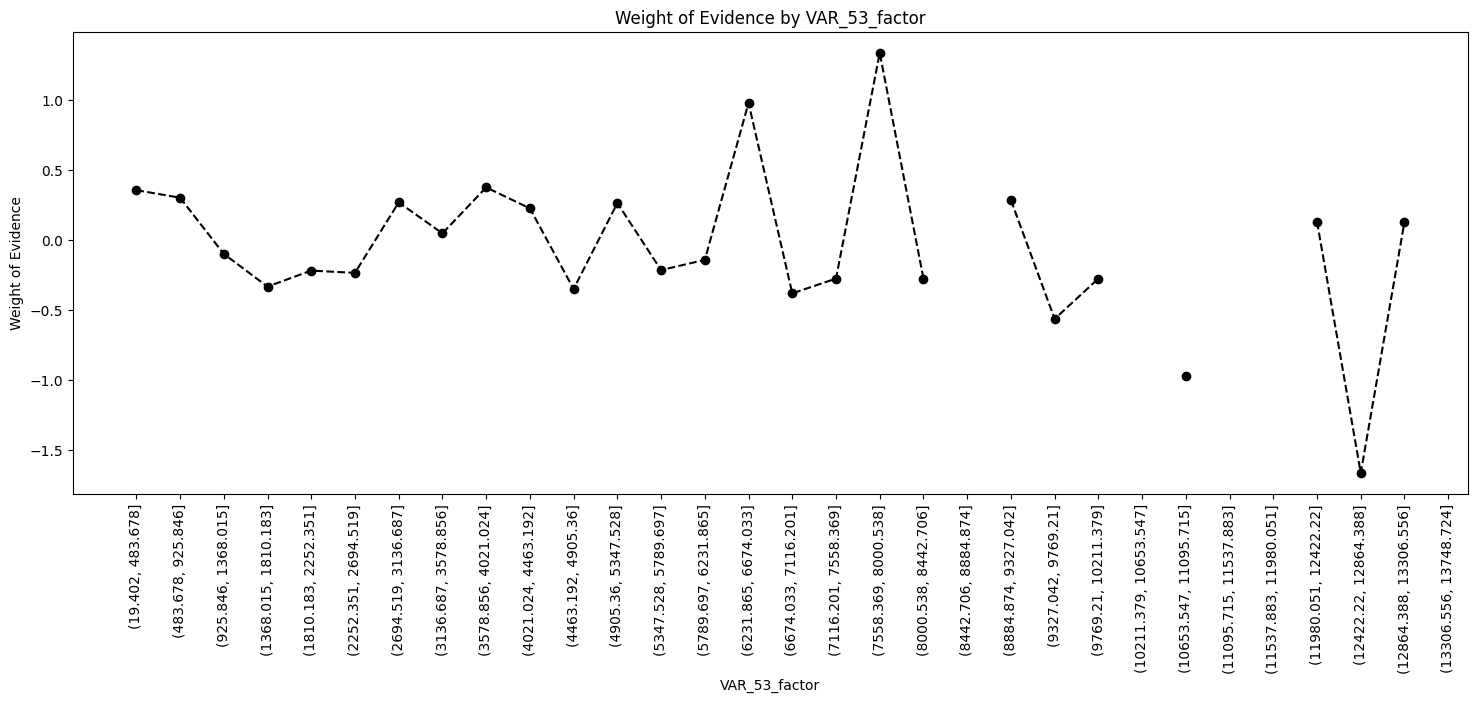

In [90]:
# Fine classing - VAR_53
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_53'])]
df_inputs_prepr_temp[f'VAR_53_factor'] = pd.cut(df_inputs_prepr_temp['VAR_53'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_53_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [91]:
df_inputs_prepr['VAR_53'].isnull().sum()

356

In [92]:
 # VAR_53
df_inputs_prepr['VAR_53:Missing'] = np.where((df_inputs_prepr['VAR_53'].isnull()), 1, 0)
df_inputs_prepr['VAR_53:<=579.042'] = np.where((df_inputs_prepr['VAR_53']<=579.042), 1, 0)
df_inputs_prepr['VAR_53:>579.042'] = np.where((df_inputs_prepr['VAR_53']>579.042), 1, 0)

/tmp/ipykernel_11938/3312857391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_54_factor'] = pd.cut(df_inputs_prepr_temp['VAR_54'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_54_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0        (44.362, 351.337]   16    81     97  0.051678  0.030476  0.059911   
1       (351.337, 643.694]   61   173    234  0.124667  0.116190  0.127959   
2       (643.694, 936.052]   43   124    167  0.088972  0.081905  0.091716   
3      (936.052, 1228.409]  123   289    412  0.219499  0.234286  0.213757   
4     (1228.409, 1520.766]   54   150    204  0.108684  0.102857  0.110947   
5     (1520.766, 1813.123]   31    73    104  0.055408  0.059048  0.053994   
6      (1813.123, 2105.48]   57   113    170  0.090570  0.108571  0.083580   
7      (2105.48, 2397.838]   20    45     65  0.034630  0.038095  0.033284   
8     (2397.838, 2690.195]   18    47     65  0.034630  0.034286  0.034763   
9     (2690.195, 2982.552]   20    33     53  0.028237  0.038095  0.024408   
10    (2982.552, 3274.909]   20    58     78  0.041556  0.038095  0.042899   
11    (3274.909, 3567.266]   15    29     44  0.023442  0.028571  0.021450   
12    (3567.266, 3859.624]    5    14     19  0.010123  0.009524  0.010355   
13    (3859.624, 4151.981]   12    25     37  0.019712  0.022857  0.018491   
14    (4151.981, 4444.338]    7    12     19  0.010123  0.013333  0.008876   
15    (4444.338, 4736.695]    5    10     15  0.007991  0.009524  0.007396   
16    (4736.695, 5029.052]    2    11     13  0.006926  0.003810  0.008136   
17     (5029.052, 5321.41]    2     6      8  0.004262  0.003810  0.004438   
18     (5321.41, 5613.767]    2     9     11  0.005860  0.003810  0.006657   
19    (5613.767, 5906.124]    1     3      4  0.002131  0.001905  0.002219   
20    (5906.124, 6198.481]    1     8      9  0.004795  0.001905  0.005917   
21    (6198.481, 6490.838]    2     9     11  0.005860  0.003810  0.006657   
22    (6490.838, 6783.196]    1     5      6  0.003197  0.001905  0.003698   
23    (6783.196, 7075.553]    2     4      6  0.003197  0.003810  0.002959   
24     (7367.91, 7660.267]    0     1      1  0.000533  0.000000  0.000740   
25    (7660.267, 7952.624]    1     4      5  0.002664  0.001905  0.002959   
26    (7952.624, 8244.982]    0     1      1  0.000533  0.000000  0.000740   
27    (8244.982, 8537.339]    1     1      2  0.001066  0.001905  0.000740   
28    (8537.339, 8829.696]    0     2      2  0.001066  0.000000  0.001479   
29    (8829.696, 9122.053]    0     1      1  0.000533  0.000000  0.000740   
30     (9122.053, 9414.41]    0     3      3  0.001598  0.000000  0.002219   
31     (9414.41, 9706.768]    1     0      1  0.000533  0.001905  0.000000   
32    (9706.768, 9999.125]    1     1      2  0.001066  0.001905  0.000740   
33   (9999.125, 10291.482]    0     2      2  0.001066  0.000000  0.001479   
34  (10876.196, 11168.554]    0     1      1  0.000533  0.000000  0.000740   
35  (11460.911, 11753.268]    0     1      1  0.000533  0.000000  0.000740   
36  (11753.268, 12045.625]    0     2      2  0.001066  0.000000  0.001479   
37   (12630.34, 12922.697]    1     0      1  0.000533  0.001905  0.000000   
38   (14384.483, 14676.84]    0     1      1  0.000533  0.000000  0.000740   

    DefaultRate       WoE  diff_WoE   IV  
0      0.164948  0.675918       NaN  inf  
1      0.260684  0.096476  0.579443  inf  
2      0.257485  0.113139  0.016664  inf  
3      0.298544 -0.091700  0.204839  inf  
4      0.264706  0.075709  0.167409  inf  
5      0.298077 -0.089470  0.165179  inf  
6      0.335294 -0.261605  0.172136  inf  
7      0.307692 -0.135012  0.126594  inf  
8      0.276923  0.013834  0.148846  inf  
9      0.377358 -0.445167  0.459001  inf  
10     0.256410  0.118769  0.563935  inf  
11     0.340909 -0.286696  0.405465  inf  
12     0.263158  0.083677  0.370374  inf  
13     0.324324 -0.211973  0.295650  inf  
14     0.368421 -0.406945  0.194973  inf  
15     0.333333 -0.252795  0.154151  inf  
16     0.153846  0.758806  1.011601  inf  
17     0.250000  0.152670  0.606136  inf  
18     0.181818  0.558135  0.405465  inf  
19     0.250000  0.152670  0.405

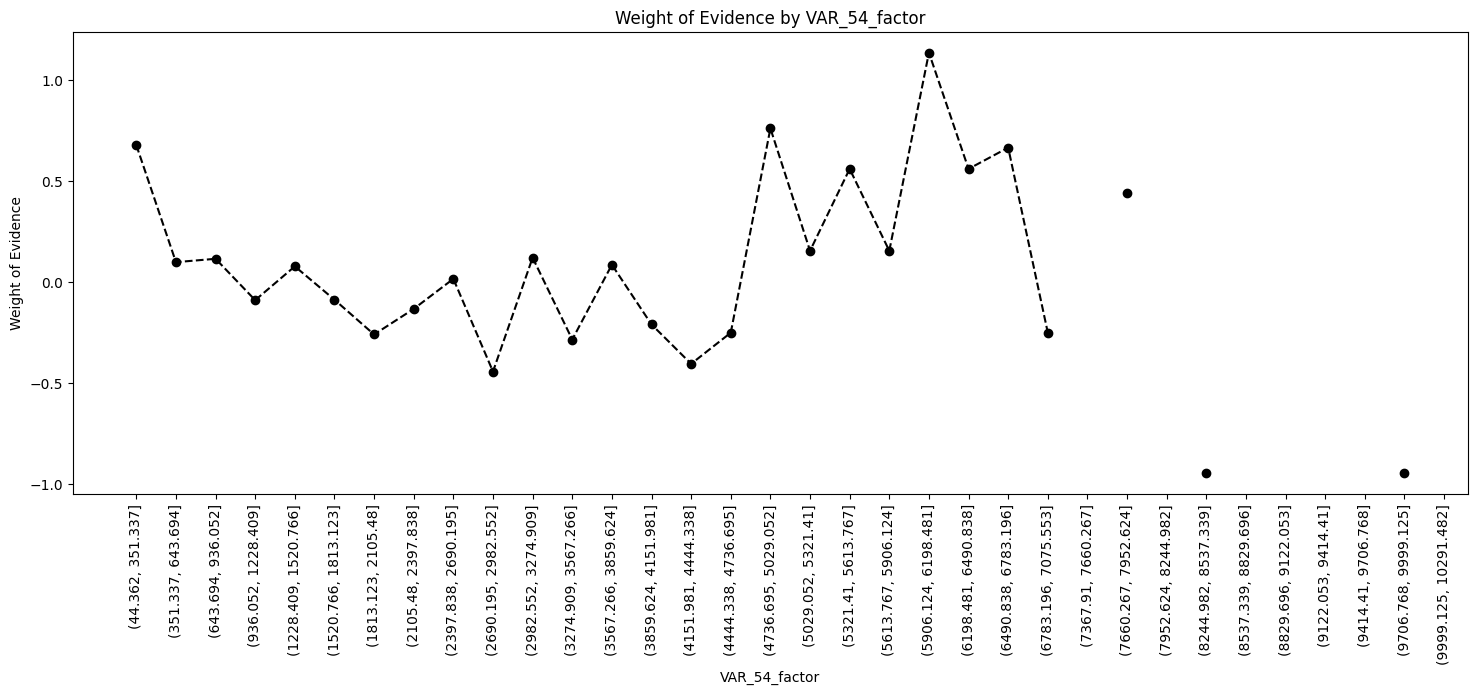

In [93]:
# Fine classing - VAR_54
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_54'])]
df_inputs_prepr_temp[f'VAR_54_factor'] = pd.cut(df_inputs_prepr_temp['VAR_54'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_54_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [94]:
df_inputs_prepr['VAR_54'].isnull().sum()

271

In [95]:
 # VAR_54
df_inputs_prepr['VAR_54:Missing'] = np.where((df_inputs_prepr['VAR_54'].isnull()), 1, 0)
df_inputs_prepr['VAR_54:<=665.297'] = np.where((df_inputs_prepr['VAR_54']<=665.297), 1, 0)
df_inputs_prepr['VAR_54:>665.297'] = np.where((df_inputs_prepr['VAR_54']>665.297), 1, 0)

/tmp/ipykernel_11938/729330446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_58_factor'] = pd.cut(df_inputs_prepr_temp['VAR_58'],50)


VAR_58_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (-1.688, 54.76]   25    63     88  0.064000  0.067204  0.062812   
1      (54.76, 108.52]   32    98    130  0.094545  0.086022  0.097707   
2     (108.52, 162.28]   38   114    152  0.110545  0.102151  0.113659   
3     (162.28, 216.04]   44   131    175  0.127273  0.118280  0.130608   
4      (216.04, 269.8]   58   114    172  0.125091  0.155914  0.113659   
5      (269.8, 323.56]   41    83    124  0.090182  0.110215  0.082752   
6     (323.56, 377.32]   26    90    116  0.084364  0.069892  0.089731   
7     (377.32, 431.08]   23    66     89  0.064727  0.061828  0.065803   
8     (431.08, 484.84]   12    43     55  0.040000  0.032258  0.042871   
9      (484.84, 538.6]   19    38     57  0.041455  0.051075  0.037886   
10     (538.6, 592.36]    9    27     36  0.026182  0.024194  0.026919   
11    (592.36, 646.12]   10    21     31  0.022545  0.026882  0.020937   
12    (646.12, 699.88]    6    26     32  0.023273  0.016129  0.025922   
13    (699.88, 753.64]    6    17     23  0.016727  0.016129  0.016949   
14     (753.64, 807.4]    5    16     21  0.015273  0.013441  0.015952   
15     (807.4, 861.16]    4     8     12  0.008727  0.010753  0.007976   
16    (861.16, 914.92]    3     9     12  0.008727  0.008065  0.008973   
17    (914.92, 968.68]    2     3      5  0.003636  0.005376  0.002991   
18   (968.68, 1022.44]    1     8      9  0.006545  0.002688  0.007976   
19   (1022.44, 1076.2]    2     7      9  0.006545  0.005376  0.006979   
20   (1076.2, 1129.96]    0     2      2  0.001455  0.000000  0.001994   
21  (1129.96, 1183.72]    2     2      4  0.002909  0.005376  0.001994   
22  (1183.72, 1237.48]    2     4      6  0.004364  0.005376  0.003988   
23  (1237.48, 1291.24]    0     1      1  0.000727  0.000000  0.000997   
24   (1291.24, 1345.0]    0     3      3  0.002182  0.000000  0.002991   
25   (1345.0, 1398.76]    0     1      1  0.000727  0.000000  0.000997   
26  (1398.76, 1452.52]    0     2      2  0.001455  0.000000  0.001994   
27  (1452.52, 1506.28]    1     1      2  0.001455  0.002688  0.000997   
28   (1613.8, 1667.56]    0     2      2  0.001455  0.000000  0.001994   
29   (1828.84, 1882.6]    1     1      2  0.001455  0.002688  0.000997   
30   (2366.44, 2420.2]    0     1      1  0.000727  0.000000  0.000997   
31   (2635.24, 2689.0]    0     1      1  0.000727  0.000000  0.000997   

    DefaultRate       WoE  diff_WoE   IV  
0      0.284091 -0.067598       NaN  inf  
1      0.246154  0.127375  0.194973  inf  
2      0.250000  0.106755  0.020619  inf  
3      0.251429  0.099151  0.007605  inf  
4      0.337209 -0.316101  0.415252  inf  
5      0.330645 -0.286588  0.029513  inf  
6      0.224138  0.249856  0.536445  inf  
7      0.258427  0.062304  0.187553  inf  
8      0.218182  0.284437  0.222133  inf  
9      0.333333 -0.298710  0.583146  inf  
10     0.250000  0.106755  0.405465  inf  
11     0.322581 -0.249920  0.356675  inf  
12     0.187500  0.474480  0.724400  inf  
13     0.260870  0.049597  0.424883  inf  
14     0.238095  0.171294  0.121697  inf  
15     0.333333 -0.298710  0.470004  inf  
16     0.250000  0.106755  0.405465  inf  
17     0.400000 -0.586392  0.693147  inf  
18     0.111111  1.087585  1.673976  inf  
19     0.222222  0.260906  0.826679  inf  
20     0.000000       inf       inf  inf  
21     0.500000 -0.991857       inf  inf  
22     0.333333 -0.298710  0.693147  inf  
23     0.000000       inf       inf  inf  
24     0.000000       inf       NaN  inf  
25     0.000000       inf       NaN  inf  
26     0.000000       inf       NaN  inf  
27     0.500000 -0.991857       inf  inf  
28     0.000000       inf       inf  inf  
29     0.500000 -0.991857       inf  inf  
30     0.000000       inf       inf  inf  
31     0.000000       inf       NaN  inf

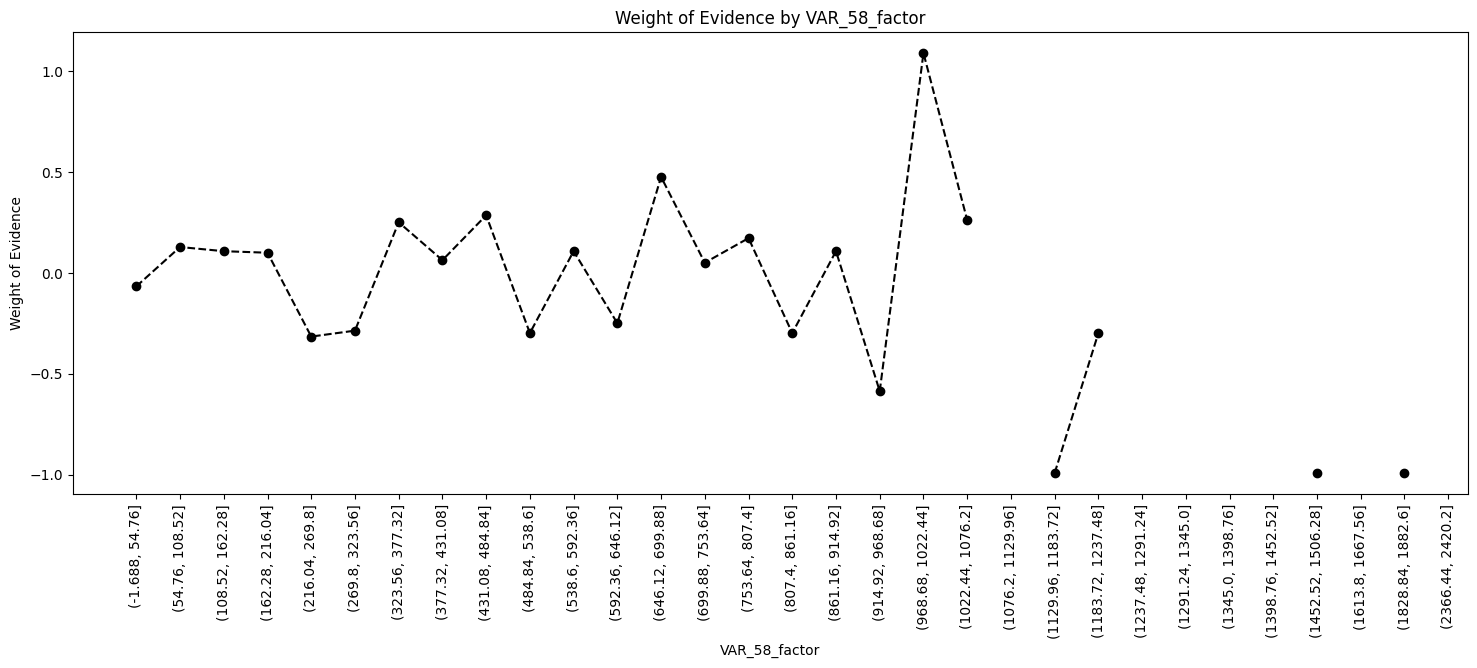

In [96]:
# Fine classing - VAR_58
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_58'])]
df_inputs_prepr_temp[f'VAR_58_factor'] = pd.cut(df_inputs_prepr_temp['VAR_58'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_58_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [97]:
df_inputs_prepr['VAR_58'].isnull().sum()

773

/tmp/ipykernel_11938/837560223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_59_factor'] = pd.cut(df_inputs_prepr_temp['VAR_59'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_59_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0       (-1.913, 38.264]   34    90    124  0.099121  0.110749  0.095339   
1       (38.264, 76.527]   25    59     84  0.067146  0.081433  0.062500   
2      (76.527, 114.791]   20    72     92  0.073541  0.065147  0.076271   
3     (114.791, 153.054]   20    52     72  0.057554  0.065147  0.055085   
4     (153.054, 191.318]   29    65     94  0.075140  0.094463  0.068856   
5     (191.318, 229.582]   28    68     96  0.076739  0.091205  0.072034   
6     (229.582, 267.845]   23    75     98  0.078337  0.074919  0.079449   
7     (267.845, 306.109]   18    60     78  0.062350  0.058632  0.063559   
8     (306.109, 344.372]   14    54     68  0.054357  0.045603  0.057203   
9     (344.372, 382.636]   20    45     65  0.051958  0.065147  0.047669   
10      (382.636, 420.9]   16    48     64  0.051159  0.052117  0.050847   
11      (420.9, 459.163]    6    44     50  0.039968  0.019544  0.046610   
12    (459.163, 497.427]    7    29     36  0.028777  0.022801  0.030720   
13     (497.427, 535.69]   10    29     39  0.031175  0.032573  0.030720   
14     (535.69, 573.954]    6    26     32  0.025580  0.019544  0.027542   
15    (573.954, 612.218]    5    18     23  0.018385  0.016287  0.019068   
16    (612.218, 650.481]    0    19     19  0.015188  0.000000  0.020127   
17    (650.481, 688.745]    2    15     17  0.013589  0.006515  0.015890   
18    (688.745, 727.008]    6    18     24  0.019185  0.019544  0.019068   
19    (727.008, 765.272]    3     9     12  0.009592  0.009772  0.009534   
20    (765.272, 803.536]    1     5      6  0.004796  0.003257  0.005297   
21    (803.536, 841.799]    3     8     11  0.008793  0.009772  0.008475   
22    (841.799, 880.063]    1     5      6  0.004796  0.003257  0.005297   
23    (880.063, 918.326]    2     6      8  0.006395  0.006515  0.006356   
24     (918.326, 956.59]    0     2      2  0.001599  0.000000  0.002119   
25     (956.59, 994.854]    0     4      4  0.003197  0.000000  0.004237   
26   (994.854, 1033.117]    1     2      3  0.002398  0.003257  0.002119   
27  (1033.117, 1071.381]    1     4      5  0.003997  0.003257  0.004237   
28  (1071.381, 1109.644]    0     2      2  0.001599  0.000000  0.002119   
29  (1109.644, 1147.908]    1     1      2  0.001599  0.003257  0.001059   
30  (1147.908, 1186.172]    1     2      3  0.002398  0.003257  0.002119   
31  (1224.435, 1262.699]    0     1      1  0.000799  0.000000  0.001059   
32  (1300.962, 1339.226]    0     1      1  0.000799  0.000000  0.001059   
33   (1339.226, 1377.49]    0     1      1  0.000799  0.000000  0.001059   
34   (1377.49, 1415.753]    0     1      1  0.000799  0.000000  0.001059   
35  (1530.544, 1568.808]    1     1      2  0.001599  0.003257  0.001059   
36  (1568.808, 1607.071]    0     1      1  0.000799  0.000000  0.001059   
37  (1645.335, 1683.598]    1     0      1  0.000799  0.003257  0.000000   
38  (1721.862, 1760.126]    1     1      2  0.001599  0.003257  0.001059   
39  (1760.126, 1798.389]    0     1      1  0.000799  0.000000  0.001059   
40   (1874.916, 1913.18]    1     0      1  0.000799  0.003257  0.000000   

    DefaultRate       WoE  diff_WoE   IV  
0      0.274194 -0.149829       NaN  inf  
1      0.297619 -0.264617  0.114788  inf  
2      0.217391  0.157655  0.422272  inf  
3      0.277778 -0.167767  0.325422  inf  
4      0.308511 -0.316187  0.148420  inf  
5      0.291667 -0.235975  0.080212  inf  
6      0.234694  0.058715  0.294691  inf  
7      0.230769  0.080694  0.021979  inf  
8      0.205882  0.226648  0.145954  inf  
9      0.307692 -0.312348  0.538997  inf  
10     0.250000 -0.024666  0.287682  inf  
11     0.120000  0.869152  0.893818  inf  
12     0.194444  0.298107  0.571044  inf  
13     0.256410 -0.058568  0.356675  inf  
14     0.187500  0.343059  0.401626  inf  
15     0.217391  0.157655  0.185403  inf  
16     0.000000       inf       inf  inf  
17     0.117647  0.891625       inf  inf  
1

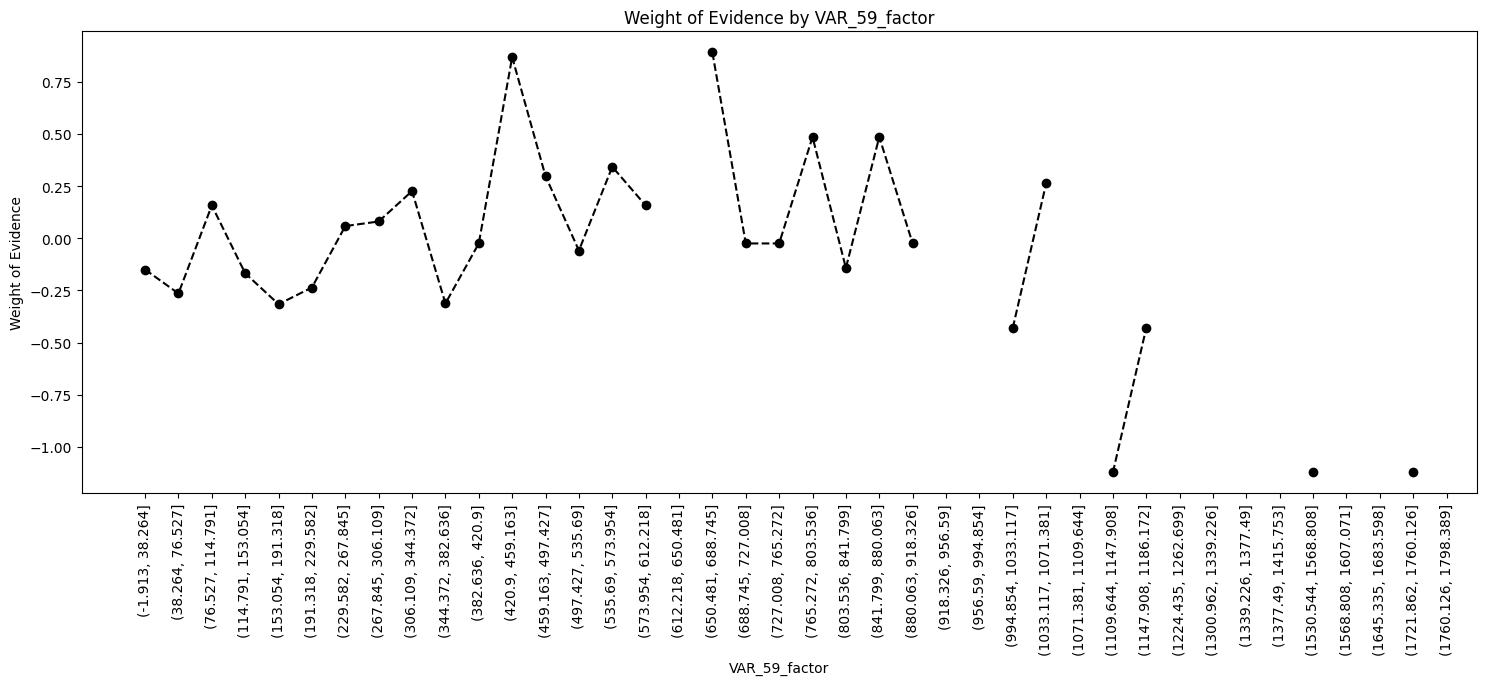

In [98]:
# Fine classing - VAR_59
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_59'])]
df_inputs_prepr_temp[f'VAR_59_factor'] = pd.cut(df_inputs_prepr_temp['VAR_59'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_59_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [99]:
df_inputs_prepr['VAR_59'].isnull().sum()

897

/tmp/ipykernel_11938/276334851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_65_factor'] = pd.cut(df_inputs_prepr_temp['VAR_65'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_65_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0       (-10.646, 212.929]   88   143    231  0.135088  0.172211  0.119266   
1       (212.929, 425.858]   85   153    238  0.139181  0.166341  0.127606   
2       (425.858, 638.786]   83   165    248  0.145029  0.162427  0.137615   
3       (638.786, 851.715]   75   160    235  0.137427  0.146771  0.133445   
4      (851.715, 1064.644]   46   104    150  0.087719  0.090020  0.086739   
5     (1064.644, 1277.573]   23    81    104  0.060819  0.045010  0.067556   
6     (1277.573, 1490.502]   18    66     84  0.049123  0.035225  0.055046   
7      (1490.502, 1703.43]   16    42     58  0.033918  0.031311  0.035029   
8      (1703.43, 1916.359]   12    30     42  0.024561  0.023483  0.025021   
9     (1916.359, 2129.288]   15    40     55  0.032164  0.029354  0.033361   
10    (2129.288, 2342.217]    6    27     33  0.019298  0.011742  0.022519   
11    (2342.217, 2555.146]    7    31     38  0.022222  0.013699  0.025855   
12    (2555.146, 2768.074]    8    21     29  0.016959  0.015656  0.017515   
13    (2768.074, 2981.003]    2    15     17  0.009942  0.003914  0.012510   
14    (2981.003, 3193.932]    5    14     19  0.011111  0.009785  0.011676   
15    (3193.932, 3406.861]    0     5      5  0.002924  0.000000  0.004170   
16     (3406.861, 3619.79]    2    10     12  0.007018  0.003914  0.008340   
17     (3619.79, 3832.718]    2    12     14  0.008187  0.003914  0.010008   
18    (3832.718, 4045.647]    0     3      3  0.001754  0.000000  0.002502   
19    (4045.647, 4258.576]    2    13     15  0.008772  0.003914  0.010842   
20    (4258.576, 4471.505]    2     5      7  0.004094  0.003914  0.004170   
21    (4471.505, 4684.434]    1     6      7  0.004094  0.001957  0.005004   
22    (4684.434, 4897.362]    2     7      9  0.005263  0.003914  0.005838   
23    (4897.362, 5110.291]    0     4      4  0.002339  0.000000  0.003336   
24     (5110.291, 5323.22]    2     7      9  0.005263  0.003914  0.005838   
25     (5323.22, 5536.149]    3     7     10  0.005848  0.005871  0.005838   
26    (5536.149, 5749.078]    0     2      2  0.001170  0.000000  0.001668   
27    (5749.078, 5962.006]    1     5      6  0.003509  0.001957  0.004170   
28    (5962.006, 6174.935]    0     3      3  0.001754  0.000000  0.002502   
29    (6174.935, 6387.864]    0     1      1  0.000585  0.000000  0.000834   
30    (6387.864, 6600.793]    0     1      1  0.000585  0.000000  0.000834   
31    (6600.793, 6813.722]    2     2      4  0.002339  0.003914  0.001668   
32     (6813.722, 7026.65]    0     3      3  0.001754  0.000000  0.002502   
33     (7026.65, 7239.579]    1     0      1  0.000585  0.001957  0.000000   
34    (7239.579, 7452.508]    1     1      2  0.001170  0.001957  0.000834   
35    (7452.508, 7665.437]    1     3      4  0.002339  0.001957  0.002502   
36    (8517.152, 8730.081]    0     2      2  0.001170  0.000000  0.001668   
37     (8730.081, 8943.01]    0     1      1  0.000585  0.000000  0.000834   
38    (9155.938, 9368.867]    0     2      2  0.001170  0.000000  0.001668   
39  (10007.654, 10220.582]    0     1      1  0.000585  0.000000  0.000834   
40   (10433.511, 10646.44]    0     1      1  0.000585  0.000000  0.000834   

    DefaultRate       WoE  diff_WoE   IV  
0      0.380952 -0.367366       NaN  inf  
1      0.357143 -0.265087  0.102279  inf  
2      0.334677 -0.165769  0.099318  inf  
3      0.319149 -0.095188  0.070581  inf  
4      0.306667 -0.037124  0.058064  inf  
5      0.221154  0.406081  0.443205  inf  
6      0.214286  0.446409  0.040328  inf  
7      0.275862  0.112207  0.334202  inf  
8      0.285714  0.063417  0.048790  inf  
9      0.272727  0.127956  0.064539  inf  
10     0.181818  0.651204  0.523248  inf  
11     0.184211  0.635203  0.016000  inf  
12     0.275862  0.112207  0.522996  inf  
13     0.117647  1.162029  1.049822  inf  
14     0.263158  0.176746  0.985284  inf  
15     0.000000       inf       inf  inf  
16   

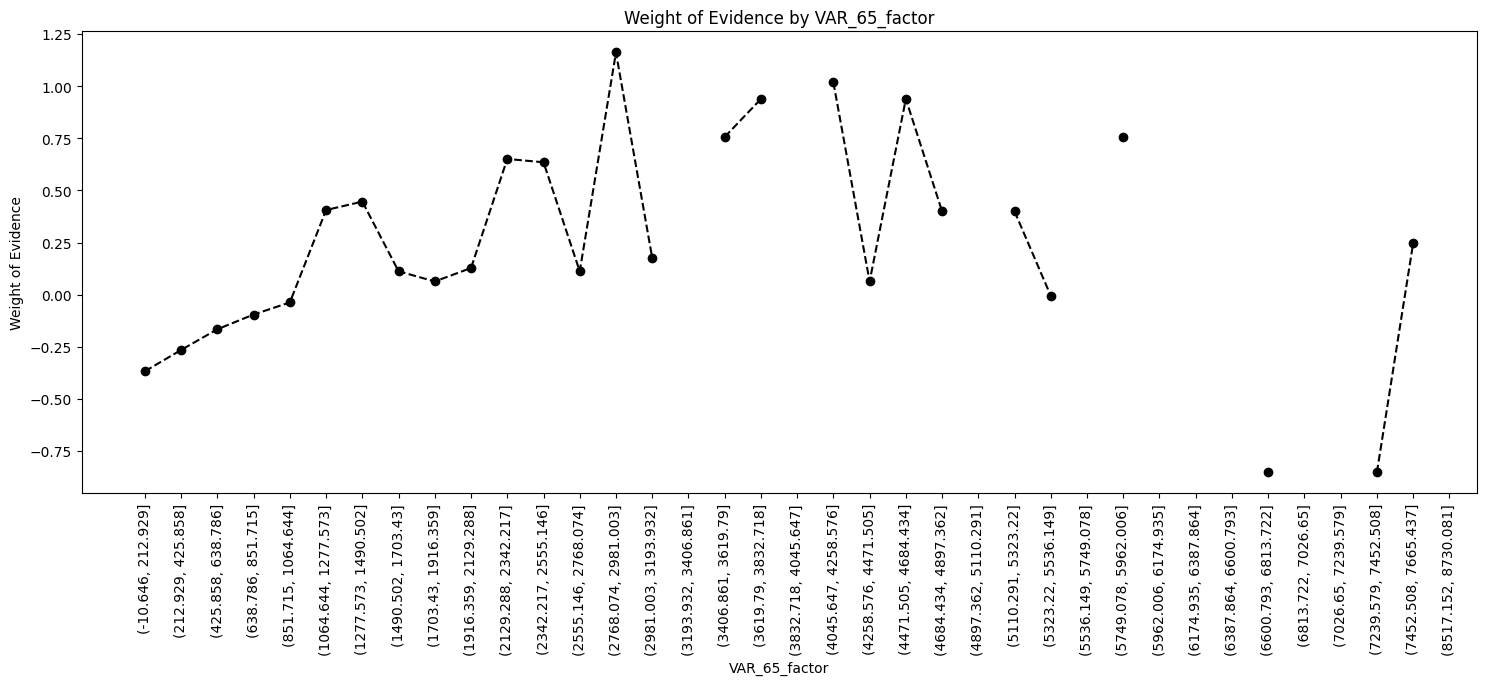

In [100]:
# Fine classing - VAR_65
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_65'])]
df_inputs_prepr_temp[f'VAR_65_factor'] = pd.cut(df_inputs_prepr_temp['VAR_65'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_65_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [101]:
df_inputs_prepr['VAR_65'].isnull().sum()

438

In [102]:
 # VAR_65
df_inputs_prepr['VAR_65:Missing'] = np.where((df_inputs_prepr['VAR_65'].isnull()), 1, 0)
df_inputs_prepr['VAR_65:<=1120.334'] = np.where((df_inputs_prepr['VAR_65']<=1120.334), 1, 0)
df_inputs_prepr['VAR_65:>1120.334'] = np.where((df_inputs_prepr['VAR_65']>1120.334), 1, 0)

/tmp/ipykernel_11938/66303772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_72_factor'] = pd.cut(df_inputs_prepr_temp['VAR_72'],50)


VAR_72_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0   (-106.755, -27.9]   70   150    220  0.103093  0.114007  0.098684   
1       (-27.9, 47.2]  245   575    820  0.384255  0.399023  0.378289   
2       (47.2, 122.3]  114   285    399  0.186973  0.185668  0.187500   
3      (122.3, 197.4]   61   139    200  0.093721  0.099349  0.091447   
4      (197.4, 272.5]   35    87    122  0.057170  0.057003  0.057237   
5      (272.5, 347.6]   22    55     77  0.036082  0.035831  0.036184   
6      (347.6, 422.7]   11    36     47  0.022024  0.017915  0.023684   
7      (422.7, 497.8]   13    36     49  0.022962  0.021173  0.023684   
8      (497.8, 572.9]   10    27     37  0.017338  0.016287  0.017763   
9      (572.9, 648.0]    8    29     37  0.017338  0.013029  0.019079   
10     (648.0, 723.1]    4     9     13  0.006092  0.006515  0.005921   
11     (723.1, 798.2]    8    12     20  0.009372  0.013029  0.007895   
12     (798.2, 873.3]    2     8     10  0.004686  0.003257  0.005263   
13     (873.3, 948.4]    2    11     13  0.006092  0.003257  0.007237   
14    (948.4, 1023.5]    0     8      8  0.003749  0.000000  0.005263   
15   (1023.5, 1098.6]    2     4      6  0.002812  0.003257  0.002632   
16   (1098.6, 1173.7]    2     6      8  0.003749  0.003257  0.003947   
17   (1173.7, 1248.8]    0     7      7  0.003280  0.000000  0.004605   
18   (1248.8, 1323.9]    2     5      7  0.003280  0.003257  0.003289   
19   (1323.9, 1399.0]    0     4      4  0.001874  0.000000  0.002632   
20   (1399.0, 1474.1]    1     5      6  0.002812  0.001629  0.003289   
21   (1474.1, 1549.2]    0     4      4  0.001874  0.000000  0.002632   
22   (1549.2, 1624.3]    1     4      5  0.002343  0.001629  0.002632   
23   (1624.3, 1699.4]    0     2      2  0.000937  0.000000  0.001316   
24   (1699.4, 1774.5]    1     2      3  0.001406  0.001629  0.001316   
25   (1774.5, 1849.6]    0     2      2  0.000937  0.000000  0.001316   
26   (1849.6, 1924.7]    0     3      3  0.001406  0.000000  0.001974   
27   (2150.0, 2225.1]    0     1      1  0.000469  0.000000  0.000658   
28   (2225.1, 2300.2]    0     1      1  0.000469  0.000000  0.000658   
29   (2375.3, 2450.4]    0     1      1  0.000469  0.000000  0.000658   
30   (3276.5, 3351.6]    0     1      1  0.000469  0.000000  0.000658   
31   (3576.9, 3652.0]    0     1      1  0.000469  0.000000  0.000658   

    DefaultRate       WoE  diff_WoE   IV  
0      0.318182 -0.144331       NaN  inf  
1      0.298780 -0.053359  0.090972  inf  
2      0.285714  0.009820  0.063179  inf  
3      0.305000 -0.082871  0.092691  inf  
4      0.286885  0.004089  0.086960  inf  
5      0.285714  0.009820  0.005731  inf  
6      0.234043  0.279153  0.269333  inf  
7      0.265306  0.112099  0.167054  inf  
8      0.270270  0.086781  0.025318  inf  
9      0.216216  0.381384  0.294603  inf  
10     0.307692 -0.095540  0.476924  inf  
11     0.400000 -0.501006  0.405465  inf  
12     0.200000  0.479824  0.980829  inf  
13     0.153846  0.798277  0.318454  inf  
14     0.000000       inf       inf  inf  
15     0.333333 -0.213324       inf  inf  
16     0.250000  0.192142  0.405465  inf  
17     0.000000       inf       inf  inf  
18     0.285714  0.009820       inf  inf  
19     0.000000       inf       inf  inf  
20     0.166667  0.702967       inf  inf  
21     0.000000       inf       inf  inf  
22     0.200000  0.479824       inf  inf  
23     0.000000       inf       inf  inf  
24     0.333333 -0.213324       inf  inf  
25     0.000000       inf       inf  inf  
26     0.000000       inf       NaN  inf  
27     0.000000       inf       NaN  inf  
28     0.000000       inf       NaN  inf  
29     0.000000       inf       NaN  inf  
30     0.000000       inf       NaN  inf  
31     0.000000       inf       NaN  inf

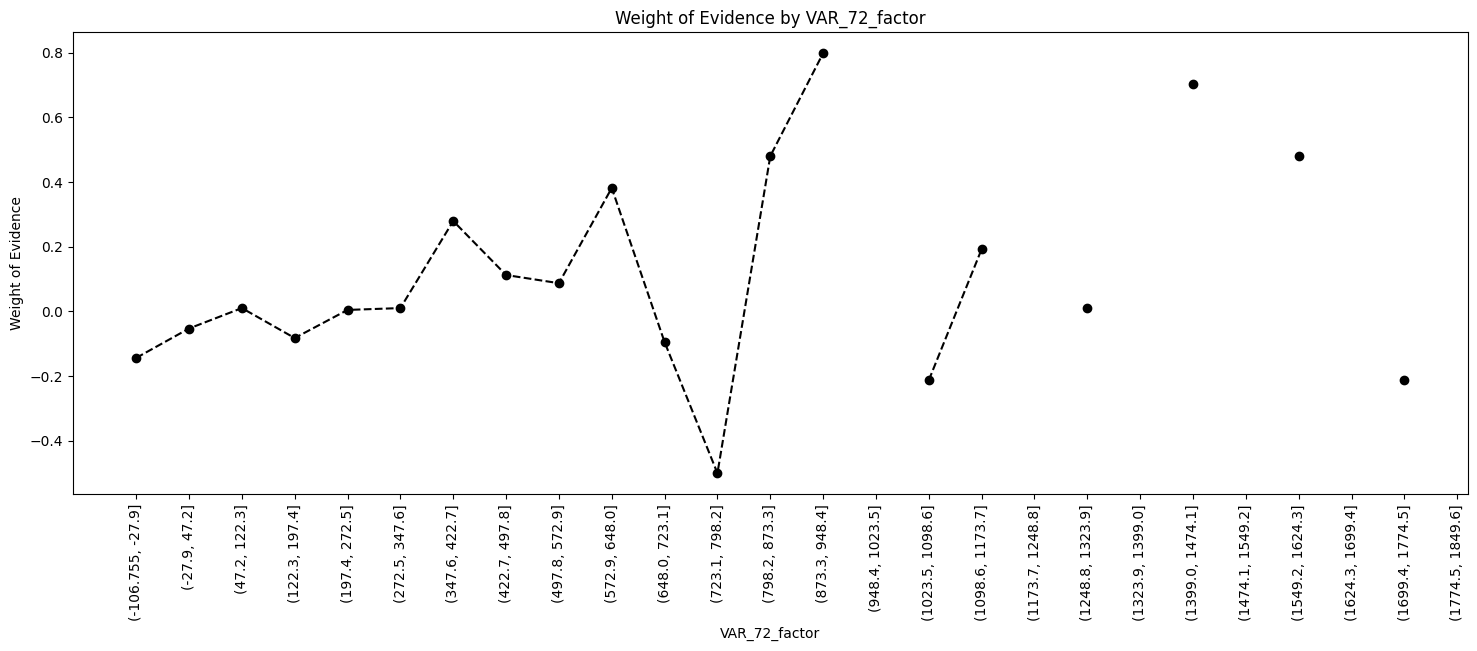

In [103]:
# Fine classing - VAR_72
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_72'])]
df_inputs_prepr_temp[f'VAR_72_factor'] = pd.cut(df_inputs_prepr_temp['VAR_72'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_72_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [104]:
df_inputs_prepr['VAR_72'].isnull().sum()

14

In [105]:
 # VAR_72
df_inputs_prepr['VAR_72:<=85.6'] = np.where((df_inputs_prepr['VAR_72']<=85.6), 1, 0)
df_inputs_prepr['VAR_72:>85.6'] = np.where((df_inputs_prepr['VAR_72']>85.6), 1, 0)

/tmp/ipykernel_11938/168625243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_76_factor'] = pd.cut(df_inputs_prepr_temp['VAR_76'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_76_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0   (-367.405, -243.824]    1     1      2  0.001599  0.003257  0.001059   
1     (-126.129, -8.433]    0     1      1  0.000799  0.000000  0.001059   
2      (-8.433, 109.262]   56   170    226  0.180655  0.182410  0.180085   
3     (109.262, 226.958]   63   159    222  0.177458  0.205212  0.168432   
4     (226.958, 344.654]   44   159    203  0.162270  0.143322  0.168432   
5     (344.654, 462.349]   42   120    162  0.129496  0.136808  0.127119   
6     (462.349, 580.045]   25    87    112  0.089528  0.081433  0.092161   
7      (580.045, 697.74]   24    67     91  0.072742  0.078176  0.070975   
8      (697.74, 815.436]   13    43     56  0.044764  0.042345  0.045551   
9     (815.436, 933.132]    7    28     35  0.027978  0.022801  0.029661   
10   (933.132, 1050.827]    7    24     31  0.024780  0.022801  0.025424   
11  (1050.827, 1168.523]    5    11     16  0.012790  0.016287  0.011653   
12  (1168.523, 1286.218]    4    12     16  0.012790  0.013029  0.012712   
13  (1286.218, 1403.914]    2     9     11  0.008793  0.006515  0.009534   
14   (1403.914, 1521.61]    2    12     14  0.011191  0.006515  0.012712   
15   (1521.61, 1639.305]    0     5      5  0.003997  0.000000  0.005297   
16  (1639.305, 1757.001]    0     6      6  0.004796  0.000000  0.006356   
17  (1757.001, 1874.696]    2     2      4  0.003197  0.006515  0.002119   
18  (1874.696, 1992.392]    1     5      6  0.004796  0.003257  0.005297   
19  (1992.392, 2110.088]    1     4      5  0.003997  0.003257  0.004237   
20  (2110.088, 2227.783]    0     6      6  0.004796  0.000000  0.006356   
21  (2227.783, 2345.479]    0     3      3  0.002398  0.000000  0.003178   
22  (2345.479, 2463.174]    1     0      1  0.000799  0.003257  0.000000   
23   (2463.174, 2580.87]    0     4      4  0.003197  0.000000  0.004237   
24   (2580.87, 2698.566]    1     1      2  0.001599  0.003257  0.001059   
25  (2933.957, 3051.652]    0     1      1  0.000799  0.000000  0.001059   
26  (3051.652, 3169.348]    1     0      1  0.000799  0.003257  0.000000   
27  (3287.044, 3404.739]    0     1      1  0.000799  0.000000  0.001059   
28   (3522.435, 3640.13]    0     1      1  0.000799  0.000000  0.001059   
29   (3640.13, 3757.826]    1     0      1  0.000799  0.003257  0.000000   
30  (3875.522, 3993.217]    1     0      1  0.000799  0.003257  0.000000   
31  (4228.608, 4346.304]    1     0      1  0.000799  0.003257  0.000000   
32    (4346.304, 4464.0]    0     1      1  0.000799  0.000000  0.001059   
33  (5170.173, 5287.869]    1     0      1  0.000799  0.003257  0.000000   
34  (5287.869, 5405.564]    1     0      1  0.000799  0.003257  0.000000   
35   (5405.564, 5523.26]    0     1      1  0.000799  0.000000  0.001059   

    DefaultRate       WoE  diff_WoE   IV  
0      0.500000 -1.123278       NaN  inf  
1      0.000000       inf       inf  inf  
2      0.247788 -0.012832       inf  inf  
3      0.283784 -0.197509  0.184677  inf  
4      0.216749  0.161436  0.358945  inf  
5      0.259259 -0.073456  0.234892  inf  
6      0.223214  0.123754  0.197210  inf  
7      0.263736 -0.096640  0.220394  inf  
8      0.232143  0.072972  0.169612  inf  
9      0.200000  0.263016  0.190044  inf  
10     0.225806  0.108865  0.154151  inf  
11     0.312500 -0.334821  0.443686  inf  
12     0.250000 -0.024666  0.310155  inf  
13     0.181818  0.380799  0.405465  inf  
14     0.142857  0.668481  0.287682  inf  
15     0.000000       inf       inf  inf  
16     0.000000       inf       NaN  inf  
17     0.500000 -1.123278       inf  inf  
18     0.166667  0.486159  1.609438  inf  
19     0.200000  0.263016  0.223144  inf  
20     0.000000       inf       inf  inf  
21     0.000000       inf       NaN  inf  
22     1.000000      -inf       inf  inf  
23     0.000000       inf       inf  inf  
24     0.500000 -1.123278       inf  inf  
25     0.000000       inf       inf  inf  
26     1.000000      -inf       inf  

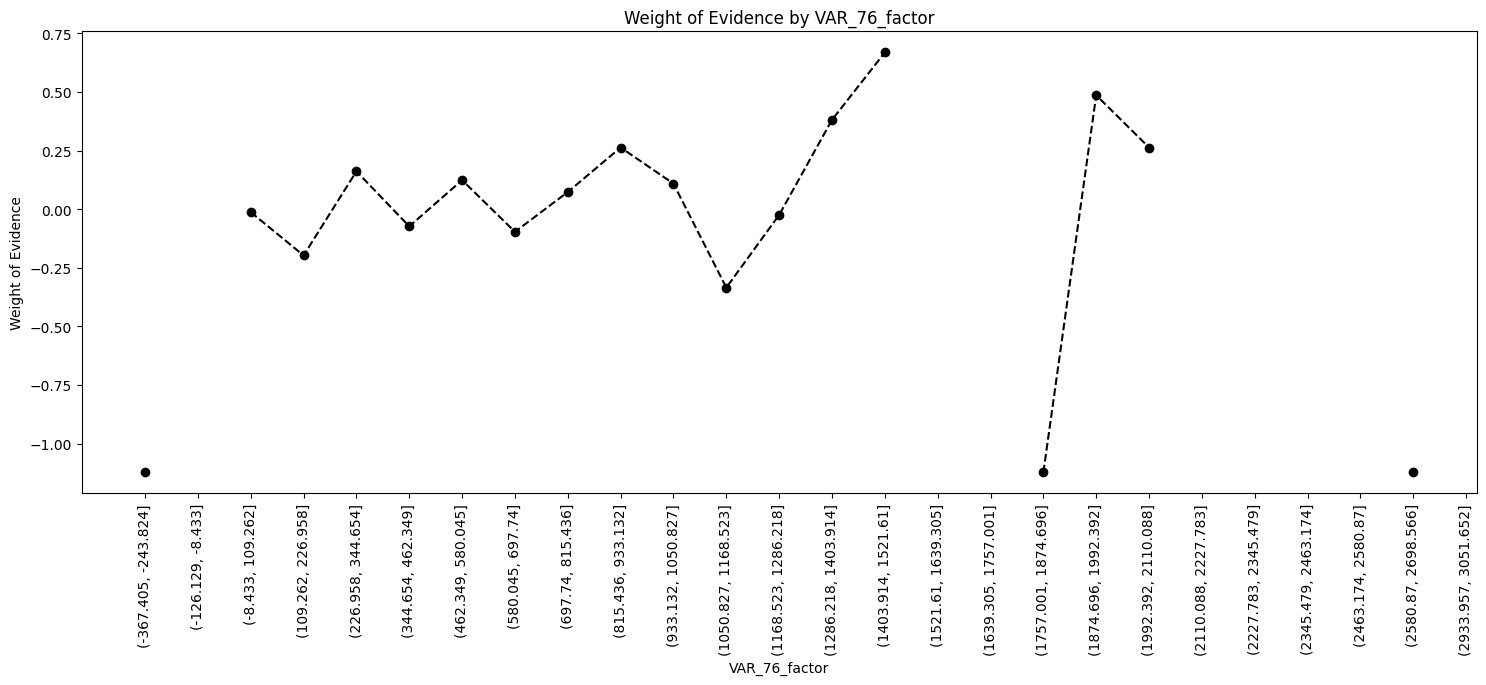

In [106]:
# Fine classing - VAR_76
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_76'])]
df_inputs_prepr_temp[f'VAR_76_factor'] = pd.cut(df_inputs_prepr_temp['VAR_76'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_76_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [107]:
df_inputs_prepr['VAR_76'].isnull().sum()

897

In [108]:
df_inputs_prepr.columns.values

array(['Unnamed: 0', 'id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3',
       'VAR_4', 'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15',
       'VAR_17', 'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32',
       'VAR_33', 'VAR_34', 'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52',
       'VAR_53', 'VAR_54', 'VAR_58', 'VAR_59', 'VAR_60', 'VAR_64',
       'VAR_65', 'VAR_72', 'VAR_76', 'safra_dt', 'months_since_cr_line',
       'VAR_2:0', 'VAR_2:1-14_or_missing', 'VAR_3:Missing', 'VAR_3:0',
       'VAR_3:1-10', 'VAR_4:Missing', 'VAR_4:0', 'VAR_4:1-14',
       'VAR_20:3-10', 'VAR_20:11-12', 'VAR_28:Missing', 'VAR_28:0_8',
       'VAR_28:1-7_9-12', 'VAR_32:<0.13', 'VAR_32:>=0.13', 'VAR_33:0',
       'VAR_33:>0_or_missing', 'VAR_60:<-.025', 'VAR_60:-0.25to-0.004',
       'VAR_60:>-0.004', 'VAR_64:0', 'VAR_64:1',
       'months_since_cr_line:37-38', 'months_since_cr_line:39',
       'months_since_cr_line:40', 'months_since_cr_line:41-46',
       'months_since_cr_line:47-48', 'VAR_1:<=4.16', 'VAR_1:4.

### Save the test dataset

In [109]:
loan_data_inputs_test = df_inputs_prepr

In [110]:
loan_data_inputs_test.to_csv('loan_data_inputs_test.csv')
df_targets_prepr.to_csv('loan_data_targets_test.csv')